In [285]:
hdu = pyfits.open('/data/galprop2/FITS/HI_Pohl_8500_rlb.fits')

In [286]:
hdu[0].header.cards

('SIMPLE', True, 'conforms to FITS standard')
('BITPIX', -32, 'array data type')
('NAXIS', 3, 'number of array dimensions')
('NAXIS1', 380, '')
('NAXIS2', 721, '')
('NAXIS3', 361, '')
('EXTEND', False, '')
('CTYPE1', 'distance', '')
('CUNIT1', 'kpc', '')
('CRVAL1', 0.05312500000000001, '')
('CRPIX1', 0, '')
('CDELT1', 0.10625, '')
('CTYPE2', 'GLON-CAR', '')
('CUNIT2', 'deg', '')
('CRVAL2', 0.0, '')
('CRPIX2', 0, '')
('CDELT2', 0.5, '')
('CTYPE3', 'GLAT-CAR', '')
('CUNIT3', 'deg', '')
('CRVAL3', -90.0, '')
('CRPIX3', 0, '')
('CDELT3', 0.5, '')
('CREATOR', 'Eric Carlson (erccarls@ucsc.edu)', '')
('COMMENT', 'Generated by Eric Carlson (erccarls@ucsc.edu) from Martin Pohl mapcube.', '')

In [267]:


def PlotROI(lonra, laran, drange):
    hdu = pyfits.open('/data/galprop2/FITS/CO_Pohl_8500_rlb.fits')
    d = hdu[0].data
    delta_r = hdu[0].header['CDELT1']
    
    start, stop = int(np.round(drange[0]/delta_r)), int(np.round(drange[1]/delta_r))
    print np.shape(d)
    im = plt.imshow(np.log10(np.sum(np.roll(d[:,:,start:stop],1440, axis=1), axis=2)), extent=[-180,180, -30,30], vmin=-1.5, origin='lower')
    plt.colorbar(im,label=r'log10($\rm W_{CO}$)')

    
    return np.sum(np.roll(d[:,:,start:stop],1440, axis=1), axis=2)[240-8*5:240+15*8,1440+15*8:1440+45*8]
    
    


(481, 2881, 280)


/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


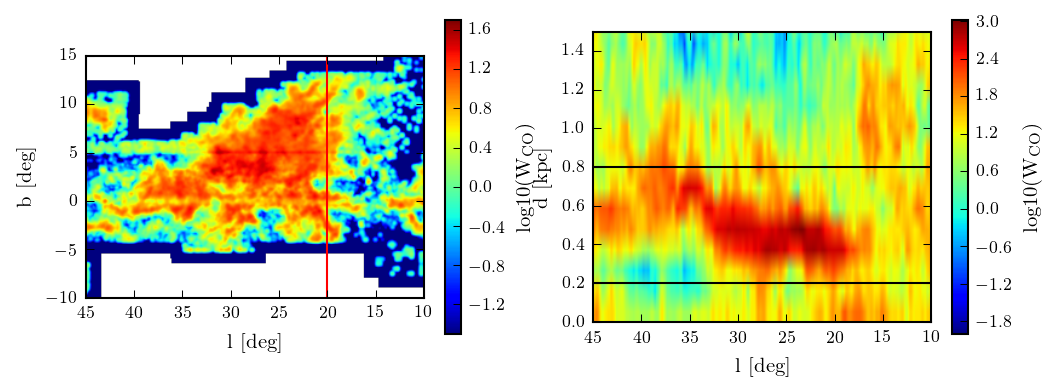

In [268]:
plt.figure(figsize=(8,2.7))

plt.subplot(121)
cartmap = PlotROI([0,360], [-90,90],[0.2,0.8])

plt.vlines(20,-30,30,color='r')
plt.xlim(45,10)
plt.ylim(-10,15)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')

plt.subplot(122)

hdu = pyfits.open('/data/galprop2/FITS/CO_Pohl_8500_rlb.fits')
d = hdu[0].data
delta_r = hdu[0].header['CDELT1']

#start, stop = int(np.round(drange[0]/delta_r)), int(np.round(drange[1]/delta_r))
#print np.shape(d)
im = plt.imshow(np.log10(np.sum(d[240-80:240+120,0:400,0:20], axis=0)).T, extent=[0,50,0,0.10625*20], vmin=-2, origin='lower', aspect=20, cmap='jet')
plt.colorbar(im,label=r'log10($\rm W_{CO}$)')
plt.xlabel('l [deg]')
plt.ylabel('d [kpc]')
plt.xlim(45,10)
plt.ylim(0,1.5)
plt.hlines([.2,.8],-50,50)
    

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/aquila_rift_template.pdf', bbox_inches='tight')


In [299]:
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.ndimage.interpolation import zoom
import healpy
import sys
sys.path.append('/data/GCE_sys/')
import Tools
import Analysis
import copy



def hpix2ang(hpix, nside=256, nest=True):
    """
    Transform the healpix index into lat/lon in degrees with lon in [-180,180]

    :param hpix: healpix index
    :param nside: healpix nside parameter
    :returns l,b: latitude and longitude of the input.
    """
    b, l = np.rad2deg(healpy.pix2ang(nside, hpix, nest=nest))
    b = 90-b
    l[l>180] -= 360
    return l, b


def Cart2Healpix(cartmap, nside, extent, res=.125):
    
    extent = np.array(extent)
    #extent[extent[:2]>180] -= 360
    
    # Get angular coords of healpix map 
    l, b = hpix2ang(np.arange(12*1024**2),nside=1024, nest=False)
    
    # Build interpolator for the cartesian map.
    lons = np.linspace(extent[0],extent[1],int(np.round((extent[1]-extent[0])/res)))
    lats = np.linspace(extent[2],extent[3],int(np.round((extent[3]-extent[2])/res)))
    #print lats, lons, lats.shape, lons.shape
    rgi = RGI((lats,lons), cartmap, fill_value=0, bounds_error=False)
    
    # Find
    #nonzero = np.where( (l>extent[0]) & (l<extent[1]) ) 
    
    t_in = rgi((b,l), method='linear').astype(np.float32)
    
    return healpy.pixelfunc.ud_grade(t_in, nside_out=nside)

In [134]:
print cartmap.shape

m = Cart2Healpix(cartmap,nside=256, extent=[15,45,-5,15])

(160, 240)


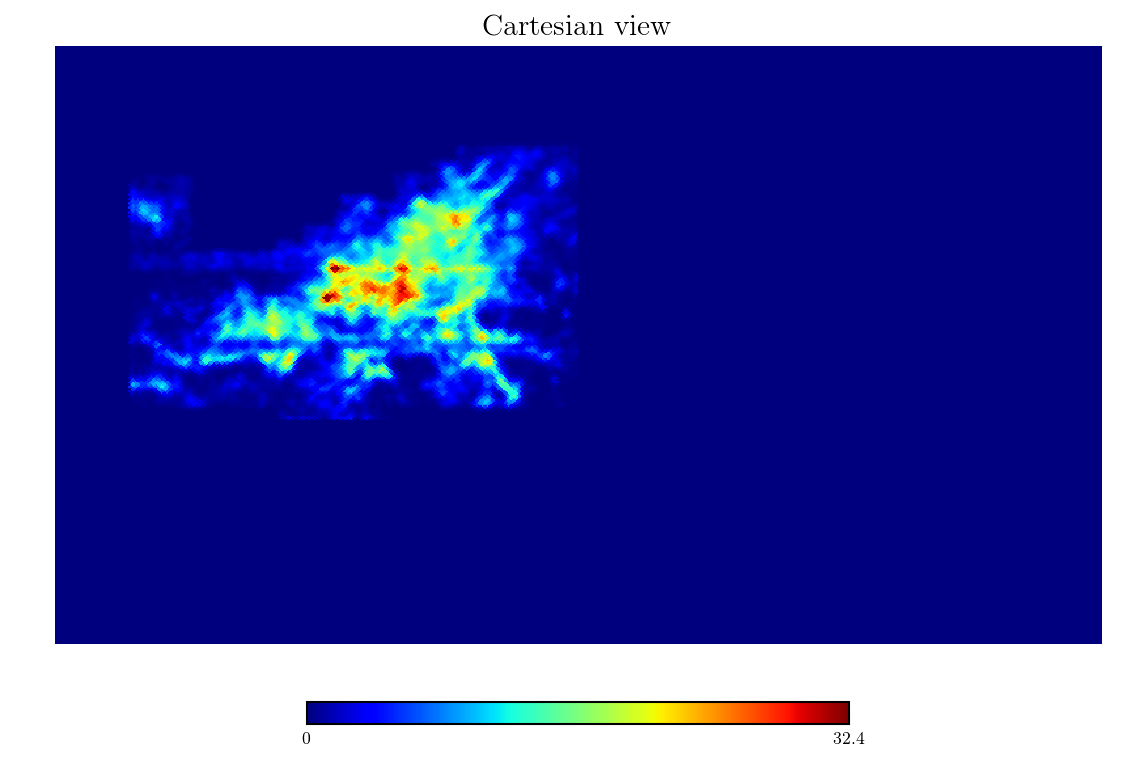

In [135]:
healpy.cartview(m, latra=[-20,20], lonra=[-20,50])

np.save('aquila_rift_template.npy',m)

In [139]:
import numpy as np
import h5py
import Analysis
from copy import deepcopy

def AddFitMetadata(path, h5_path, A, extra_dict=None):
        h5 = h5py.File(path)
        
        try: 
            h5.create_group(h5_path)
        except:
            del h5[h5_path]
            h5.create_group(h5_path)
            

        fa = h5[h5_path].attrs
        fit = A.SaveFit()

        for key, val in fit.items():
            if key not in ['Data', 'energies', 'loglike', 'PSC']:
                fa.create('flux_'+key,val['flux'])
                fa.create('fluxunc_'+key,val['fluxunc'])        

        fa.create('loglike_total',np.sum(A.loglike))
        fa.create('loglike',A.loglike)
        fa.create('energies',A.central_energies)
        fa.create('bins', A.bin_edges)
        fa.create('irf', A.irf)
        fa.create('evclass', A.evclass)
        fa.create('convtype', A.convtype)
        fa.create('phfile', A.phfile)
        fa.create('tag', A.tag)

        if extra_dict is not None:
            for key, val in extra_dict.items():
                if key == 'residual':
                    try:
                        del h5[h5_path+'/residual']
                    except: 
                        pass

                    h5.create_dataset(h5_path+'/residual', data=val, dtype='float32')
                    print 'Saving new residual... Shape = ', val.shape
                else:
                    fa.create(key, val)
        h5.close()

def LoadModel(basedir, galprop_tag):
    # Load various diffuse models and run fits.
    print 'Running Analysis for model', galprop_tag
    
    
    #A = Analysis.Analysis(tag='P8R2_PSF3_CLEAN_V6_calore', basepath='/data/GCE_sys/')
    A = Analysis.Analysis(tag='P8R2_CLEAN_V6_calore', basepath='/data/GCE_sys/')
    
    A.GenSquareMask(l_range=[-20.,20.], b_range=[-20.,20.], plane_mask=2.)
    A.BinPhotons(infile='binned_photons_'+A.tag+'.npy')
    # Load 2FGL 
    A.AddPointSourceTemplate(fixNorm=True,pscmap='PSC_' + A.tag + '_fgl3_with_ext.npy')
    A.CalculatePixelWeights(diffuse_model='fermi_diffuse_'+A.tag+'.npy',psc_model='PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1)
    A.AddIsotropicTemplate(fixNorm=False, fixSpectrum=False) # External chi^2 used to fix normalization within uncertainties
    
    A.AddFermiBubbleTemplate(template_file='./bubble_templates_diskcut30.0.fits', 
                         spec_file='./reduced_bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False)
    
    
    A.AddHDF5Template(hdf5file=basedir +'/'+ galprop_tag+'.hdf5',verbosity=1, multiplier=1., bremsfrac=1.25, 
                  E_subsample=2, fixSpectrum=False, separate_ics=False)
    return A



In [382]:
# A = LoadModel('/data/GCE_sys/new/iter1/','mod_s_46_XCO_P8')
# A2 = LoadModel('/data/GCE_sys/new/iter1/','mod_s_46_XCO_P8')
# A3 = LoadModel('/data/GCE_sys/new/iter1/','mod_s_46_XCO_P8')
# A4 = LoadModel('/data/GCE_sys/new/iter1/','mod_s_46_XCO_P8')
# A5 = LoadModel('/data/GCE_sys/new/iter1/','mod_s_46_XCO_P8')


A = LoadModel('/data/GCE_sys/new/','mod_s_17_XCO_P8')
A2 = LoadModel('/data/GCE_sys/new/','mod_s_17_XCO_P8')
A3 = LoadModel('/data/GCE_sys/new/','mod_s_17_XCO_P8')
A4 = LoadModel('/data/GCE_sys/new/','mod_s_17_XCO_P8')
A5 = LoadModel('/data/GCE_sys/new/','mod_s_17_XCO_P8')

Running Analysis for model mod_s_17_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...
Running Analysis for model mod_s_17_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...
Running Analysis for model mod_s_17_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...
Running Analysis for model mod_s_17_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...
Running Analysis for model mod_s_17_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...


In [383]:
AR_temp_single = np.load('./aquila_rift_template.npy').astype(np.float32).clip(0,1e50)
AR_template = np.zeros((A.n_bins,len(AR_temp_single)))

SC_temp_single = np.load('./sag_carina_template.npy').astype(np.float32).clip(0,1e50)
SC_template = np.zeros((A.n_bins,len(SC_temp_single)))

SC_HI_temp_single = np.load('./sag_carina_HI_template.npy').astype(np.float32).clip(0,1e50)
SC_HI_template = np.zeros((A.n_bins,len(SC_HI_temp_single)))


for i in range(A.n_bins):
    AR_template[i] = AR_temp_single/np.max(AR_temp_single)*1e-8/A.central_energies[i]
    SC_template[i] = SC_temp_single/np.max(SC_temp_single)*1e-8/A.central_energies[i]
    SC_HI_template[i] = SC_HI_temp_single/np.max(SC_HI_temp_single)*1e-8/A.central_energies[i]
    
    
A2.AddTemplate('AqRift',AR_template)
A3.AddTemplate('AqRift',AR_template)
A4.AddTemplate('AqRift',AR_template)
A5.AddTemplate('AqRift',AR_template)
A3.AddTemplate('SagCarina',SC_template)
A4.AddTemplate('SagCarina',SC_HI_template)

A5.AddTemplate('SagCarinaHI',SC_HI_template)
A5.AddTemplate('SagCarina',SC_template)
    
for i in range(A.n_bins):
    A2.templateList['AqRift'].healpixCube[i] = A2.templateList['AqRift'].healpixCube[i].clip(0)
    A3.templateList['AqRift'].healpixCube[i] = A3.templateList['AqRift'].healpixCube[i].clip(0)
    A4.templateList['AqRift'].healpixCube[i] = A4.templateList['AqRift'].healpixCube[i].clip(0)
    A3.templateList['SagCarina'].healpixCube[i] = A3.templateList['SagCarina'].healpixCube[i].clip(0)
    A4.templateList['SagCarina'].healpixCube[i] = A4.templateList['SagCarina'].healpixCube[i].clip(0)
    A5.templateList['SagCarina'].healpixCube[i] = A5.templateList['SagCarina'].healpixCube[i].clip(0)
    A5.templateList['SagCarinaHI'].healpixCube[i] = A5.templateList['SagCarinaHI'].healpixCube[i].clip(0)

In [370]:

for a in [A,A2,A3,A4,A5]:
    a.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
              r_s=20.0, axesratio=1., offset=(0., 0.), spec_file=None,)

In [384]:
A.ResetFit()    

#A.DeleteTemplate('DM')

for key, template in A.templateList.items():
    if key not in ['DM','AqRift']:
        template.limits=[None,None]
        
    if key in ['DM','AqRift']:
        template.limits=[-10,10]


A.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]
A2.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]
A3.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]
A4.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]
A5.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]


Masking completed in 2.6674e-01 s
Write likelihood tempfile to  /tmp/tmpT0_seG
Code generation completed in 9.6297e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602066.279909 
 TOTAL NCALL = 119 
 NCALLS = 119 
 
 
 EDM = 7.09058313075e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_0 
 8.294732e-01 
 1.624472e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_0 
 1.669502e-01 
 1.414892e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_0 
 2.157246e+00 
 1.003117e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_0 
 8.990570e-01 
 6.307621e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{0}$ & 8.295e-01 & 1.624e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{0}$ & 1.670e-01 & 1.415e-01 & & & & & \\
\hline
4 & $Isotropic_{0}$ & 2.157e+00 & 1.003e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{0}$ & 8.991e-01 & 6.308e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.36e-01 s
Masking completed in 2.6459e-01 s
Write likelihood tempfile to  /tmp/tmpUc9SgO
Code generation completed in 1.0891e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -475681.614212 
 TOTAL NCALL = 119 
 NCALLS = 119 
 
 
 EDM = 1.01308180523e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_1 
 8.016146e-01 
 1.731620e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_1 
 1.388592e-01 
 1.378075e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_1 
 2.218070e+00 
 1.072268e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_1 
 9.169752e-01 
 6.704606e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{1}$ & 8.016e-01 & 1.732e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{1}$ & 1.389e-01 & 1.378e-01 & & & & & \\
\hline
4 & $Isotropic_{1}$ & 2.218e+00 & 1.072e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{1}$ & 9.170e-01 & 6.705e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.37e-01 s
Masking completed in 2.6152e-01 s
Write likelihood tempfile to  /tmp/tmp78ATIv
Code generation completed in 1.0710e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373378.115145 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 0.00353604606952 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_2 
 8.569725e-01 
 1.898172e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_2 
 3.377021e-01 
 1.366652e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_2 
 2.014876e+00 
 1.129514e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_2 
 9.319442e-01 
 7.284713e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{2}$ & 8.570e-01 & 1.898e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{2}$ & 3.377e-01 & 1.367e-01 & & & & & \\
\hline
4 & $Isotropic_{2}$ & 2.015e+00 & 1.130e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{2}$ & 9.319e-01 & 7.285e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.16e-01 s
Masking completed in 2.8958e-01 s
Write likelihood tempfile to  /tmp/tmpRzdyjq
Code generation completed in 4.4701e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -285636.666589 
 TOTAL NCALL = 104 
 NCALLS = 104 
 
 
 EDM = 6.66424190199e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_3 
 8.552678e-01 
 2.030448e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_3 
 5.868097e-01 
 1.413992e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_3 
 1.904615e+00 
 1.161364e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_3 
 9.315362e-01 
 7.808549e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{3}$ & 8.553e-01 & 2.030e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{3}$ & 5.868e-01 & 1.414e-01 & & & & & \\
\hline
4 & $Isotropic_{3}$ & 1.905e+00 & 1.161e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{3}$ & 9.315e-01 & 7.809e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.08e-01 s
Masking completed in 3.3298e-01 s
Write likelihood tempfile to  /tmp/tmp1GEuXl
Code generation completed in 1.0550e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -275380.775969 
 TOTAL NCALL = 104 
 NCALLS = 104 
 
 
 EDM = 1.03003439927e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_4 
 9.013837e-01 
 2.027252e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_4 
 4.182429e-01 
 1.304518e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_4 
 1.866542e+00 
 1.102682e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_4 
 9.213734e-01 
 7.827106e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{4}$ & 9.014e-01 & 2.027e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{4}$ & 4.182e-01 & 1.305e-01 & & & & & \\
\hline
4 & $Isotropic_{4}$ & 1.867e+00 & 1.103e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{4}$ & 9.214e-01 & 7.827e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.19e-01 s
Masking completed in 3.4104e-01 s
Write likelihood tempfile to  /tmp/tmpfwuIjh
Code generation completed in 1.0231e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -273494.536023 
 TOTAL NCALL = 109 
 NCALLS = 109 
 
 
 EDM = 1.05448506456e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_5 
 9.097206e-01 
 2.058983e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_5 
 6.868699e-01 
 1.188171e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_5 
 1.565615e+00 
 1.012824e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_5 
 9.611777e-01 
 7.981206e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{5}$ & 9.097e-01 & 2.059e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{5}$ & 6.869e-01 & 1.188e-01 & & & & & \\
\hline
4 & $Isotropic_{5}$ & 1.566e+00 & 1.013e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{5}$ & 9.612e-01 & 7.981e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.25e-01 s
Masking completed in 3.7733e-01 s
Write likelihood tempfile to  /tmp/tmpVKkW_b
Code generation completed in 1.0271e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -262834.339661 
 TOTAL NCALL = 108 
 NCALLS = 108 
 
 
 EDM = 9.01864987825e-07 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_6 
 8.802175e-01 
 1.995562e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_6 
 7.760754e-01 
 1.118004e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_6 
 1.476880e+00 
 9.169704e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_6 
 9.429485e-01 
 7.820961e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{6}$ & 8.802e-01 & 1.996e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{6}$ & 7.761e-01 & 1.118e-01 & & & & & \\
\hline
4 & $Isotropic_{6}$ & 1.477e+00 & 9.170e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{6}$ & 9.429e-01 & 7.821e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.24e-01 s
Masking completed in 3.9295e-01 s
Write likelihood tempfile to  /tmp/tmpvzQRpt
Code generation completed in 1.0378e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -244372.562102 
 TOTAL NCALL = 108 
 NCALLS = 108 
 
 
 EDM = 1.13960725765e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_7 
 8.869838e-01 
 2.074032e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_7 
 1.059987e+00 
 1.043413e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_7 
 1.388062e+00 
 9.074306e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_7 
 9.660227e-01 
 8.094227e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{7}$ & 8.870e-01 & 2.074e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{7}$ & 1.060e+00 & 1.043e-01 & & & & & \\
\hline
4 & $Isotropic_{7}$ & 1.388e+00 & 9.074e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{7}$ & 9.660e-01 & 8.094e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.24e-01 s
Masking completed in 4.2712e-01 s
Write likelihood tempfile to  /tmp/tmpvNoSs1
Code generation completed in 1.0262e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -229741.77148 
 TOTAL NCALL = 109 
 NCALLS = 109 
 
 
 EDM = 1.3911197361e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_8 
 9.585020e-01 
 2.046739e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_8 
 1.002603e+00 
 1.016619e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_8 
 1.255401e+00 
 9.155496e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_8 
 9.265193e-01 
 8.034206e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{8}$ & 9.585e-01 & 2.047e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{8}$ & 1.003e+00 & 1.017e-01 & & & & & \\
\hline
4 & $Isotropic_{8}$ & 1.255e+00 & 9.155e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{8}$ & 9.265e-01 & 8.034e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.25e-01 s
Masking completed in 4.5123e-01 s
Write likelihood tempfile to  /tmp/tmpOX8908
Code generation completed in 1.0481e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206086.34109 
 TOTAL NCALL = 80 
 NCALLS = 80 
 
 
 EDM = 0.0037976335132 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_9 
 9.449530e-01 
 2.124053e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_9 
 1.084909e+00 
 1.032848e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_9 
 1.261957e+00 
 9.255346e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_9 
 9.528932e-01 
 8.384368e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{9}$ & 9.450e-01 & 2.124e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{9}$ & 1.085e+00 & 1.033e-01 & & & & & \\
\hline
4 & $Isotropic_{9}$ & 1.262e+00 & 9.255e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{9}$ & 9.529e-01 & 8.384e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   9.29e-02 s
Masking completed in 4.7474e-01 s
Write likelihood tempfile to  /tmp/tmpmZNZxg
Code generation completed in 1.6901e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188133.994475 
 TOTAL NCALL = 108 
 NCALLS = 108 
 
 
 EDM = 1.22001632078e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_10 
 9.764701e-01 
 2.109063e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_10 
 1.126617e+00 
 9.598249e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_10 
 1.291567e+00 
 9.721348e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_10 
 9.217553e-01 
 8.414566e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{10}$ & 9.765e-01 & 2.109e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{10}$ & 1.127e+00 & 9.598e-02 & & & & & \\
\hline
4 & $Isotropic_{10}$ & 1.292e+00 & 9.721e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{10}$ & 9.218e-01 & 8.415e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.22e-01 s
Masking completed in 5.0139e-01 s
Write likelihood tempfile to  /tmp/tmpWGZUQq
Code generation completed in 1.4801e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -154462.915215 
 TOTAL NCALL = 102 
 NCALLS = 102 
 
 
 EDM = 2.44413231428e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_11 
 1.007086e+00 
 2.196475e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_11 
 1.201311e+00 
 9.681938e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_11 
 1.238717e+00 
 1.030407e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_11 
 9.182876e-01 
 8.906027e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{11}$ & 1.007e+00 & 2.196e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{11}$ & 1.201e+00 & 9.682e-02 & & & & & \\
\hline
4 & $Isotropic_{11}$ & 1.239e+00 & 1.030e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{11}$ & 9.183e-01 & 8.906e-03 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.18e-01 s
Masking completed in 5.2690e-01 s
Write likelihood tempfile to  /tmp/tmpJJvJ40
Code generation completed in 1.0250e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          ICS_12 = +1.000000
             PSC = +1.000000
      Bubbles_12 = +1.000000
    Isotropic_12 = +1.000000
    Pi0_Brems_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          ICS_12 = +nan
             PSC = +1.000000
      Bubbles_12 = +1.000000
    Isotropic_12 = +1.000000
    Pi0_Brems_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          ICS_12 = +1.000000
             PSC = +1.000000
      Bubbles_12 = +nan
    Isotropic_12 = +1.000000
    Pi0_Brems_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          ICS_12 = +1.000000
             PSC = +1

FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.31e-02 s
Masking completed in 5.5510e-01 s
Write likelihood tempfile to  /tmp/tmpeDiDIv
Code generation completed in 9.4891e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.26e-02 s
Masking completed in 5.8574e-01 s
Write likelihood tempfile to  /tmp/tmpy9ZTL9
Code generation completed in 9.3699e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.29e-02 s
Masking completed in 5.9451e-01 s
Write likelihood tempfile to  /tmp/tmp9WEIHm
Code generation completed in 1.0159e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.26e-02 s
Masking completed in 6.2915e-01 s
Write likelihood tempfile to  /tmp/tmpXHRH1O
Code generation completed in 1.0791e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.27e-02 s
Masking completed in 6.5155e-01 s
Write likelihood tempfile to  /tmp/tmpbogaJY
Code generation completed in 1.0159e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.26e-02 s
Masking completed in 6.9719e-01 s
Write likelihood tempfile to  /tmp/tmp8J0GuH
Code generation completed in 9.2912e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.27e-02 s
Masking completed in 7.1232e-01 s
Write likelihood tempfile to  /tmp/tmpzmHIls
Code generation completed in 9.3079e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.27e-02 s
Masking completed in 7.3470e-01 s
Write likelihood tempfile to  /tmp/tmp0c8vwA
Code generation completed in 9.3389e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.25e-02 s
Masking completed in 7.7262e-01 s
Write likelihood tempfile to  /tmp/tmp7LdmiL
Code generation completed in 9.6178e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.26e-02 s
Masking completed in 7.6790e-01 s
Write likelihood tempfile to  /tmp/tmp8RSqw1
Code generation completed in 9.2888e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.29e-02 s
Masking completed in 8.2070e-01 s
Write likelihood tempfile to  /tmp/tmpZsO6ug
Code generation completed in 9.4700e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.30e-02 s


+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_0 
 8.294732e-01 
 1.624463e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_0 
 1.669502e-01 
 1.414883e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_0 
 2.157246e+00 
 1.003110e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_0 
 8.990570e-01 
 6.307605e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{0}$ & 8.295e-01 & 1.624e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{0}$ & 1.670e-01 & 1.415e-01 & & & & & \\
\hline
4 & $Isotropic_{0}$ & 2.157e+00 & 1.003e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{0}$ & 8.991e-01 & 6.308e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_0
 
 
 
 
 
 
 
 Bubbles_0
 
 
 
 
 
 
 
 Isotropic_0
 
 
 
 
 
 
 
 Pi0_Brems_0
 
 
 
 
 
 
 
 ICS_0 
 
 
 1.00
 
 
 
 0.15
 
 
 
 -0.58
 
 
 
 -0.69
 
 
 
 
 
 Bubbles_0 
 
 
 0.15
 
 
 
 1.00
 
 
 
 -0.77
 
 
 
 0.05
 
 
 
 
 
 Isotropic_0 
 
 
 -0.58
 
 
 
 -0.77
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 
 
 Pi0_Brems_0 
 
 
 -0.69
 
 
 
 0.05
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{0}$} & \rotatebox{90}{$Bubbles_{0}$} & \rotatebox{90}{$Isotropic_{0}$} & \rotatebox{90}{Pi0 $Brems_{0}$}\\
\hline
$ICS_{0}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,175} 0.15 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{227,159,138} -0.69\\
\hline
$Bubbles_{0}$ & \cellcolor[RGB]{177,233,175} 0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{167,247,183} 0.05\\
\hline
$Isotropic_{0}$ & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} 0.06\\
\hline
Pi0 $Brems_{0}$ & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_1 
 8.016146e-01 
 1.731613e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_1 
 1.388592e-01 
 1.378069e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_1 
 2.218070e+00 
 1.072262e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_1 
 9.169752e-01 
 6.704592e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{1}$ & 8.016e-01 & 1.732e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{1}$ & 1.389e-01 & 1.378e-01 & & & & & \\
\hline
4 & $Isotropic_{1}$ & 2.218e+00 & 1.072e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{1}$ & 9.170e-01 & 6.705e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_1
 
 
 
 
 
 
 
 Bubbles_1
 
 
 
 
 
 
 
 Isotropic_1
 
 
 
 
 
 
 
 Pi0_Brems_1
 
 
 
 
 
 
 
 ICS_1 
 
 
 1.00
 
 
 
 0.14
 
 
 
 -0.57
 
 
 
 -0.71
 
 
 
 
 
 Bubbles_1 
 
 
 0.14
 
 
 
 1.00
 
 
 
 -0.76
 
 
 
 0.04
 
 
 
 
 
 Isotropic_1 
 
 
 -0.57
 
 
 
 -0.76
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_1 
 
 
 -0.71
 
 
 
 0.04
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{1}$} & \rotatebox{90}{$Bubbles_{1}$} & \rotatebox{90}{$Isotropic_{1}$} & \rotatebox{90}{Pi0 $Brems_{1}$}\\
\hline
$ICS_{1}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{215,176,147} -0.57 & \cellcolor[RGB]{228,157,137} -0.71\\
\hline
$Bubbles_{1}$ & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{233,150,133} -0.76 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
$Isotropic_{1}$ & \cellcolor[RGB]{215,176,147} -0.57 & \cellcolor[RGB]{233,150,133} -0.76 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07\\
\hline
Pi0 $Brems_{1}$ & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_2 
 8.569725e-01 
 1.898190e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_2 
 3.377021e-01 
 1.366628e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_2 
 2.014876e+00 
 1.129498e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_2 
 9.319442e-01 
 7.284760e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{2}$ & 8.570e-01 & 1.898e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{2}$ & 3.377e-01 & 1.367e-01 & & & & & \\
\hline
4 & $Isotropic_{2}$ & 2.015e+00 & 1.129e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{2}$ & 9.319e-01 & 7.285e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_2
 
 
 
 
 
 
 
 Bubbles_2
 
 
 
 
 
 
 
 Isotropic_2
 
 
 
 
 
 
 
 Pi0_Brems_2
 
 
 
 
 
 
 
 ICS_2 
 
 
 1.00
 
 
 
 0.13
 
 
 
 -0.56
 
 
 
 -0.72
 
 
 
 
 
 Bubbles_2 
 
 
 0.13
 
 
 
 1.00
 
 
 
 -0.75
 
 
 
 0.04
 
 
 
 
 
 Isotropic_2 
 
 
 -0.56
 
 
 
 -0.75
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_2 
 
 
 -0.72
 
 
 
 0.04
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{2}$} & \rotatebox{90}{$Bubbles_{2}$} & \rotatebox{90}{$Isotropic_{2}$} & \rotatebox{90}{Pi0 $Brems_{2}$}\\
\hline
$ICS_{2}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{229,156,137} -0.72\\
\hline
$Bubbles_{2}$ & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{166,249,184} 0.04\\
\hline
$Isotropic_{2}$ & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07\\
\hline
Pi0 $Brems_{2}$ & \cellcolor[RGB]{229,156,137} -0.72 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_3 
 8.552678e-01 
 2.030465e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_3 
 5.868097e-01 
 1.413977e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_3 
 1.904615e+00 
 1.161355e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_3 
 9.315362e-01 
 7.808589e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{3}$ & 8.553e-01 & 2.030e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{3}$ & 5.868e-01 & 1.414e-01 & & & & & \\
\hline
4 & $Isotropic_{3}$ & 1.905e+00 & 1.161e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{3}$ & 9.315e-01 & 7.809e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_3
 
 
 
 
 
 
 
 Bubbles_3
 
 
 
 
 
 
 
 Isotropic_3
 
 
 
 
 
 
 
 Pi0_Brems_3
 
 
 
 
 
 
 
 ICS_3 
 
 
 1.00
 
 
 
 0.10
 
 
 
 -0.55
 
 
 
 -0.72
 
 
 
 
 
 Bubbles_3 
 
 
 0.10
 
 
 
 1.00
 
 
 
 -0.72
 
 
 
 0.04
 
 
 
 
 
 Isotropic_3 
 
 
 -0.55
 
 
 
 -0.72
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_3 
 
 
 -0.72
 
 
 
 0.04
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{3}$} & \rotatebox{90}{$Bubbles_{3}$} & \rotatebox{90}{$Isotropic_{3}$} & \rotatebox{90}{Pi0 $Brems_{3}$}\\
\hline
$ICS_{3}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{213,179,148} -0.55 & \cellcolor[RGB]{230,155,136} -0.72\\
\hline
$Bubbles_{3}$ & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{166,249,184} 0.04\\
\hline
$Isotropic_{3}$ & \cellcolor[RGB]{213,179,148} -0.55 & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07\\
\hline
Pi0 $Brems_{3}$ & \cellcolor[RGB]{230,155,136} -0.72 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_4 
 9.013837e-01 
 2.027263e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_4 
 4.182429e-01 
 1.304504e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_4 
 1.866542e+00 
 1.102672e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_4 
 9.213734e-01 
 7.827139e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{4}$ & 9.014e-01 & 2.027e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{4}$ & 4.182e-01 & 1.305e-01 & & & & & \\
\hline
4 & $Isotropic_{4}$ & 1.867e+00 & 1.103e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{4}$ & 9.214e-01 & 7.827e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_4
 
 
 
 
 
 
 
 Bubbles_4
 
 
 
 
 
 
 
 Isotropic_4
 
 
 
 
 
 
 
 Pi0_Brems_4
 
 
 
 
 
 
 
 ICS_4 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.53
 
 
 
 -0.73
 
 
 
 
 
 Bubbles_4 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.70
 
 
 
 0.03
 
 
 
 
 
 Isotropic_4 
 
 
 -0.53
 
 
 
 -0.70
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_4 
 
 
 -0.73
 
 
 
 0.03
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{4}$} & \rotatebox{90}{$Bubbles_{4}$} & \rotatebox{90}{$Isotropic_{4}$} & \rotatebox{90}{Pi0 $Brems_{4}$}\\
\hline
$ICS_{4}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{230,154,135} -0.73\\
\hline
$Bubbles_{4}$ & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{228,157,137} -0.70 & \cellcolor[RGB]{166,249,184} 0.03\\
\hline
$Isotropic_{4}$ & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{228,157,137} -0.70 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,244,181} 0.07\\
\hline
Pi0 $Brems_{4}$ & \cellcolor[RGB]{230,154,135} -0.73 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{169,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_5 
 9.097206e-01 
 2.058987e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_5 
 6.868699e-01 
 1.188162e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_5 
 1.565615e+00 
 1.012816e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_5 
 9.611777e-01 
 7.981228e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{5}$ & 9.097e-01 & 2.059e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{5}$ & 6.869e-01 & 1.188e-01 & & & & & \\
\hline
4 & $Isotropic_{5}$ & 1.566e+00 & 1.013e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{5}$ & 9.612e-01 & 7.981e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_5
 
 
 
 
 
 
 
 Bubbles_5
 
 
 
 
 
 
 
 Isotropic_5
 
 
 
 
 
 
 
 Pi0_Brems_5
 
 
 
 
 
 
 
 ICS_5 
 
 
 1.00
 
 
 
 0.03
 
 
 
 -0.51
 
 
 
 -0.75
 
 
 
 
 
 Bubbles_5 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.68
 
 
 
 0.04
 
 
 
 
 
 Isotropic_5 
 
 
 -0.51
 
 
 
 -0.68
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_5 
 
 
 -0.75
 
 
 
 0.04
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{5}$} & \rotatebox{90}{$Bubbles_{5}$} & \rotatebox{90}{$Isotropic_{5}$} & \rotatebox{90}{Pi0 $Brems_{5}$}\\
\hline
$ICS_{5}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{210,185,151} -0.51 & \cellcolor[RGB]{232,152,134} -0.75\\
\hline
$Bubbles_{5}$ & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{226,161,139} -0.68 & \cellcolor[RGB]{167,249,183} 0.04\\
\hline
$Isotropic_{5}$ & \cellcolor[RGB]{210,185,151} -0.51 & \cellcolor[RGB]{226,161,139} -0.68 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07\\
\hline
Pi0 $Brems_{5}$ & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_6 
 8.802175e-01 
 1.995571e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_6 
 7.760754e-01 
 1.118000e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_6 
 1.476880e+00 
 9.169690e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_6 
 9.429485e-01 
 7.820985e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{6}$ & 8.802e-01 & 1.996e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{6}$ & 7.761e-01 & 1.118e-01 & & & & & \\
\hline
4 & $Isotropic_{6}$ & 1.477e+00 & 9.170e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{6}$ & 9.429e-01 & 7.821e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_6
 
 
 
 
 
 
 
 Bubbles_6
 
 
 
 
 
 
 
 Isotropic_6
 
 
 
 
 
 
 
 Pi0_Brems_6
 
 
 
 
 
 
 
 ICS_6 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 -0.48
 
 
 
 -0.76
 
 
 
 
 
 Bubbles_6 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 -0.64
 
 
 
 0.04
 
 
 
 
 
 Isotropic_6 
 
 
 -0.48
 
 
 
 -0.64
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_6 
 
 
 -0.76
 
 
 
 0.04
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{6}$} & \rotatebox{90}{$Bubbles_{6}$} & \rotatebox{90}{$Isotropic_{6}$} & \rotatebox{90}{Pi0 $Brems_{6}$}\\
\hline
$ICS_{6}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{233,150,134} -0.76\\
\hline
$Bubbles_{6}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
$Isotropic_{6}$ & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,244,181} 0.07\\
\hline
Pi0 $Brems_{6}$ & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{169,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_7 
 8.869838e-01 
 2.074037e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_7 
 1.059987e+00 
 1.043409e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_7 
 1.388062e+00 
 9.074276e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_7 
 9.660227e-01 
 8.094243e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{7}$ & 8.870e-01 & 2.074e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{7}$ & 1.060e+00 & 1.043e-01 & & & & & \\
\hline
4 & $Isotropic_{7}$ & 1.388e+00 & 9.074e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{7}$ & 9.660e-01 & 8.094e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_7
 
 
 
 
 
 
 
 Bubbles_7
 
 
 
 
 
 
 
 Isotropic_7
 
 
 
 
 
 
 
 Pi0_Brems_7
 
 
 
 
 
 
 
 ICS_7 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.46
 
 
 
 -0.77
 
 
 
 
 
 Bubbles_7 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 -0.62
 
 
 
 0.04
 
 
 
 
 
 Isotropic_7 
 
 
 -0.46
 
 
 
 -0.62
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_7 
 
 
 -0.77
 
 
 
 0.04
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{7}$} & \rotatebox{90}{$Bubbles_{7}$} & \rotatebox{90}{$Isotropic_{7}$} & \rotatebox{90}{Pi0 $Brems_{7}$}\\
\hline
$ICS_{7}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{234,149,133} -0.77\\
\hline
$Bubbles_{7}$ & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{220,169,143} -0.62 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
$Isotropic_{7}$ & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{220,169,143} -0.62 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07\\
\hline
Pi0 $Brems_{7}$ & \cellcolor[RGB]{234,149,133} -0.77 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_8 
 9.585020e-01 
 2.046737e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_8 
 1.002603e+00 
 1.016617e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_8 
 1.255401e+00 
 9.155479e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_8 
 9.265193e-01 
 8.034205e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{8}$ & 9.585e-01 & 2.047e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{8}$ & 1.003e+00 & 1.017e-01 & & & & & \\
\hline
4 & $Isotropic_{8}$ & 1.255e+00 & 9.155e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{8}$ & 9.265e-01 & 8.034e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_8
 
 
 
 
 
 
 
 Bubbles_8
 
 
 
 
 
 
 
 Isotropic_8
 
 
 
 
 
 
 
 Pi0_Brems_8
 
 
 
 
 
 
 
 ICS_8 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.44
 
 
 
 -0.78
 
 
 
 
 
 Bubbles_8 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 -0.60
 
 
 
 0.05
 
 
 
 
 
 Isotropic_8 
 
 
 -0.44
 
 
 
 -0.60
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_8 
 
 
 -0.78
 
 
 
 0.05
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{8}$} & \rotatebox{90}{$Bubbles_{8}$} & \rotatebox{90}{$Isotropic_{8}$} & \rotatebox{90}{Pi0 $Brems_{8}$}\\
\hline
$ICS_{8}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.08 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{234,148,132} -0.78\\
\hline
$Bubbles_{8}$ & \cellcolor[RGB]{170,244,181} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{218,172,145} -0.60 & \cellcolor[RGB]{167,248,183} 0.05\\
\hline
$Isotropic_{8}$ & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{218,172,145} -0.60 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07\\
\hline
Pi0 $Brems_{8}$ & \cellcolor[RGB]{234,148,132} -0.78 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_9 
 9.449530e-01 
 2.124078e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_9 
 1.084909e+00 
 1.032857e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_9 
 1.261957e+00 
 9.255437e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_9 
 9.528932e-01 
 8.384448e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{9}$ & 9.450e-01 & 2.124e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{9}$ & 1.085e+00 & 1.033e-01 & & & & & \\
\hline
4 & $Isotropic_{9}$ & 1.262e+00 & 9.255e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{9}$ & 9.529e-01 & 8.384e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_9
 
 
 
 
 
 
 
 Bubbles_9
 
 
 
 
 
 
 
 Isotropic_9
 
 
 
 
 
 
 
 Pi0_Brems_9
 
 
 
 
 
 
 
 ICS_9 
 
 
 1.00
 
 
 
 -0.10
 
 
 
 -0.42
 
 
 
 -0.78
 
 
 
 
 
 Bubbles_9 
 
 
 -0.10
 
 
 
 1.00
 
 
 
 -0.57
 
 
 
 0.05
 
 
 
 
 
 Isotropic_9 
 
 
 -0.42
 
 
 
 -0.57
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_9 
 
 
 -0.78
 
 
 
 0.05
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{9}$} & \rotatebox{90}{$Bubbles_{9}$} & \rotatebox{90}{$Isotropic_{9}$} & \rotatebox{90}{Pi0 $Brems_{9}$}\\
\hline
$ICS_{9}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{235,147,132} -0.78\\
\hline
$Bubbles_{9}$ & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{216,176,146} -0.57 & \cellcolor[RGB]{167,248,183} 0.05\\
\hline
$Isotropic_{9}$ & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{216,176,146} -0.57 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07\\
\hline
Pi0 $Brems_{9}$ & \cellcolor[RGB]{235,147,132} -0.78 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_10 
 9.764701e-01 
 2.109062e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_10 
 1.126617e+00 
 9.598214e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_10 
 1.291567e+00 
 9.721310e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_10 
 9.217553e-01 
 8.414572e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{10}$ & 9.765e-01 & 2.109e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{10}$ & 1.127e+00 & 9.598e-02 & & & & & \\
\hline
4 & $Isotropic_{10}$ & 1.292e+00 & 9.721e-02 & & & & & \\
\hline
5 & Pi0 $Brems_{10}$ & 9.218e-01 & 8.415e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_10
 
 
 
 
 
 
 
 Bubbles_10
 
 
 
 
 
 
 
 Isotropic_10
 
 
 
 
 
 
 
 Pi0_Brems_10
 
 
 
 
 
 
 
 ICS_10 
 
 
 1.00
 
 
 
 -0.12
 
 
 
 -0.41
 
 
 
 -0.79
 
 
 
 
 
 Bubbles_10 
 
 
 -0.12
 
 
 
 1.00
 
 
 
 -0.56
 
 
 
 0.04
 
 
 
 
 
 Isotropic_10 
 
 
 -0.41
 
 
 
 -0.56
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_10 
 
 
 -0.79
 
 
 
 0.04
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{10}$} & \rotatebox{90}{$Bubbles_{10}$} & \rotatebox{90}{$Isotropic_{10}$} & \rotatebox{90}{Pi0 $Brems_{10}$}\\
\hline
$ICS_{10}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{200,198,158} -0.41 & \cellcolor[RGB]{236,146,132} -0.79\\
\hline
$Bubbles_{10}$ & \cellcolor[RGB]{174,238,178} -0.12 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{214,177,147} -0.56 & \cellcolor[RGB]{167,249,183} 0.04\\
\hline
$Isotropic_{10}$ & \cellcolor[RGB]{200,198,158} -0.41 & \cellcolor[RGB]{214,177,147} -0.56 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07\\
\hline
Pi0 $Brems_{10}$ & \cellcolor[RGB]{236,146,132} -0.79 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_11 
 1.007086e+00 
 2.196475e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_11 
 1.201311e+00 
 9.681905e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_11 
 1.238717e+00 
 1.030403e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_11 
 9.182876e-01 
 8.906036e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{11}$ & 1.007e+00 & 2.196e-02 & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{11}$ & 1.201e+00 & 9.682e-02 & & & & & \\
\hline
4 & $Isotropic_{11}$ & 1.239e+00 & 1.030e-01 & & & & & \\
\hline
5 & Pi0 $Brems_{11}$ & 9.183e-01 & 8.906e-03 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 ICS_11
 
 
 
 
 
 
 
 Bubbles_11
 
 
 
 
 
 
 
 Isotropic_11
 
 
 
 
 
 
 
 Pi0_Brems_11
 
 
 
 
 
 
 
 ICS_11 
 
 
 1.00
 
 
 
 -0.15
 
 
 
 -0.38
 
 
 
 -0.80
 
 
 
 
 
 Bubbles_11 
 
 
 -0.15
 
 
 
 1.00
 
 
 
 -0.54
 
 
 
 0.04
 
 
 
 
 
 Isotropic_11 
 
 
 -0.38
 
 
 
 -0.54
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 
 
 Pi0_Brems_11 
 
 
 -0.80
 
 
 
 0.04
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{$ICS_{11}$} & \rotatebox{90}{$Bubbles_{11}$} & \rotatebox{90}{$Isotropic_{11}$} & \rotatebox{90}{Pi0 $Brems_{11}$}\\
\hline
$ICS_{11}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,234,176} -0.15 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{236,145,131} -0.80\\
\hline
$Bubbles_{11}$ & \cellcolor[RGB]{176,234,176} -0.15 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{213,180,149} -0.54 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
$Isotropic_{11}$ & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{213,180,149} -0.54 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07\\
\hline
Pi0 $Brems_{11}$ & \cellcolor[RGB]{236,145,131} -0.80 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Analysis.py:968: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          ICS_12 = +nan
             PSC = +1.000000
      Bubbles_12 = +nan
    Isotropic_12 = +nan
    Pi0_Brems_12 = +nan

  hesseList.append(m.hesse())


+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 2 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 3 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
2 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
3 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
5 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Masking completed in 3.7347e-01 s
Write likelihood tempfile to  /tmp/tmpfcQidg
Code generation completed in 9.4700e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602204.773467 
 TOTAL NCALL = 158 
 NCALLS = 158 
 
 
 EDM = 2.98278992047e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_0 
 8.767238e-01 
 6.418807e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_0 
 1.975667e+00 
 1.002115e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_0 
 6.430576e+00 
 4.072100e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_0 
 8.564380e-01 
 1.626621e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_0 
 5.060636e-01 
 1.419877e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{0}$ & 8.767e-01 & 6.419e-03 & & & & & \\
\hline
3 & $Isotropic_{0}$ & 1.976e+00 & 1.002e-01 & & & & & \\
\hline
4 & $AqRift_{0}$ & 6.431e+00 & 4.072e-01 & & & & & \\
\hline
5 & $ICS_{0}$ & 8.564e-01 & 1.627e-02 & & & & & \\
\hline
6 & $Bubbles_{0}$ & 5.061e-01 & 1.420e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.86e-01 s
Masking completed in 4.0927e-01 s
Write likelihood tempfile to  /tmp/tmptn9Odg
Code generation completed in 1.0688e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -475836.72432 
 TOTAL NCALL = 138 
 NCALLS = 138 
 
 
 EDM = 0.0069328213694 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_1 
 8.929454e-01 
 6.810317e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_1 
 2.031753e+00 
 1.070753e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_1 
 6.289535e+00 
 3.799113e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_1 
 8.297918e-01 
 1.733420e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_1 
 4.732180e-01 
 1.382458e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{1}$ & 8.929e-01 & 6.810e-03 & & & & & \\
\hline
3 & $Isotropic_{1}$ & 2.032e+00 & 1.071e-01 & & & & & \\
\hline
4 & $AqRift_{1}$ & 6.290e+00 & 3.799e-01 & & & & & \\
\hline
5 & $ICS_{1}$ & 8.298e-01 & 1.733e-02 & & & & & \\
\hline
6 & $Bubbles_{1}$ & 4.732e-01 & 1.382e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.63e-01 s
Masking completed in 4.2414e-01 s
Write likelihood tempfile to  /tmp/tmpnPYYpZ
Code generation completed in 1.0638e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373529.391033 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.00340608603508 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_2 
 9.077448e-01 
 7.388499e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_2 
 1.846154e+00 
 1.127548e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_2 
 5.812658e+00 
 3.575364e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_2 
 8.822160e-01 
 1.898807e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_2 
 6.481408e-01 
 1.370562e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{2}$ & 9.077e-01 & 7.388e-03 & & & & & \\
\hline
3 & $Isotropic_{2}$ & 1.846e+00 & 1.128e-01 & & & & & \\
\hline
4 & $AqRift_{2}$ & 5.813e+00 & 3.575e-01 & & & & & \\
\hline
5 & $ICS_{2}$ & 8.822e-01 & 1.899e-02 & & & & & \\
\hline
6 & $Bubbles_{2}$ & 6.481e-01 & 1.371e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.60e-01 s
Masking completed in 4.7425e-01 s
Write likelihood tempfile to  /tmp/tmpYuNUph
Code generation completed in 1.0471e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -285806.492932 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.00293463212535 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_3 
 9.046718e-01 
 7.906946e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_3 
 1.741241e+00 
 1.158992e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_3 
 5.815052e+00 
 3.411189e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_3 
 8.817600e-01 
 2.029382e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_3 
 9.072136e-01 
 1.417796e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{3}$ & 9.047e-01 & 7.907e-03 & & & & & \\
\hline
3 & $Isotropic_{3}$ & 1.741e+00 & 1.159e-01 & & & & & \\
\hline
4 & $AqRift_{3}$ & 5.815e+00 & 3.411e-01 & & & & & \\
\hline
5 & $ICS_{3}$ & 8.818e-01 & 2.029e-02 & & & & & \\
\hline
6 & $Bubbles_{3}$ & 9.072e-01 & 1.418e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.59e-01 s
Masking completed in 5.0289e-01 s
Write likelihood tempfile to  /tmp/tmpQxRt0O
Code generation completed in 1.0400e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -275564.148515 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 0.000887702165906 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_4 
 8.948654e-01 
 7.913663e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_4 
 1.723398e+00 
 1.100529e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_4 
 6.125932e+00 
 3.471232e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_4 
 9.239828e-01 
 2.025181e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_4 
 7.165051e-01 
 1.308162e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{4}$ & 8.949e-01 & 7.914e-03 & & & & & \\
\hline
3 & $Isotropic_{4}$ & 1.723e+00 & 1.101e-01 & & & & & \\
\hline
4 & $AqRift_{4}$ & 6.126e+00 & 3.471e-01 & & & & & \\
\hline
5 & $ICS_{4}$ & 9.240e-01 & 2.025e-02 & & & & & \\
\hline
6 & $Bubbles_{4}$ & 7.165e-01 & 1.308e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.64e-01 s
Masking completed in 5.2717e-01 s
Write likelihood tempfile to  /tmp/tmpbFY0ia
Code generation completed in 1.0831e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -273678.377413 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 0.000684364316681 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_5 
 9.350287e-01 
 8.064528e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_5 
 1.447537e+00 
 1.011042e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_5 
 6.344759e+00 
 3.590828e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_5 
 9.290658e-01 
 2.056497e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_5 
 9.537280e-01 
 1.191740e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{5}$ & 9.350e-01 & 8.065e-03 & & & & & \\
\hline
3 & $Isotropic_{5}$ & 1.448e+00 & 1.011e-01 & & & & & \\
\hline
4 & $AqRift_{5}$ & 6.345e+00 & 3.591e-01 & & & & & \\
\hline
5 & $ICS_{5}$ & 9.291e-01 & 2.056e-02 & & & & & \\
\hline
6 & $Bubbles_{5}$ & 9.537e-01 & 1.192e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.65e-01 s
Masking completed in 5.6576e-01 s
Write likelihood tempfile to  /tmp/tmpvbY5LU
Code generation completed in 1.0691e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263052.62329 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 1.47278949364e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_6 
 9.151159e-01 
 7.947577e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_6 
 1.371477e+00 
 9.196555e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_6 
 7.203453e+00 
 3.772989e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_6 
 9.000089e-01 
 2.012235e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_6 
 1.037932e+00 
 1.122006e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{6}$ & 9.151e-01 & 7.948e-03 & & & & & \\
\hline
3 & $Isotropic_{6}$ & 1.371e+00 & 9.197e-02 & & & & & \\
\hline
4 & $AqRift_{6}$ & 7.203e+00 & 3.773e-01 & & & & & \\
\hline
5 & $ICS_{6}$ & 9.000e-01 & 2.012e-02 & & & & & \\
\hline
6 & $Bubbles_{6}$ & 1.038e+00 & 1.122e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.61e-01 s
Masking completed in 6.0876e-01 s
Write likelihood tempfile to  /tmp/tmpve3Y3M
Code generation completed in 1.0390e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -244558.871576 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 1.37170694004e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_7 
 9.406625e-01 
 8.227935e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_7 
 1.305060e+00 
 9.076272e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_7 
 6.968451e+00 
 3.939434e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_7 
 9.020097e-01 
 2.089837e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_7 
 1.281213e+00 
 1.047109e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{7}$ & 9.407e-01 & 8.228e-03 & & & & & \\
\hline
3 & $Isotropic_{7}$ & 1.305e+00 & 9.076e-02 & & & & & \\
\hline
4 & $AqRift_{7}$ & 6.968e+00 & 3.939e-01 & & & & & \\
\hline
5 & $ICS_{7}$ & 9.020e-01 & 2.090e-02 & & & & & \\
\hline
6 & $Bubbles_{7}$ & 1.281e+00 & 1.047e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.61e-01 s
Masking completed in 6.1524e-01 s
Write likelihood tempfile to  /tmp/tmp4R0rCt
Code generation completed in 1.0509e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -229945.143884 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 2.45977299004e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_8 
 9.009118e-01 
 8.106540e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_8 
 1.171454e+00 
 9.145912e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_8 
 7.624523e+00 
 4.151642e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_8 
 9.725213e-01 
 2.042881e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_8 
 1.226089e+00 
 1.020255e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{8}$ & 9.009e-01 & 8.107e-03 & & & & & \\
\hline
3 & $Isotropic_{8}$ & 1.171e+00 & 9.146e-02 & & & & & \\
\hline
4 & $AqRift_{8}$ & 7.625e+00 & 4.152e-01 & & & & & \\
\hline
5 & $ICS_{8}$ & 9.725e-01 & 2.043e-02 & & & & & \\
\hline
6 & $Bubbles_{8}$ & 1.226e+00 & 1.020e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.66e-01 s
Masking completed in 6.5127e-01 s
Write likelihood tempfile to  /tmp/tmpRB9JB_
Code generation completed in 1.0219e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206261.500767 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 0.000222201696097 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_9 
 9.288172e-01 
 8.460520e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_9 
 1.194339e+00 
 9.247394e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_9 
 7.488331e+00 
 4.376890e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_9 
 9.559986e-01 
 2.119840e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_9 
 1.290691e+00 
 1.036759e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{9}$ & 9.288e-01 & 8.461e-03 & & & & & \\
\hline
3 & $Isotropic_{9}$ & 1.194e+00 & 9.247e-02 & & & & & \\
\hline
4 & $AqRift_{9}$ & 7.488e+00 & 4.377e-01 & & & & & \\
\hline
5 & $ICS_{9}$ & 9.560e-01 & 2.120e-02 & & & & & \\
\hline
6 & $Bubbles_{9}$ & 1.291e+00 & 1.037e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.66e-01 s
Masking completed in 6.7223e-01 s
Write likelihood tempfile to  /tmp/tmpLAvLTC
Code generation completed in 1.0030e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188287.261786 
 TOTAL NCALL = 143 
 NCALLS = 143 
 
 
 EDM = 6.04867845198e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_10 
 8.999163e-01 
 8.483165e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_10 
 1.223009e+00 
 9.714967e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_10 
 7.303964e+00 
 4.565779e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_10 
 9.853498e-01 
 2.104912e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_10 
 1.310563e+00 
 9.639605e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{10}$ & 8.999e-01 & 8.483e-03 & & & & & \\
\hline
3 & $Isotropic_{10}$ & 1.223e+00 & 9.715e-02 & & & & & \\
\hline
4 & $AqRift_{10}$ & 7.304e+00 & 4.566e-01 & & & & & \\
\hline
5 & $ICS_{10}$ & 9.853e-01 & 2.105e-02 & & & & & \\
\hline
6 & $Bubbles_{10}$ & 1.311e+00 & 9.640e-02 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.69e-01 s
Masking completed in 7.2981e-01 s
Write likelihood tempfile to  /tmp/tmpvrUkQb
Code generation completed in 9.6297e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -154610.179199 
 TOTAL NCALL = 145 
 NCALLS = 145 
 
 
 EDM = 3.47131843107e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_11 
 8.952967e-01 
 8.979705e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_11 
 1.168060e+00 
 1.029853e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_11 
 7.762494e+00 
 4.959739e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_11 
 1.016457e+00 
 2.191420e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_11 
 1.384538e+00 
 9.725981e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{11}$ & 8.953e-01 & 8.980e-03 & & & & & \\
\hline
3 & $Isotropic_{11}$ & 1.168e+00 & 1.030e-01 & & & & & \\
\hline
4 & $AqRift_{11}$ & 7.762e+00 & 4.960e-01 & & & & & \\
\hline
5 & $ICS_{11}$ & 1.016e+00 & 2.191e-02 & & & & & \\
\hline
6 & $Bubbles_{11}$ & 1.385e+00 & 9.726e-02 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.72e-01 s
Masking completed in 7.5758e-01 s
Write likelihood tempfile to  /tmp/tmpv5yUvA
Code generation completed in 9.8205e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
             PSC = +1.000000
    Pi0_Brems_12 = +1.000000
    Isotropic_12 = +1.000000
       AqRift_12 = +1.000000
          ICS_12 = +1.000000
      Bubbles_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
             PSC = +1.000000
    Pi0_Brems_12 = +nan
    Isotropic_12 = +1.000000
       AqRift_12 = +1.000000
          ICS_12 = +1.000000
      Bubbles_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
             PSC = +1.000000
    Pi0_Brems_12 = +1.000000
    Isotropic_12 = +nan
       AqRift_12 = +1.000000
          ICS_12 = +1.000000
      Bubbles_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn

FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{12}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.15e-02 s
Masking completed in 7.7109e-01 s
Write likelihood tempfile to  /tmp/tmpP49Msa
Code generation completed in 9.9301e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{13}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.10e-02 s
Masking completed in 7.9933e-01 s
Write likelihood tempfile to  /tmp/tmp_xxCk9
Code generation completed in 1.0099e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{14}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.15e-02 s
Masking completed in 8.4132e-01 s
Write likelihood tempfile to  /tmp/tmpqzR3Ea
Code generation completed in 1.0679e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{15}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.10e-02 s
Masking completed in 8.9133e-01 s
Write likelihood tempfile to  /tmp/tmpKcdfJ8
Code generation completed in 1.4861e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{16}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.12e-02 s
Masking completed in 9.2208e-01 s
Write likelihood tempfile to  /tmp/tmpi3P2RY
Code generation completed in 1.0619e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{17}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.15e-02 s
Masking completed in 9.6827e-01 s
Write likelihood tempfile to  /tmp/tmpScq5wJ
Code generation completed in 1.0710e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{18}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.11e-02 s
Masking completed in 9.9664e-01 s
Write likelihood tempfile to  /tmp/tmp7Mx9Sz
Code generation completed in 1.1939e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{19}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   7.13e-02 s
Masking completed in 1.0512e+00 s
Write likelihood tempfile to  /tmp/tmp2Sz2OO
Code generation completed in 1.0679e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{20}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.15e-02 s
Masking completed in 1.0456e+00 s
Write likelihood tempfile to  /tmp/tmpoczM_7
Code generation completed in 1.0450e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{21}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.08e-02 s
Masking completed in 1.0497e+00 s
Write likelihood tempfile to  /tmp/tmp2y6L_Z
Code generation completed in 1.0450e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{22}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.10e-02 s
Masking completed in 1.0462e+00 s
Write likelihood tempfile to  /tmp/tmpCuwF1m
Code generation completed in 1.0538e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{23}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   4.08e-02 s


+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_0 
 8.767238e-01 
 6.418774e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_0 
 1.975667e+00 
 1.002122e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_0 
 6.430576e+00 
 4.072042e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_0 
 8.564380e-01 
 1.626625e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_0 
 5.060636e-01 
 1.419882e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{0}$ & 8.767e-01 & 6.419e-03 & & & & & \\
\hline
3 & $Isotropic_{0}$ & 1.976e+00 & 1.002e-01 & & & & & \\
\hline
4 & $AqRift_{0}$ & 6.431e+00 & 4.072e-01 & & & & & \\
\hline
5 & $ICS_{0}$ & 8.564e-01 & 1.627e-02 & & & & & \\
\hline
6 & $Bubbles_{0}$ & 5.061e-01 & 1.420e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_0
 
 
 
 
 
 
 
 Isotropic_0
 
 
 
 
 
 
 
 AqRift_0
 
 
 
 
 
 
 
 ICS_0
 
 
 
 
 
 
 
 Bubbles_0
 
 
 
 
 
 
 
 Pi0_Brems_0 
 
 
 1.00
 
 
 
 0.08
 
 
 
 -0.19
 
 
 
 -0.69
 
 
 
 0.01
 
 
 
 
 
 Isotropic_0 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 -0.58
 
 
 
 -0.78
 
 
 
 
 
 AqRift_0 
 
 
 -0.19
 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 0.09
 
 
 
 0.12
 
 
 
 
 
 ICS_0 
 
 
 -0.69
 
 
 
 -0.58
 
 
 
 0.09
 
 
 
 1.00
 
 
 
 0.17
 
 
 
 
 
 Bubbles_0 
 
 
 0.01
 
 
 
 -0.78
 
 
 
 0.12
 
 
 
 0.17
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{0}$} & \rotatebox{90}{$Isotropic_{0}$} & \rotatebox{90}{$AqRift_{0}$} & \rotatebox{90}{$ICS_{0}$} & \rotatebox{90}{$Bubbles_{0}$}\\
\hline
Pi0 $Brems_{0}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
$Isotropic_{0}$ & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{216,174,146} -0.58 & \cellcolor[RGB]{234,148,132} -0.78\\
\hline
$AqRift_{0}$ & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{174,237,178} 0.12\\
\hline
$ICS_{0}$ & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{216,174,146} -0.58 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,231,174} 0.17\\
\hline
$Bubbles_{0}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{234,148,132} -0.78 & \cellcolor[RGB]{174,237,178} 0.12 & \cellcolor[RGB]{178,231,174} 0.17 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_1 
 8.929454e-01 
 6.810266e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_1 
 2.031753e+00 
 1.070766e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_1 
 6.289535e+00 
 3.799074e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_1 
 8.297918e-01 
 1.733430e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_1 
 4.732180e-01 
 1.382468e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{1}$ & 8.929e-01 & 6.810e-03 & & & & & \\
\hline
3 & $Isotropic_{1}$ & 2.032e+00 & 1.071e-01 & & & & & \\
\hline
4 & $AqRift_{1}$ & 6.290e+00 & 3.799e-01 & & & & & \\
\hline
5 & $ICS_{1}$ & 8.298e-01 & 1.733e-02 & & & & & \\
\hline
6 & $Bubbles_{1}$ & 4.732e-01 & 1.382e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_1
 
 
 
 
 
 
 
 Isotropic_1
 
 
 
 
 
 
 
 AqRift_1
 
 
 
 
 
 
 
 ICS_1
 
 
 
 
 
 
 
 Bubbles_1
 
 
 
 
 
 
 
 Pi0_Brems_1 
 
 
 1.00
 
 
 
 0.09
 
 
 
 -0.18
 
 
 
 -0.71
 
 
 
 0.01
 
 
 
 
 
 Isotropic_1 
 
 
 0.09
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.57
 
 
 
 -0.76
 
 
 
 
 
 AqRift_1 
 
 
 -0.18
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 0.12
 
 
 
 
 
 ICS_1 
 
 
 -0.71
 
 
 
 -0.57
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 
 
 Bubbles_1 
 
 
 0.01
 
 
 
 -0.76
 
 
 
 0.12
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{1}$} & \rotatebox{90}{$Isotropic_{1}$} & \rotatebox{90}{$AqRift_{1}$} & \rotatebox{90}{$ICS_{1}$} & \rotatebox{90}{$Bubbles_{1}$}\\
\hline
Pi0 $Brems_{1}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$Isotropic_{1}$ & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{216,175,146} -0.57 & \cellcolor[RGB]{233,150,133} -0.76\\
\hline
$AqRift_{1}$ & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{174,238,178} 0.12\\
\hline
$ICS_{1}$ & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{216,175,146} -0.57 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,175} 0.16\\
\hline
$Bubbles_{1}$ & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{233,150,133} -0.76 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{177,233,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_2 
 9.077448e-01 
 7.388444e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_2 
 1.846154e+00 
 1.127556e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_2 
 5.812658e+00 
 3.575330e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_2 
 8.822160e-01 
 1.898810e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_2 
 6.481408e-01 
 1.370566e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{2}$ & 9.077e-01 & 7.388e-03 & & & & & \\
\hline
3 & $Isotropic_{2}$ & 1.846e+00 & 1.128e-01 & & & & & \\
\hline
4 & $AqRift_{2}$ & 5.813e+00 & 3.575e-01 & & & & & \\
\hline
5 & $ICS_{2}$ & 8.822e-01 & 1.899e-02 & & & & & \\
\hline
6 & $Bubbles_{2}$ & 6.481e-01 & 1.371e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_2
 
 
 
 
 
 
 
 Isotropic_2
 
 
 
 
 
 
 
 AqRift_2
 
 
 
 
 
 
 
 ICS_2
 
 
 
 
 
 
 
 Bubbles_2
 
 
 
 
 
 
 
 Pi0_Brems_2 
 
 
 1.00
 
 
 
 0.09
 
 
 
 -0.17
 
 
 
 -0.72
 
 
 
 0.01
 
 
 
 
 
 Isotropic_2 
 
 
 0.09
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 -0.57
 
 
 
 -0.75
 
 
 
 
 
 AqRift_2 
 
 
 -0.17
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 0.11
 
 
 
 
 
 ICS_2 
 
 
 -0.72
 
 
 
 -0.57
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 0.14
 
 
 
 
 
 Bubbles_2 
 
 
 0.01
 
 
 
 -0.75
 
 
 
 0.11
 
 
 
 0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{2}$} & \rotatebox{90}{$Isotropic_{2}$} & \rotatebox{90}{$AqRift_{2}$} & \rotatebox{90}{$ICS_{2}$} & \rotatebox{90}{$Bubbles_{2}$}\\
\hline
Pi0 $Brems_{2}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{229,156,137} -0.72 & \cellcolor[RGB]{164,253,186} 0.01\\
\hline
$Isotropic_{2}$ & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{215,176,147} -0.57 & \cellcolor[RGB]{232,152,134} -0.75\\
\hline
$AqRift_{2}$ & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$ICS_{2}$ & \cellcolor[RGB]{229,156,137} -0.72 & \cellcolor[RGB]{215,176,147} -0.57 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Bubbles_{2}$ & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_3 
 9.046718e-01 
 7.906900e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_3 
 1.741241e+00 
 1.158994e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_3 
 5.815052e+00 
 3.411162e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_3 
 8.817600e-01 
 2.029382e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_3 
 9.072136e-01 
 1.417795e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{3}$ & 9.047e-01 & 7.907e-03 & & & & & \\
\hline
3 & $Isotropic_{3}$ & 1.741e+00 & 1.159e-01 & & & & & \\
\hline
4 & $AqRift_{3}$ & 5.815e+00 & 3.411e-01 & & & & & \\
\hline
5 & $ICS_{3}$ & 8.818e-01 & 2.029e-02 & & & & & \\
\hline
6 & $Bubbles_{3}$ & 9.072e-01 & 1.418e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_3
 
 
 
 
 
 
 
 Isotropic_3
 
 
 
 
 
 
 
 AqRift_3
 
 
 
 
 
 
 
 ICS_3
 
 
 
 
 
 
 
 Bubbles_3
 
 
 
 
 
 
 
 Pi0_Brems_3 
 
 
 1.00
 
 
 
 0.09
 
 
 
 -0.17
 
 
 
 -0.72
 
 
 
 0.01
 
 
 
 
 
 Isotropic_3 
 
 
 0.09
 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 -0.55
 
 
 
 -0.72
 
 
 
 
 
 AqRift_3 
 
 
 -0.17
 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 0.10
 
 
 
 
 
 ICS_3 
 
 
 -0.72
 
 
 
 -0.55
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Bubbles_3 
 
 
 0.01
 
 
 
 -0.72
 
 
 
 0.10
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{3}$} & \rotatebox{90}{$Isotropic_{3}$} & \rotatebox{90}{$AqRift_{3}$} & \rotatebox{90}{$ICS_{3}$} & \rotatebox{90}{$Bubbles_{3}$}\\
\hline
Pi0 $Brems_{3}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{230,155,136} -0.72 & \cellcolor[RGB]{164,253,185} 0.01\\
\hline
$Isotropic_{3}$ & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{229,155,136} -0.72\\
\hline
$AqRift_{3}$ & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{3}$ & \cellcolor[RGB]{230,155,136} -0.72 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$Bubbles_{3}$ & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_4 
 8.948654e-01 
 7.913635e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_4 
 1.723398e+00 
 1.100528e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_4 
 6.125932e+00 
 3.471209e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_4 
 9.239828e-01 
 2.025181e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_4 
 7.165051e-01 
 1.308159e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{4}$ & 8.949e-01 & 7.914e-03 & & & & & \\
\hline
3 & $Isotropic_{4}$ & 1.723e+00 & 1.101e-01 & & & & & \\
\hline
4 & $AqRift_{4}$ & 6.126e+00 & 3.471e-01 & & & & & \\
\hline
5 & $ICS_{4}$ & 9.240e-01 & 2.025e-02 & & & & & \\
\hline
6 & $Bubbles_{4}$ & 7.165e-01 & 1.308e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_4
 
 
 
 
 
 
 
 Isotropic_4
 
 
 
 
 
 
 
 AqRift_4
 
 
 
 
 
 
 
 ICS_4
 
 
 
 
 
 
 
 Bubbles_4
 
 
 
 
 
 
 
 Pi0_Brems_4 
 
 
 1.00
 
 
 
 0.08
 
 
 
 -0.16
 
 
 
 -0.73
 
 
 
 0.01
 
 
 
 
 
 Isotropic_4 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 -0.54
 
 
 
 -0.70
 
 
 
 
 
 AqRift_4 
 
 
 -0.16
 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.10
 
 
 
 
 
 ICS_4 
 
 
 -0.73
 
 
 
 -0.54
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 
 
 Bubbles_4 
 
 
 0.01
 
 
 
 -0.70
 
 
 
 0.10
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{4}$} & \rotatebox{90}{$Isotropic_{4}$} & \rotatebox{90}{$AqRift_{4}$} & \rotatebox{90}{$ICS_{4}$} & \rotatebox{90}{$Bubbles_{4}$}\\
\hline
Pi0 $Brems_{4}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.08 & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{230,154,136} -0.73 & \cellcolor[RGB]{164,253,186} 0.01\\
\hline
$Isotropic_{4}$ & \cellcolor[RGB]{171,242,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{212,181,149} -0.54 & \cellcolor[RGB]{228,157,137} -0.70\\
\hline
$AqRift_{4}$ & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{4}$ & \cellcolor[RGB]{230,154,136} -0.73 & \cellcolor[RGB]{212,181,149} -0.54 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.08\\
\hline
$Bubbles_{4}$ & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{228,157,137} -0.70 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{171,242,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_5 
 9.350287e-01 
 8.064525e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_5 
 1.447537e+00 
 1.011044e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_5 
 6.344759e+00 
 3.590806e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_5 
 9.290658e-01 
 2.056504e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_5 
 9.537280e-01 
 1.191740e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{5}$ & 9.350e-01 & 8.065e-03 & & & & & \\
\hline
3 & $Isotropic_{5}$ & 1.448e+00 & 1.011e-01 & & & & & \\
\hline
4 & $AqRift_{5}$ & 6.345e+00 & 3.591e-01 & & & & & \\
\hline
5 & $ICS_{5}$ & 9.291e-01 & 2.057e-02 & & & & & \\
\hline
6 & $Bubbles_{5}$ & 9.537e-01 & 1.192e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_5
 
 
 
 
 
 
 
 Isotropic_5
 
 
 
 
 
 
 
 AqRift_5
 
 
 
 
 
 
 
 ICS_5
 
 
 
 
 
 
 
 Bubbles_5
 
 
 
 
 
 
 
 Pi0_Brems_5 
 
 
 1.00
 
 
 
 0.08
 
 
 
 -0.15
 
 
 
 -0.74
 
 
 
 0.01
 
 
 
 
 
 Isotropic_5 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.51
 
 
 
 -0.68
 
 
 
 
 
 AqRift_5 
 
 
 -0.15
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.10
 
 
 
 
 
 ICS_5 
 
 
 -0.74
 
 
 
 -0.51
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 
 
 Bubbles_5 
 
 
 0.01
 
 
 
 -0.68
 
 
 
 0.10
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{5}$} & \rotatebox{90}{$Isotropic_{5}$} & \rotatebox{90}{$AqRift_{5}$} & \rotatebox{90}{$ICS_{5}$} & \rotatebox{90}{$Bubbles_{5}$}\\
\hline
Pi0 $Brems_{5}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{177,233,175} -0.15 & \cellcolor[RGB]{231,152,135} -0.74 & \cellcolor[RGB]{164,252,185} 0.01\\
\hline
$Isotropic_{5}$ & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{226,161,139} -0.68\\
\hline
$AqRift_{5}$ & \cellcolor[RGB]{177,233,175} -0.15 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{172,241,179} 0.10\\
\hline
$ICS_{5}$ & \cellcolor[RGB]{231,152,135} -0.74 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
$Bubbles_{5}$ & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{226,161,139} -0.68 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_6 
 9.151159e-01 
 7.899622e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_6 
 1.371477e+00 
 9.155815e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_6 
 7.203453e+00 
 3.772626e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_6 
 9.000089e-01 
 1.992103e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_6 
 1.037932e+00 
 1.121464e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{6}$ & 9.151e-01 & 7.900e-03 & & & & & \\
\hline
3 & $Isotropic_{6}$ & 1.371e+00 & 9.156e-02 & & & & & \\
\hline
4 & $AqRift_{6}$ & 7.203e+00 & 3.773e-01 & & & & & \\
\hline
5 & $ICS_{6}$ & 9.000e-01 & 1.992e-02 & & & & & \\
\hline
6 & $Bubbles_{6}$ & 1.038e+00 & 1.121e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_6
 
 
 
 
 
 
 
 Isotropic_6
 
 
 
 
 
 
 
 AqRift_6
 
 
 
 
 
 
 
 ICS_6
 
 
 
 
 
 
 
 Bubbles_6
 
 
 
 
 
 
 
 Pi0_Brems_6 
 
 
 1.00
 
 
 
 0.08
 
 
 
 -0.15
 
 
 
 -0.76
 
 
 
 0.02
 
 
 
 
 
 Isotropic_6 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.48
 
 
 
 -0.64
 
 
 
 
 
 AqRift_6 
 
 
 -0.15
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.09
 
 
 
 
 
 ICS_6 
 
 
 -0.76
 
 
 
 -0.48
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 
 
 Bubbles_6 
 
 
 0.02
 
 
 
 -0.64
 
 
 
 0.09
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{6}$} & \rotatebox{90}{$Isotropic_{6}$} & \rotatebox{90}{$AqRift_{6}$} & \rotatebox{90}{$ICS_{6}$} & \rotatebox{90}{$Bubbles_{6}$}\\
\hline
Pi0 $Brems_{6}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{177,233,175} -0.15 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{165,252,185} 0.02\\
\hline
$Isotropic_{6}$ & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{222,166,142} -0.64\\
\hline
$AqRift_{6}$ & \cellcolor[RGB]{177,233,175} -0.15 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{172,241,180} 0.09\\
\hline
$ICS_{6}$ & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} -0.00\\
\hline
$Bubbles_{6}$ & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{222,166,142} -0.64 & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_7 
 9.406625e-01 
 8.172100e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_7 
 1.305060e+00 
 9.062633e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_7 
 6.968451e+00 
 3.938200e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_7 
 9.020097e-01 
 2.070728e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_7 
 1.281213e+00 
 1.046938e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{7}$ & 9.407e-01 & 8.172e-03 & & & & & \\
\hline
3 & $Isotropic_{7}$ & 1.305e+00 & 9.063e-02 & & & & & \\
\hline
4 & $AqRift_{7}$ & 6.968e+00 & 3.938e-01 & & & & & \\
\hline
5 & $ICS_{7}$ & 9.020e-01 & 2.071e-02 & & & & & \\
\hline
6 & $Bubbles_{7}$ & 1.281e+00 & 1.047e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_7
 
 
 
 
 
 
 
 Isotropic_7
 
 
 
 
 
 
 
 AqRift_7
 
 
 
 
 
 
 
 ICS_7
 
 
 
 
 
 
 
 Bubbles_7
 
 
 
 
 
 
 
 Pi0_Brems_7 
 
 
 1.00
 
 
 
 0.08
 
 
 
 -0.15
 
 
 
 -0.77
 
 
 
 0.02
 
 
 
 
 
 Isotropic_7 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.46
 
 
 
 -0.62
 
 
 
 
 
 AqRift_7 
 
 
 -0.15
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.09
 
 
 
 
 
 ICS_7 
 
 
 -0.77
 
 
 
 -0.46
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 
 
 Bubbles_7 
 
 
 0.02
 
 
 
 -0.62
 
 
 
 0.09
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{7}$} & \rotatebox{90}{$Isotropic_{7}$} & \rotatebox{90}{$AqRift_{7}$} & \rotatebox{90}{$ICS_{7}$} & \rotatebox{90}{$Bubbles_{7}$}\\
\hline
Pi0 $Brems_{7}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{233,149,133} -0.77 & \cellcolor[RGB]{165,251,185} 0.02\\
\hline
$Isotropic_{7}$ & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{220,169,143} -0.62\\
\hline
$AqRift_{7}$ & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{172,241,180} 0.09\\
\hline
$ICS_{7}$ & \cellcolor[RGB]{233,149,133} -0.77 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} -0.04\\
\hline
$Bubbles_{7}$ & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{220,169,143} -0.62 & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_8 
 9.009118e-01 
 8.106518e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_8 
 1.171454e+00 
 9.145937e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_8 
 7.624523e+00 
 4.151619e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_8 
 9.725213e-01 
 2.042880e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_8 
 1.226089e+00 
 1.020256e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{8}$ & 9.009e-01 & 8.107e-03 & & & & & \\
\hline
3 & $Isotropic_{8}$ & 1.171e+00 & 9.146e-02 & & & & & \\
\hline
4 & $AqRift_{8}$ & 7.625e+00 & 4.152e-01 & & & & & \\
\hline
5 & $ICS_{8}$ & 9.725e-01 & 2.043e-02 & & & & & \\
\hline
6 & $Bubbles_{8}$ & 1.226e+00 & 1.020e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_8
 
 
 
 
 
 
 
 Isotropic_8
 
 
 
 
 
 
 
 AqRift_8
 
 
 
 
 
 
 
 ICS_8
 
 
 
 
 
 
 
 Bubbles_8
 
 
 
 
 
 
 
 Pi0_Brems_8 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.14
 
 
 
 -0.77
 
 
 
 0.02
 
 
 
 
 
 Isotropic_8 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.44
 
 
 
 -0.60
 
 
 
 
 
 AqRift_8 
 
 
 -0.14
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.09
 
 
 
 
 
 ICS_8 
 
 
 -0.77
 
 
 
 -0.44
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 
 
 Bubbles_8 
 
 
 0.02
 
 
 
 -0.60
 
 
 
 0.09
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{8}$} & \rotatebox{90}{$Isotropic_{8}$} & \rotatebox{90}{$AqRift_{8}$} & \rotatebox{90}{$ICS_{8}$} & \rotatebox{90}{$Bubbles_{8}$}\\
\hline
Pi0 $Brems_{8}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{165,251,184} 0.02\\
\hline
$Isotropic_{8}$ & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{204,194,156} -0.44 & \cellcolor[RGB]{218,172,145} -0.60\\
\hline
$AqRift_{8}$ & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{171,242,180} 0.09\\
\hline
$ICS_{8}$ & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{204,194,156} -0.44 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} -0.07\\
\hline
$Bubbles_{8}$ & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{218,172,145} -0.60 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_9 
 9.288172e-01 
 8.460512e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_9 
 1.194339e+00 
 9.247397e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_9 
 7.488331e+00 
 4.376869e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_9 
 9.559986e-01 
 2.119841e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_9 
 1.290691e+00 
 1.036759e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{9}$ & 9.288e-01 & 8.461e-03 & & & & & \\
\hline
3 & $Isotropic_{9}$ & 1.194e+00 & 9.247e-02 & & & & & \\
\hline
4 & $AqRift_{9}$ & 7.488e+00 & 4.377e-01 & & & & & \\
\hline
5 & $ICS_{9}$ & 9.560e-01 & 2.120e-02 & & & & & \\
\hline
6 & $Bubbles_{9}$ & 1.291e+00 & 1.037e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_9
 
 
 
 
 
 
 
 Isotropic_9
 
 
 
 
 
 
 
 AqRift_9
 
 
 
 
 
 
 
 ICS_9
 
 
 
 
 
 
 
 Bubbles_9
 
 
 
 
 
 
 
 Pi0_Brems_9 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.14
 
 
 
 -0.78
 
 
 
 0.02
 
 
 
 
 
 Isotropic_9 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.43
 
 
 
 -0.57
 
 
 
 
 
 AqRift_9 
 
 
 -0.14
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.09
 
 
 
 
 
 ICS_9 
 
 
 -0.78
 
 
 
 -0.43
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 
 
 Bubbles_9 
 
 
 0.02
 
 
 
 -0.57
 
 
 
 0.09
 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{9}$} & \rotatebox{90}{$Isotropic_{9}$} & \rotatebox{90}{$AqRift_{9}$} & \rotatebox{90}{$ICS_{9}$} & \rotatebox{90}{$Bubbles_{9}$}\\
\hline
Pi0 $Brems_{9}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{235,147,132} -0.78 & \cellcolor[RGB]{165,251,184} 0.02\\
\hline
$Isotropic_{9}$ & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{202,196,157} -0.43 & \cellcolor[RGB]{216,176,147} -0.57\\
\hline
$AqRift_{9}$ & \cellcolor[RGB]{176,234,176} -0.14 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{171,242,180} 0.09\\
\hline
$ICS_{9}$ & \cellcolor[RGB]{235,147,132} -0.78 & \cellcolor[RGB]{202,196,157} -0.43 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,180} -0.09\\
\hline
$Bubbles_{9}$ & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{216,176,147} -0.57 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{172,241,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_10 
 8.999163e-01 
 8.483191e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_10 
 1.223009e+00 
 9.715013e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_10 
 7.303964e+00 
 4.565759e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_10 
 9.853498e-01 
 2.104924e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_10 
 1.310563e+00 
 9.639631e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{10}$ & 8.999e-01 & 8.483e-03 & & & & & \\
\hline
3 & $Isotropic_{10}$ & 1.223e+00 & 9.715e-02 & & & & & \\
\hline
4 & $AqRift_{10}$ & 7.304e+00 & 4.566e-01 & & & & & \\
\hline
5 & $ICS_{10}$ & 9.853e-01 & 2.105e-02 & & & & & \\
\hline
6 & $Bubbles_{10}$ & 1.311e+00 & 9.640e-02 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_10
 
 
 
 
 
 
 
 Isotropic_10
 
 
 
 
 
 
 
 AqRift_10
 
 
 
 
 
 
 
 ICS_10
 
 
 
 
 
 
 
 Bubbles_10
 
 
 
 
 
 
 
 Pi0_Brems_10 
 
 
 1.00
 
 
 
 0.08
 
 
 
 -0.14
 
 
 
 -0.79
 
 
 
 0.02
 
 
 
 
 
 Isotropic_10 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.41
 
 
 
 -0.56
 
 
 
 
 
 AqRift_10 
 
 
 -0.14
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.09
 
 
 
 
 
 ICS_10 
 
 
 -0.79
 
 
 
 -0.41
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 
 
 Bubbles_10 
 
 
 0.02
 
 
 
 -0.56
 
 
 
 0.09
 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{10}$} & \rotatebox{90}{$Isotropic_{10}$} & \rotatebox{90}{$AqRift_{10}$} & \rotatebox{90}{$ICS_{10}$} & \rotatebox{90}{$Bubbles_{10}$}\\
\hline
Pi0 $Brems_{10}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{176,235,177} -0.14 & \cellcolor[RGB]{235,146,132} -0.79 & \cellcolor[RGB]{165,252,185} 0.02\\
\hline
$Isotropic_{10}$ & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{214,178,147} -0.56\\
\hline
$AqRift_{10}$ & \cellcolor[RGB]{176,235,177} -0.14 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{172,241,180} 0.09\\
\hline
$ICS_{10}$ & \cellcolor[RGB]{235,146,132} -0.79 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} -0.11\\
\hline
$Bubbles_{10}$ & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{214,178,147} -0.56 & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_11 
 8.952967e-01 
 8.979709e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_11 
 1.168060e+00 
 1.029855e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_11 
 7.762494e+00 
 4.959718e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_11 
 1.016457e+00 
 2.191425e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_11 
 1.384538e+00 
 9.725987e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{11}$ & 8.953e-01 & 8.980e-03 & & & & & \\
\hline
3 & $Isotropic_{11}$ & 1.168e+00 & 1.030e-01 & & & & & \\
\hline
4 & $AqRift_{11}$ & 7.762e+00 & 4.960e-01 & & & & & \\
\hline
5 & $ICS_{11}$ & 1.016e+00 & 2.191e-02 & & & & & \\
\hline
6 & $Bubbles_{11}$ & 1.385e+00 & 9.726e-02 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_11
 
 
 
 
 
 
 
 Isotropic_11
 
 
 
 
 
 
 
 AqRift_11
 
 
 
 
 
 
 
 ICS_11
 
 
 
 
 
 
 
 Bubbles_11
 
 
 
 
 
 
 
 Pi0_Brems_11 
 
 
 1.00
 
 
 
 0.07
 
 
 
 -0.14
 
 
 
 -0.79
 
 
 
 0.02
 
 
 
 
 
 Isotropic_11 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.39
 
 
 
 -0.54
 
 
 
 
 
 AqRift_11 
 
 
 -0.14
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.09
 
 
 
 
 
 ICS_11 
 
 
 -0.79
 
 
 
 -0.39
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 
 
 Bubbles_11 
 
 
 0.02
 
 
 
 -0.54
 
 
 
 0.09
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{11}$} & \rotatebox{90}{$Isotropic_{11}$} & \rotatebox{90}{$AqRift_{11}$} & \rotatebox{90}{$ICS_{11}$} & \rotatebox{90}{$Bubbles_{11}$}\\
\hline
Pi0 $Brems_{11}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{236,146,131} -0.79 & \cellcolor[RGB]{165,251,185} 0.02\\
\hline
$Isotropic_{11}$ & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{198,201,159} -0.39 & \cellcolor[RGB]{212,180,149} -0.54\\
\hline
$AqRift_{11}$ & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{172,241,180} 0.09\\
\hline
$ICS_{11}$ & \cellcolor[RGB]{236,146,131} -0.79 & \cellcolor[RGB]{198,201,159} -0.39 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} -0.14\\
\hline
$Bubbles_{11}$ & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{212,180,149} -0.54 & \cellcolor[RGB]{172,241,180} 0.09 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Analysis.py:968: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
             PSC = +1.000000
    Pi0_Brems_12 = +nan
    Isotropic_12 = +nan
       AqRift_12 = +nan
          ICS_12 = +nan
      Bubbles_12 = +nan

  hesseList.append(m.hesse())


+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{12}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{13}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{14}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{15}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{16}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{17}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{18}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{19}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{20}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{21}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{22}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 AqRift_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
3 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
4 & $AqRift_{23}$ & nan & nan & & & & & \\
\hline
5 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
6 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Masking completed in 5.4661e-01 s
Write likelihood tempfile to  /tmp/tmpzm5eJ0
Code generation completed in 9.4295e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602205.8233 
 TOTAL NCALL = 139 
 NCALLS = 139 
 
 
 EDM = 0.00181532896699 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_0 
 8.791295e-01 
 6.644508e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_0 
 -1.744643e+00 
 1.111047e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_0 
 1.969865e+00 
 1.023052e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_0 
 6.344969e+00 
 4.077390e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_0 
 8.588958e-01 
 1.664483e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_0 
 4.719071e-01 
 1.453522e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{0}$ & 8.791e-01 & 6.645e-03 & & & & & \\
\hline
3 & $SagCarina_{0}$ & -1.745e+00 & 1.111e+00 & & & & & \\
\hline
4 & $Isotropic_{0}$ & 1.970e+00 & 1.023e-01 & & & & & \\
\hline
5 & $AqRift_{0}$ & 6.345e+00 & 4.077e-01 & & & & & \\
\hline
6 & $ICS_{0}$ & 8.589e-01 & 1.664e-02 & & & & & \\
\hline
7 & $Bubbles_{0}$ & 4.719e-01 & 1.454e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.70e-01 s
Masking completed in 5.8054e-01 s
Write likelihood tempfile to  /tmp/tmp9H_S64
Code generation completed in 1.6438e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -475836.761374 
 TOTAL NCALL = 139 
 NCALLS = 139 
 
 
 EDM = 0.00200798414231 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_1 
 8.926200e-01 
 7.031360e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_1 
 2.210010e-01 
 1.056152e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_1 
 2.030421e+00 
 1.088016e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_1 
 6.298521e+00 
 3.796702e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_1 
 8.293822e-01 
 1.765417e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_1 
 4.774503e-01 
 1.409717e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{1}$ & 8.926e-01 & 7.031e-03 & & & & & \\
\hline
3 & $SagCarina_{1}$ & 2.210e-01 & 1.056e+00 & & & & & \\
\hline
4 & $Isotropic_{1}$ & 2.030e+00 & 1.088e-01 & & & & & \\
\hline
5 & $AqRift_{1}$ & 6.299e+00 & 3.797e-01 & & & & & \\
\hline
6 & $ICS_{1}$ & 8.294e-01 & 1.765e-02 & & & & & \\
\hline
7 & $Bubbles_{1}$ & 4.775e-01 & 1.410e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.78e-01 s
Masking completed in 6.2045e-01 s
Write likelihood tempfile to  /tmp/tmpcIFtym
Code generation completed in 1.0259e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373530.725594 
 TOTAL NCALL = 181 
 NCALLS = 181 
 
 
 EDM = 0.000262201388319 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_2 
 9.049924e-01 
 7.578726e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_2 
 1.697370e+00 
 1.054578e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_2 
 1.848981e+00 
 1.127332e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_2 
 5.894426e+00 
 3.600432e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_2 
 8.800240e-01 
 1.900752e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_2 
 6.817622e-01 
 1.383659e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{2}$ & 9.050e-01 & 7.579e-03 & & & & & \\
\hline
3 & $SagCarina_{2}$ & 1.697e+00 & 1.055e+00 & & & & & \\
\hline
4 & $Isotropic_{2}$ & 1.849e+00 & 1.127e-01 & & & & & \\
\hline
5 & $AqRift_{2}$ & 5.894e+00 & 3.600e-01 & & & & & \\
\hline
6 & $ICS_{2}$ & 8.800e-01 & 1.901e-02 & & & & & \\
\hline
7 & $Bubbles_{2}$ & 6.818e-01 & 1.384e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.18e-01 s
Masking completed in 6.5790e-01 s
Write likelihood tempfile to  /tmp/tmp9D38d5
Code generation completed in 1.0319e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -285806.537415 
 TOTAL NCALL = 180 
 NCALLS = 180 
 
 
 EDM = 0.00172029138269 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_3 
 9.042104e-01 
 8.083492e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_3 
 2.517138e-01 
 1.007158e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_3 
 1.739229e+00 
 1.159161e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_3 
 5.839425e+00 
 3.430372e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_3 
 8.811107e-01 
 2.032156e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_3 
 9.141676e-01 
 1.430847e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{3}$ & 9.042e-01 & 8.083e-03 & & & & & \\
\hline
3 & $SagCarina_{3}$ & 2.517e-01 & 1.007e+00 & & & & & \\
\hline
4 & $Isotropic_{3}$ & 1.739e+00 & 1.159e-01 & & & & & \\
\hline
5 & $AqRift_{3}$ & 5.839e+00 & 3.430e-01 & & & & & \\
\hline
6 & $ICS_{3}$ & 8.811e-01 & 2.032e-02 & & & & & \\
\hline
7 & $Bubbles_{3}$ & 9.142e-01 & 1.431e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.18e-01 s
Masking completed in 6.7675e-01 s
Write likelihood tempfile to  /tmp/tmp_aJpIQ
Code generation completed in 1.6493e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -275566.060093 
 TOTAL NCALL = 180 
 NCALLS = 180 
 
 
 EDM = 0.000509811971902 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_4 
 8.918397e-01 
 8.066326e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_4 
 2.018756e+00 
 1.053214e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_4 
 1.726980e+00 
 1.100319e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_4 
 6.195209e+00 
 3.489481e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_4 
 9.216426e-01 
 2.026739e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_4 
 7.509670e-01 
 1.319980e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{4}$ & 8.918e-01 & 8.066e-03 & & & & & \\
\hline
3 & $SagCarina_{4}$ & 2.019e+00 & 1.053e+00 & & & & & \\
\hline
4 & $Isotropic_{4}$ & 1.727e+00 & 1.100e-01 & & & & & \\
\hline
5 & $AqRift_{4}$ & 6.195e+00 & 3.489e-01 & & & & & \\
\hline
6 & $ICS_{4}$ & 9.216e-01 & 2.027e-02 & & & & & \\
\hline
7 & $Bubbles_{4}$ & 7.510e-01 & 1.320e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.30e-01 s
Masking completed in 7.2418e-01 s
Write likelihood tempfile to  /tmp/tmpgmbskw
Code generation completed in 1.0211e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -273680.380099 
 TOTAL NCALL = 165 
 NCALLS = 165 
 
 
 EDM = 4.83678133737e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_5 
 9.319966e-01 
 8.254390e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_5 
 2.181451e+00 
 1.098789e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_5 
 1.449114e+00 
 1.016849e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_5 
 6.407173e+00 
 3.608286e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_5 
 9.271892e-01 
 2.080235e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_5 
 9.876951e-01 
 1.204437e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{5}$ & 9.320e-01 & 8.254e-03 & & & & & \\
\hline
3 & $SagCarina_{5}$ & 2.181e+00 & 1.099e+00 & & & & & \\
\hline
4 & $Isotropic_{5}$ & 1.449e+00 & 1.017e-01 & & & & & \\
\hline
5 & $AqRift_{5}$ & 6.407e+00 & 3.608e-01 & & & & & \\
\hline
6 & $ICS_{5}$ & 9.272e-01 & 2.080e-02 & & & & & \\
\hline
7 & $Bubbles_{5}$ & 9.877e-01 & 1.204e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.01e-01 s
Masking completed in 7.7402e-01 s
Write likelihood tempfile to  /tmp/tmpPR0zv4
Code generation completed in 1.0271e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263053.853268 
 TOTAL NCALL = 165 
 NCALLS = 165 
 
 
 EDM = 1.17514963956e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_6 
 9.127465e-01 
 8.084498e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_6 
 1.794114e+00 
 1.150763e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_6 
 1.374057e+00 
 9.200605e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_6 
 7.256890e+00 
 3.789643e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_6 
 8.985749e-01 
 2.013494e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_6 
 1.063025e+00 
 1.133100e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{6}$ & 9.127e-01 & 8.084e-03 & & & & & \\
\hline
3 & $SagCarina_{6}$ & 1.794e+00 & 1.151e+00 & & & & & \\
\hline
4 & $Isotropic_{6}$ & 1.374e+00 & 9.201e-02 & & & & & \\
\hline
5 & $AqRift_{6}$ & 7.257e+00 & 3.790e-01 & & & & & \\
\hline
6 & $ICS_{6}$ & 8.986e-01 & 2.013e-02 & & & & & \\
\hline
7 & $Bubbles_{6}$ & 1.063e+00 & 1.133e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.01e-01 s
Masking completed in 8.1624e-01 s
Write likelihood tempfile to  /tmp/tmpy3gKz3
Code generation completed in 1.0278e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -244562.511859 
 TOTAL NCALL = 165 
 NCALLS = 165 
 
 
 EDM = 1.16431520942e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_7 
 9.366166e-01 
 8.354812e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_7 
 3.244713e+00 
 1.216802e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_7 
 1.308718e+00 
 9.077699e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_7 
 7.061535e+00 
 3.956433e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_7 
 8.995350e-01 
 2.089859e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_7 
 1.321827e+00 
 1.057138e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{7}$ & 9.366e-01 & 8.355e-03 & & & & & \\
\hline
3 & $SagCarina_{7}$ & 3.245e+00 & 1.217e+00 & & & & & \\
\hline
4 & $Isotropic_{7}$ & 1.309e+00 & 9.078e-02 & & & & & \\
\hline
5 & $AqRift_{7}$ & 7.062e+00 & 3.956e-01 & & & & & \\
\hline
6 & $ICS_{7}$ & 8.995e-01 & 2.090e-02 & & & & & \\
\hline
7 & $Bubbles_{7}$ & 1.322e+00 & 1.057e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.02e-01 s
Masking completed in 8.3811e-01 s
Write likelihood tempfile to  /tmp/tmpcnJj_2
Code generation completed in 1.0920e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -229948.577503 
 TOTAL NCALL = 139 
 NCALLS = 139 
 
 
 EDM = 6.66916399601e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_8 
 8.971513e-01 
 8.286318e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_8 
 3.285363e+00 
 1.255324e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_8 
 1.173850e+00 
 9.205773e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_8 
 7.718162e+00 
 4.154458e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_8 
 9.702575e-01 
 2.060332e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_8 
 1.264528e+00 
 1.034870e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{8}$ & 8.972e-01 & 8.286e-03 & & & & & \\
\hline
3 & $SagCarina_{8}$ & 3.285e+00 & 1.255e+00 & & & & & \\
\hline
4 & $Isotropic_{8}$ & 1.174e+00 & 9.206e-02 & & & & & \\
\hline
5 & $AqRift_{8}$ & 7.718e+00 & 4.154e-01 & & & & & \\
\hline
6 & $ICS_{8}$ & 9.703e-01 & 2.060e-02 & & & & & \\
\hline
7 & $Bubbles_{8}$ & 1.265e+00 & 1.035e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.70e-01 s
Masking completed in 9.0232e-01 s
Write likelihood tempfile to  /tmp/tmpK6mfLA
Code generation completed in 1.1308e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206262.449246 
 TOTAL NCALL = 138 
 NCALLS = 138 
 
 
 EDM = 3.19898281217e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_9 
 9.269018e-01 
 8.637086e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_9 
 1.802689e+00 
 1.298938e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_9 
 1.194963e+00 
 9.299712e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_9 
 7.536284e+00 
 4.390066e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_9 
 9.548922e-01 
 2.137731e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_9 
 1.310306e+00 
 1.050150e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{9}$ & 9.269e-01 & 8.637e-03 & & & & & \\
\hline
3 & $SagCarina_{9}$ & 1.803e+00 & 1.299e+00 & & & & & \\
\hline
4 & $Isotropic_{9}$ & 1.195e+00 & 9.300e-02 & & & & & \\
\hline
5 & $AqRift_{9}$ & 7.536e+00 & 4.390e-01 & & & & & \\
\hline
6 & $ICS_{9}$ & 9.549e-01 & 2.138e-02 & & & & & \\
\hline
7 & $Bubbles_{9}$ & 1.310e+00 & 1.050e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.69e-01 s
Masking completed in 9.2106e-01 s
Write likelihood tempfile to  /tmp/tmpPPUugQ
Code generation completed in 1.1351e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188292.017416 
 TOTAL NCALL = 139 
 NCALLS = 139 
 
 
 EDM = 1.24854276057e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_10 
 8.955651e-01 
 8.658955e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_10 
 4.268597e+00 
 1.380033e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_10 
 1.224392e+00 
 9.763086e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_10 
 7.418974e+00 
 4.570031e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_10 
 9.828474e-01 
 2.120915e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_10 
 1.353321e+00 
 9.773109e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{10}$ & 8.956e-01 & 8.659e-03 & & & & & \\
\hline
3 & $SagCarina_{10}$ & 4.269e+00 & 1.380e+00 & & & & & \\
\hline
4 & $Isotropic_{10}$ & 1.224e+00 & 9.763e-02 & & & & & \\
\hline
5 & $AqRift_{10}$ & 7.419e+00 & 4.570e-01 & & & & & \\
\hline
6 & $ICS_{10}$ & 9.828e-01 & 2.121e-02 & & & & & \\
\hline
7 & $Bubbles_{10}$ & 1.353e+00 & 9.773e-02 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.71e-01 s
Masking completed in 9.5538e-01 s
Write likelihood tempfile to  /tmp/tmpzitOfi
Code generation completed in 1.1292e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -154610.444594 
 TOTAL NCALL = 137 
 NCALLS = 137 
 
 
 EDM = 5.95419760849e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_11 
 8.942611e-01 
 9.161586e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_11 
 1.062621e+00 
 1.440202e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_11 
 1.168162e+00 
 1.033823e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_11 
 7.788819e+00 
 4.953733e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_11 
 1.015848e+00 
 2.207174e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_11 
 1.394629e+00 
 9.844922e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{11}$ & 8.943e-01 & 9.162e-03 & & & & & \\
\hline
3 & $SagCarina_{11}$ & 1.063e+00 & 1.440e+00 & & & & & \\
\hline
4 & $Isotropic_{11}$ & 1.168e+00 & 1.034e-01 & & & & & \\
\hline
5 & $AqRift_{11}$ & 7.789e+00 & 4.954e-01 & & & & & \\
\hline
6 & $ICS_{11}$ & 1.016e+00 & 2.207e-02 & & & & & \\
\hline
7 & $Bubbles_{11}$ & 1.395e+00 & 9.845e-02 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.69e-01 s
Masking completed in 1.0037e+00 s
Write likelihood tempfile to  /tmp/tmptzuoRb
Code generation completed in 1.2832e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
             PSC = +1.000000
    Pi0_Brems_12 = +1.000000
    SagCarina_12 = +1.000000
    Isotropic_12 = +1.000000
       AqRift_12 = +1.000000
          ICS_12 = +1.000000
      Bubbles_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
             PSC = +1.000000
    Pi0_Brems_12 = +nan
    SagCarina_12 = +1.000000
    Isotropic_12 = +1.000000
       AqRift_12 = +1.000000
          ICS_12 = +1.000000
      Bubbles_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
             PSC = +1.000000
    Pi0_Brems_12 = +1.000000
    SagCarina_12 = +nan
    Isotropic_12 = +1.000000
       AqRift_12 = +1.000000
          ICS_12 = +1.000000
      Bubbles_12 = +1.000000

  m.migrad(ncall=2

FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{12}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{12}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.13e-02 s
Masking completed in 1.0367e+00 s
Write likelihood tempfile to  /tmp/tmpS0DntE
Code generation completed in 1.0130e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{13}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{13}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.05e-02 s
Masking completed in 1.0700e+00 s
Write likelihood tempfile to  /tmp/tmpQKkgUC
Code generation completed in 1.0250e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{14}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{14}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.08e-02 s
Masking completed in 1.1263e+00 s
Write likelihood tempfile to  /tmp/tmpwJaACB
Code generation completed in 1.0400e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{15}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{15}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.07e-02 s
Masking completed in 1.1761e+00 s
Write likelihood tempfile to  /tmp/tmpHwGxRi
Code generation completed in 1.0700e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{16}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{16}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.09e-02 s
Masking completed in 1.2077e+00 s
Write likelihood tempfile to  /tmp/tmpxuhw5_
Code generation completed in 1.0891e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{17}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{17}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.02e-02 s
Masking completed in 1.1940e+00 s
Write likelihood tempfile to  /tmp/tmpegBkil
Code generation completed in 1.1361e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{18}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{18}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.09e-02 s
Masking completed in 1.1944e+00 s
Write likelihood tempfile to  /tmp/tmp8Q9UnW
Code generation completed in 1.1089e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{19}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{19}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.06e-02 s
Masking completed in 1.2211e+00 s
Write likelihood tempfile to  /tmp/tmppDmS_I
Code generation completed in 1.1282e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{20}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{20}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.05e-02 s
Masking completed in 1.1684e+00 s
Write likelihood tempfile to  /tmp/tmpPChJ0y
Code generation completed in 1.0929e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{21}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{21}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.03e-02 s
Masking completed in 1.1638e+00 s
Write likelihood tempfile to  /tmp/tmpmet0DF
Code generation completed in 1.0879e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{22}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{22}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.05e-02 s
Masking completed in 1.1863e+00 s
Write likelihood tempfile to  /tmp/tmpNPdclu
Code generation completed in 1.1079e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{23}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{23}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.03e-02 s


+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_0 
 8.791295e-01 
 6.622584e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_0 
 -1.744643e+00 
 1.157622e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_0 
 1.969865e+00 
 1.003615e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_0 
 6.344969e+00 
 4.103774e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_0 
 8.588958e-01 
 1.635240e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_0 
 4.719071e-01 
 1.438520e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{0}$ & 8.791e-01 & 6.623e-03 & & & & & \\
\hline
3 & $SagCarina_{0}$ & -1.745e+00 & 1.158e+00 & & & & & \\
\hline
4 & $Isotropic_{0}$ & 1.970e+00 & 1.004e-01 & & & & & \\
\hline
5 & $AqRift_{0}$ & 6.345e+00 & 4.104e-01 & & & & & \\
\hline
6 & $ICS_{0}$ & 8.589e-01 & 1.635e-02 & & & & & \\
\hline
7 & $Bubbles_{0}$ & 4.719e-01 & 1.439e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_0
 
 
 
 
 
 
 
 SagCarina_0
 
 
 
 
 
 
 
 Isotropic_0
 
 
 
 
 
 
 
 AqRift_0
 
 
 
 
 
 
 
 ICS_0
 
 
 
 
 
 
 
 Bubbles_0
 
 
 
 
 
 
 
 Pi0_Brems_0 
 
 
 1.00
 
 
 
 -0.25
 
 
 
 0.07
 
 
 
 -0.22
 
 
 
 -0.65
 
 
 
 -0.03
 
 
 
 
 
 SagCarina_0 
 
 
 -0.25
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.13
 
 
 
 -0.10
 
 
 
 0.16
 
 
 
 
 
 Isotropic_0 
 
 
 0.07
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.58
 
 
 
 -0.76
 
 
 
 
 
 AqRift_0 
 
 
 -0.22
 
 
 
 0.13
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 0.14
 
 
 
 
 
 ICS_0 
 
 
 -0.65
 
 
 
 -0.10
 
 
 
 -0.58
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 0.15
 
 
 
 
 
 Bubbles_0 
 
 
 -0.03
 
 
 
 0.16
 
 
 
 -0.76
 
 
 
 0.14
 
 
 
 0.15
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{0}$} & \rotatebox{90}{$SagCarina_{0}$} & \rotatebox{90}{$Isotropic_{0}$} & \rotatebox{90}{$AqRift_{0}$} & \rotatebox{90}{$ICS_{0}$} & \rotatebox{90}{$Bubbles_{0}$}\\
\hline
Pi0 $Brems_{0}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{222,165,141} -0.65 & \cellcolor[RGB]{165,251,184} -0.03\\
\hline
$SagCarina_{0}$ & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{177,232,175} 0.16\\
\hline
$Isotropic_{0}$ & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{217,174,146} -0.58 & \cellcolor[RGB]{233,150,134} -0.76\\
\hline
$AqRift_{0}$ & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$ICS_{0}$ & \cellcolor[RGB]{222,165,141} -0.65 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{217,174,146} -0.58 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,234,176} 0.15\\
\hline
$Bubbles_{0}$ & \cellcolor[RGB]{165,251,184} -0.03 & \cellcolor[RGB]{177,232,175} 0.16 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{177,234,176} 0.15 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_1 
 8.926200e-01 
 6.998851e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_1 
 2.210010e-01 
 1.103250e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_1 
 2.030421e+00 
 1.071199e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_1 
 6.298521e+00 
 3.824798e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_1 
 8.293822e-01 
 1.737893e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_1 
 4.774503e-01 
 1.397127e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{1}$ & 8.926e-01 & 6.999e-03 & & & & & \\
\hline
3 & $SagCarina_{1}$ & 2.210e-01 & 1.103e+00 & & & & & \\
\hline
4 & $Isotropic_{1}$ & 2.030e+00 & 1.071e-01 & & & & & \\
\hline
5 & $AqRift_{1}$ & 6.299e+00 & 3.825e-01 & & & & & \\
\hline
6 & $ICS_{1}$ & 8.294e-01 & 1.738e-02 & & & & & \\
\hline
7 & $Bubbles_{1}$ & 4.775e-01 & 1.397e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_1
 
 
 
 
 
 
 
 SagCarina_1
 
 
 
 
 
 
 
 Isotropic_1
 
 
 
 
 
 
 
 AqRift_1
 
 
 
 
 
 
 
 ICS_1
 
 
 
 
 
 
 
 Bubbles_1
 
 
 
 
 
 
 
 Pi0_Brems_1 
 
 
 1.00
 
 
 
 -0.23
 
 
 
 0.08
 
 
 
 -0.20
 
 
 
 -0.67
 
 
 
 -0.02
 
 
 
 
 
 SagCarina_1 
 
 
 -0.23
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.12
 
 
 
 -0.07
 
 
 
 0.15
 
 
 
 
 
 Isotropic_1 
 
 
 0.08
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.57
 
 
 
 -0.75
 
 
 
 
 
 AqRift_1 
 
 
 -0.20
 
 
 
 0.12
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 0.13
 
 
 
 
 
 ICS_1 
 
 
 -0.67
 
 
 
 -0.07
 
 
 
 -0.57
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 0.14
 
 
 
 
 
 Bubbles_1 
 
 
 -0.02
 
 
 
 0.15
 
 
 
 -0.75
 
 
 
 0.13
 
 
 
 0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{1}$} & \rotatebox{90}{$SagCarina_{1}$} & \rotatebox{90}{$Isotropic_{1}$} & \rotatebox{90}{$AqRift_{1}$} & \rotatebox{90}{$ICS_{1}$} & \rotatebox{90}{$Bubbles_{1}$}\\
\hline
Pi0 $Brems_{1}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{184,222,170} -0.23 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{182,226,172} -0.20 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{165,251,184} -0.02\\
\hline
$SagCarina_{1}$ & \cellcolor[RGB]{184,222,170} -0.23 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{176,234,176} 0.15\\
\hline
$Isotropic_{1}$ & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,181} -0.08 & \cellcolor[RGB]{216,175,146} -0.57 & \cellcolor[RGB]{232,152,134} -0.75\\
\hline
$AqRift_{1}$ & \cellcolor[RGB]{182,226,172} -0.20 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{170,243,181} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
$ICS_{1}$ & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{216,175,146} -0.57 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Bubbles_{1}$ & \cellcolor[RGB]{165,251,184} -0.02 & \cellcolor[RGB]{176,234,176} 0.15 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_2 
 9.049924e-01 
 7.578568e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_2 
 1.697370e+00 
 1.054501e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_2 
 1.848981e+00 
 1.127347e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_2 
 5.894426e+00 
 3.600367e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_2 
 8.800240e-01 
 1.900763e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_2 
 6.817622e-01 
 1.383659e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{2}$ & 9.050e-01 & 7.579e-03 & & & & & \\
\hline
3 & $SagCarina_{2}$ & 1.697e+00 & 1.055e+00 & & & & & \\
\hline
4 & $Isotropic_{2}$ & 1.849e+00 & 1.127e-01 & & & & & \\
\hline
5 & $AqRift_{2}$ & 5.894e+00 & 3.600e-01 & & & & & \\
\hline
6 & $ICS_{2}$ & 8.800e-01 & 1.901e-02 & & & & & \\
\hline
7 & $Bubbles_{2}$ & 6.818e-01 & 1.384e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_2
 
 
 
 
 
 
 
 SagCarina_2
 
 
 
 
 
 
 
 Isotropic_2
 
 
 
 
 
 
 
 AqRift_2
 
 
 
 
 
 
 
 ICS_2
 
 
 
 
 
 
 
 Bubbles_2
 
 
 
 
 
 
 
 Pi0_Brems_2 
 
 
 1.00
 
 
 
 -0.22
 
 
 
 0.08
 
 
 
 -0.19
 
 
 
 -0.68
 
 
 
 -0.03
 
 
 
 
 
 SagCarina_2 
 
 
 -0.22
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.11
 
 
 
 -0.06
 
 
 
 0.14
 
 
 
 
 
 Isotropic_2 
 
 
 0.08
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 -0.57
 
 
 
 -0.74
 
 
 
 
 
 AqRift_2 
 
 
 -0.19
 
 
 
 0.11
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 0.12
 
 
 
 
 
 ICS_2 
 
 
 -0.68
 
 
 
 -0.06
 
 
 
 -0.57
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Bubbles_2 
 
 
 -0.03
 
 
 
 0.14
 
 
 
 -0.74
 
 
 
 0.12
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{2}$} & \rotatebox{90}{$SagCarina_{2}$} & \rotatebox{90}{$Isotropic_{2}$} & \rotatebox{90}{$AqRift_{2}$} & \rotatebox{90}{$ICS_{2}$} & \rotatebox{90}{$Bubbles_{2}$}\\
\hline
Pi0 $Brems_{2}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{184,223,171} -0.22 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{181,227,173} -0.19 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{165,250,184} -0.03\\
\hline
$SagCarina_{2}$ & \cellcolor[RGB]{184,223,171} -0.22 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Isotropic_{2}$ & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,244,181} -0.07 & \cellcolor[RGB]{215,176,147} -0.57 & \cellcolor[RGB]{231,153,135} -0.74\\
\hline
$AqRift_{2}$ & \cellcolor[RGB]{181,227,173} -0.19 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{169,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{174,237,177} 0.12\\
\hline
$ICS_{2}$ & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{215,176,147} -0.57 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
$Bubbles_{2}$ & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{174,237,177} 0.12 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_3 
 9.042104e-01 
 8.083407e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_3 
 2.517138e-01 
 1.007101e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_3 
 1.739229e+00 
 1.159185e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_3 
 5.839425e+00 
 3.430327e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_3 
 8.811107e-01 
 2.032183e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_3 
 9.141676e-01 
 1.430858e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{3}$ & 9.042e-01 & 8.083e-03 & & & & & \\
\hline
3 & $SagCarina_{3}$ & 2.517e-01 & 1.007e+00 & & & & & \\
\hline
4 & $Isotropic_{3}$ & 1.739e+00 & 1.159e-01 & & & & & \\
\hline
5 & $AqRift_{3}$ & 5.839e+00 & 3.430e-01 & & & & & \\
\hline
6 & $ICS_{3}$ & 8.811e-01 & 2.032e-02 & & & & & \\
\hline
7 & $Bubbles_{3}$ & 9.142e-01 & 1.431e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_3
 
 
 
 
 
 
 
 SagCarina_3
 
 
 
 
 
 
 
 Isotropic_3
 
 
 
 
 
 
 
 AqRift_3
 
 
 
 
 
 
 
 ICS_3
 
 
 
 
 
 
 
 Bubbles_3
 
 
 
 
 
 
 
 Pi0_Brems_3 
 
 
 1.00
 
 
 
 -0.21
 
 
 
 0.08
 
 
 
 -0.18
 
 
 
 -0.70
 
 
 
 -0.02
 
 
 
 
 
 SagCarina_3 
 
 
 -0.21
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.10
 
 
 
 -0.06
 
 
 
 0.14
 
 
 
 
 
 Isotropic_3 
 
 
 0.08
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 -0.55
 
 
 
 -0.71
 
 
 
 
 
 AqRift_3 
 
 
 -0.18
 
 
 
 0.10
 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 0.12
 
 
 
 
 
 ICS_3 
 
 
 -0.70
 
 
 
 -0.06
 
 
 
 -0.55
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 0.10
 
 
 
 
 
 Bubbles_3 
 
 
 -0.02
 
 
 
 0.14
 
 
 
 -0.71
 
 
 
 0.12
 
 
 
 0.10
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{3}$} & \rotatebox{90}{$SagCarina_{3}$} & \rotatebox{90}{$Isotropic_{3}$} & \rotatebox{90}{$AqRift_{3}$} & \rotatebox{90}{$ICS_{3}$} & \rotatebox{90}{$Bubbles_{3}$}\\
\hline
Pi0 $Brems_{3}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{182,225,172} -0.21 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{227,159,138} -0.70 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$SagCarina_{3}$ & \cellcolor[RGB]{182,225,172} -0.21 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{176,235,177} 0.14\\
\hline
$Isotropic_{3}$ & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{228,157,137} -0.71\\
\hline
$AqRift_{3}$ & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{174,238,178} 0.12\\
\hline
$ICS_{3}$ & \cellcolor[RGB]{227,159,138} -0.70 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$Bubbles_{3}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{176,235,177} 0.14 & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_4 
 8.918397e-01 
 8.066259e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_4 
 2.018756e+00 
 1.053166e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_4 
 1.726980e+00 
 1.100330e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_4 
 6.195209e+00 
 3.489442e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_4 
 9.216426e-01 
 2.026754e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_4 
 7.509670e-01 
 1.319980e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{4}$ & 8.918e-01 & 8.066e-03 & & & & & \\
\hline
3 & $SagCarina_{4}$ & 2.019e+00 & 1.053e+00 & & & & & \\
\hline
4 & $Isotropic_{4}$ & 1.727e+00 & 1.100e-01 & & & & & \\
\hline
5 & $AqRift_{4}$ & 6.195e+00 & 3.489e-01 & & & & & \\
\hline
6 & $ICS_{4}$ & 9.216e-01 & 2.027e-02 & & & & & \\
\hline
7 & $Bubbles_{4}$ & 7.510e-01 & 1.320e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_4
 
 
 
 
 
 
 
 SagCarina_4
 
 
 
 
 
 
 
 Isotropic_4
 
 
 
 
 
 
 
 AqRift_4
 
 
 
 
 
 
 
 ICS_4
 
 
 
 
 
 
 
 Bubbles_4
 
 
 
 
 
 
 
 Pi0_Brems_4 
 
 
 1.00
 
 
 
 -0.20
 
 
 
 0.08
 
 
 
 -0.17
 
 
 
 -0.70
 
 
 
 -0.02
 
 
 
 
 
 SagCarina_4 
 
 
 -0.20
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.09
 
 
 
 -0.06
 
 
 
 0.14
 
 
 
 
 
 Isotropic_4 
 
 
 0.08
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.54
 
 
 
 -0.69
 
 
 
 
 
 AqRift_4 
 
 
 -0.17
 
 
 
 0.09
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.11
 
 
 
 
 
 ICS_4 
 
 
 -0.70
 
 
 
 -0.06
 
 
 
 -0.54
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 
 
 Bubbles_4 
 
 
 -0.02
 
 
 
 0.14
 
 
 
 -0.69
 
 
 
 0.11
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{4}$} & \rotatebox{90}{$SagCarina_{4}$} & \rotatebox{90}{$Isotropic_{4}$} & \rotatebox{90}{$AqRift_{4}$} & \rotatebox{90}{$ICS_{4}$} & \rotatebox{90}{$Bubbles_{4}$}\\
\hline
Pi0 $Brems_{4}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{181,227,173} -0.20 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{228,157,137} -0.70 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$SagCarina_{4}$ & \cellcolor[RGB]{181,227,173} -0.20 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{172,241,179} 0.09 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{176,235,177} 0.14\\
\hline
$Isotropic_{4}$ & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{212,181,149} -0.54 & \cellcolor[RGB]{227,159,138} -0.69\\
\hline
$AqRift_{4}$ & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{172,241,179} 0.09 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$ICS_{4}$ & \cellcolor[RGB]{228,157,137} -0.70 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{212,181,149} -0.54 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.08\\
\hline
$Bubbles_{4}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{176,235,177} 0.14 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_5 
 9.319966e-01 
 8.210660e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_5 
 2.181451e+00 
 1.098538e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_5 
 1.449114e+00 
 1.010813e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_5 
 6.407173e+00 
 3.608004e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_5 
 9.271892e-01 
 2.057804e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_5 
 9.876951e-01 
 1.203423e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{5}$ & 9.320e-01 & 8.211e-03 & & & & & \\
\hline
3 & $SagCarina_{5}$ & 2.181e+00 & 1.099e+00 & & & & & \\
\hline
4 & $Isotropic_{5}$ & 1.449e+00 & 1.011e-01 & & & & & \\
\hline
5 & $AqRift_{5}$ & 6.407e+00 & 3.608e-01 & & & & & \\
\hline
6 & $ICS_{5}$ & 9.272e-01 & 2.058e-02 & & & & & \\
\hline
7 & $Bubbles_{5}$ & 9.877e-01 & 1.203e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_5
 
 
 
 
 
 
 
 SagCarina_5
 
 
 
 
 
 
 
 Isotropic_5
 
 
 
 
 
 
 
 AqRift_5
 
 
 
 
 
 
 
 ICS_5
 
 
 
 
 
 
 
 Bubbles_5
 
 
 
 
 
 
 
 Pi0_Brems_5 
 
 
 1.00
 
 
 
 -0.19
 
 
 
 0.08
 
 
 
 -0.17
 
 
 
 -0.72
 
 
 
 -0.02
 
 
 
 
 
 SagCarina_5 
 
 
 -0.19
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 0.09
 
 
 
 -0.05
 
 
 
 0.14
 
 
 
 
 
 Isotropic_5 
 
 
 0.08
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.51
 
 
 
 -0.67
 
 
 
 
 
 AqRift_5 
 
 
 -0.17
 
 
 
 0.09
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.11
 
 
 
 
 
 ICS_5 
 
 
 -0.72
 
 
 
 -0.05
 
 
 
 -0.51
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 
 
 Bubbles_5 
 
 
 -0.02
 
 
 
 0.14
 
 
 
 -0.67
 
 
 
 0.11
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{5}$} & \rotatebox{90}{$SagCarina_{5}$} & \rotatebox{90}{$Isotropic_{5}$} & \rotatebox{90}{$AqRift_{5}$} & \rotatebox{90}{$ICS_{5}$} & \rotatebox{90}{$Bubbles_{5}$}\\
\hline
Pi0 $Brems_{5}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{164,252,185} -0.02\\
\hline
$SagCarina_{5}$ & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Isotropic_{5}$ & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{225,162,140} -0.67\\
\hline
$AqRift_{5}$ & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{168,247,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$ICS_{5}$ & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{168,247,182} -0.05 & \cellcolor[RGB]{210,184,151} -0.51 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.03\\
\hline
$Bubbles_{5}$ & \cellcolor[RGB]{164,252,185} -0.02 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_6 
 9.127465e-01 
 8.039441e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_6 
 1.794114e+00 
 1.150758e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_6 
 1.374057e+00 
 9.155091e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_6 
 7.256890e+00 
 3.789549e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_6 
 8.985749e-01 
 1.993034e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_6 
 1.063025e+00 
 1.132394e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{6}$ & 9.127e-01 & 8.039e-03 & & & & & \\
\hline
3 & $SagCarina_{6}$ & 1.794e+00 & 1.151e+00 & & & & & \\
\hline
4 & $Isotropic_{6}$ & 1.374e+00 & 9.155e-02 & & & & & \\
\hline
5 & $AqRift_{6}$ & 7.257e+00 & 3.790e-01 & & & & & \\
\hline
6 & $ICS_{6}$ & 8.986e-01 & 1.993e-02 & & & & & \\
\hline
7 & $Bubbles_{6}$ & 1.063e+00 & 1.132e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_6
 
 
 
 
 
 
 
 SagCarina_6
 
 
 
 
 
 
 
 Isotropic_6
 
 
 
 
 
 
 
 AqRift_6
 
 
 
 
 
 
 
 ICS_6
 
 
 
 
 
 
 
 Bubbles_6
 
 
 
 
 
 
 
 Pi0_Brems_6 
 
 
 1.00
 
 
 
 -0.19
 
 
 
 0.08
 
 
 
 -0.17
 
 
 
 -0.73
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_6 
 
 
 -0.19
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 0.09
 
 
 
 -0.04
 
 
 
 0.14
 
 
 
 
 
 Isotropic_6 
 
 
 0.08
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.48
 
 
 
 -0.64
 
 
 
 
 
 AqRift_6 
 
 
 -0.17
 
 
 
 0.09
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.10
 
 
 
 
 
 ICS_6 
 
 
 -0.73
 
 
 
 -0.04
 
 
 
 -0.48
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_6 
 
 
 -0.01
 
 
 
 0.14
 
 
 
 -0.64
 
 
 
 0.10
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{6}$} & \rotatebox{90}{$SagCarina_{6}$} & \rotatebox{90}{$Isotropic_{6}$} & \rotatebox{90}{$AqRift_{6}$} & \rotatebox{90}{$ICS_{6}$} & \rotatebox{90}{$Bubbles_{6}$}\\
\hline
Pi0 $Brems_{6}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{231,153,135} -0.73 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$SagCarina_{6}$ & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Isotropic_{6}$ & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{208,188,153} -0.48 & \cellcolor[RGB]{221,167,142} -0.64\\
\hline
$AqRift_{6}$ & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{173,240,179} 0.10\\
\hline
$ICS_{6}$ & \cellcolor[RGB]{231,153,135} -0.73 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{208,188,153} -0.48 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Bubbles_{6}$ & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{221,167,142} -0.64 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_7 
 9.366166e-01 
 8.304228e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_7 
 3.244713e+00 
 1.216681e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_7 
 1.308718e+00 
 9.060170e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_7 
 7.061535e+00 
 3.956489e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_7 
 8.995350e-01 
 2.070751e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_7 
 1.321827e+00 
 1.057212e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{7}$ & 9.366e-01 & 8.304e-03 & & & & & \\
\hline
3 & $SagCarina_{7}$ & 3.245e+00 & 1.217e+00 & & & & & \\
\hline
4 & $Isotropic_{7}$ & 1.309e+00 & 9.060e-02 & & & & & \\
\hline
5 & $AqRift_{7}$ & 7.062e+00 & 3.956e-01 & & & & & \\
\hline
6 & $ICS_{7}$ & 8.995e-01 & 2.071e-02 & & & & & \\
\hline
7 & $Bubbles_{7}$ & 1.322e+00 & 1.057e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_7
 
 
 
 
 
 
 
 SagCarina_7
 
 
 
 
 
 
 
 Isotropic_7
 
 
 
 
 
 
 
 AqRift_7
 
 
 
 
 
 
 
 ICS_7
 
 
 
 
 
 
 
 Bubbles_7
 
 
 
 
 
 
 
 Pi0_Brems_7 
 
 
 1.00
 
 
 
 -0.18
 
 
 
 0.07
 
 
 
 -0.16
 
 
 
 -0.74
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_7 
 
 
 -0.18
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 0.09
 
 
 
 -0.04
 
 
 
 0.14
 
 
 
 
 
 Isotropic_7 
 
 
 0.07
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.46
 
 
 
 -0.61
 
 
 
 
 
 AqRift_7 
 
 
 -0.16
 
 
 
 0.09
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.10
 
 
 
 
 
 ICS_7 
 
 
 -0.74
 
 
 
 -0.04
 
 
 
 -0.46
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 
 
 Bubbles_7 
 
 
 -0.01
 
 
 
 0.14
 
 
 
 -0.61
 
 
 
 0.10
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{7}$} & \rotatebox{90}{$SagCarina_{7}$} & \rotatebox{90}{$Isotropic_{7}$} & \rotatebox{90}{$AqRift_{7}$} & \rotatebox{90}{$ICS_{7}$} & \rotatebox{90}{$Bubbles_{7}$}\\
\hline
Pi0 $Brems_{7}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,229,174} -0.18 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{232,152,135} -0.74 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$SagCarina_{7}$ & \cellcolor[RGB]{179,229,174} -0.18 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Isotropic_{7}$ & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{219,171,144} -0.61\\
\hline
$AqRift_{7}$ & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{173,240,179} 0.10\\
\hline
$ICS_{7}$ & \cellcolor[RGB]{232,152,135} -0.74 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04\\
\hline
$Bubbles_{7}$ & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{219,171,144} -0.61 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_8 
 8.971513e-01 
 8.226903e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_8 
 3.285363e+00 
 1.273091e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_8 
 1.173850e+00 
 9.143399e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_8 
 7.718162e+00 
 4.169781e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_8 
 9.702575e-01 
 2.042835e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_8 
 1.264528e+00 
 1.030461e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{8}$ & 8.972e-01 & 8.227e-03 & & & & & \\
\hline
3 & $SagCarina_{8}$ & 3.285e+00 & 1.273e+00 & & & & & \\
\hline
4 & $Isotropic_{8}$ & 1.174e+00 & 9.143e-02 & & & & & \\
\hline
5 & $AqRift_{8}$ & 7.718e+00 & 4.170e-01 & & & & & \\
\hline
6 & $ICS_{8}$ & 9.703e-01 & 2.043e-02 & & & & & \\
\hline
7 & $Bubbles_{8}$ & 1.265e+00 & 1.030e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_8
 
 
 
 
 
 
 
 SagCarina_8
 
 
 
 
 
 
 
 Isotropic_8
 
 
 
 
 
 
 
 AqRift_8
 
 
 
 
 
 
 
 ICS_8
 
 
 
 
 
 
 
 Bubbles_8
 
 
 
 
 
 
 
 Pi0_Brems_8 
 
 
 1.00
 
 
 
 -0.17
 
 
 
 0.07
 
 
 
 -0.16
 
 
 
 -0.75
 
 
 
 -0.00
 
 
 
 
 
 SagCarina_8 
 
 
 -0.17
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 0.08
 
 
 
 -0.04
 
 
 
 0.14
 
 
 
 
 
 Isotropic_8 
 
 
 0.07
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.44
 
 
 
 -0.59
 
 
 
 
 
 AqRift_8 
 
 
 -0.16
 
 
 
 0.08
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.10
 
 
 
 
 
 ICS_8 
 
 
 -0.75
 
 
 
 -0.04
 
 
 
 -0.44
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 
 
 Bubbles_8 
 
 
 -0.00
 
 
 
 0.14
 
 
 
 -0.59
 
 
 
 0.10
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{8}$} & \rotatebox{90}{$SagCarina_{8}$} & \rotatebox{90}{$Isotropic_{8}$} & \rotatebox{90}{$AqRift_{8}$} & \rotatebox{90}{$ICS_{8}$} & \rotatebox{90}{$Bubbles_{8}$}\\
\hline
Pi0 $Brems_{8}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{163,253,186} -0.00\\
\hline
$SagCarina_{8}$ & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Isotropic_{8}$ & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{164,253,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{204,194,156} -0.44 & \cellcolor[RGB]{217,173,145} -0.59\\
\hline
$AqRift_{8}$ & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{166,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{8}$ & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{204,194,156} -0.44 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,244,181} -0.07\\
\hline
$Bubbles_{8}$ & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{217,173,145} -0.59 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{169,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_9 
 9.269018e-01 
 8.583847e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_9 
 1.802689e+00 
 1.324080e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_9 
 1.194963e+00 
 9.246578e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_9 
 7.536284e+00 
 4.393318e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_9 
 9.548922e-01 
 2.120478e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_9 
 1.310306e+00 
 1.046920e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{9}$ & 9.269e-01 & 8.584e-03 & & & & & \\
\hline
3 & $SagCarina_{9}$ & 1.803e+00 & 1.324e+00 & & & & & \\
\hline
4 & $Isotropic_{9}$ & 1.195e+00 & 9.247e-02 & & & & & \\
\hline
5 & $AqRift_{9}$ & 7.536e+00 & 4.393e-01 & & & & & \\
\hline
6 & $ICS_{9}$ & 9.549e-01 & 2.120e-02 & & & & & \\
\hline
7 & $Bubbles_{9}$ & 1.310e+00 & 1.047e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_9
 
 
 
 
 
 
 
 SagCarina_9
 
 
 
 
 
 
 
 Isotropic_9
 
 
 
 
 
 
 
 AqRift_9
 
 
 
 
 
 
 
 ICS_9
 
 
 
 
 
 
 
 Bubbles_9
 
 
 
 
 
 
 
 Pi0_Brems_9 
 
 
 1.00
 
 
 
 -0.17
 
 
 
 0.07
 
 
 
 -0.16
 
 
 
 -0.76
 
 
 
 -0.00
 
 
 
 
 
 SagCarina_9 
 
 
 -0.17
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 0.08
 
 
 
 -0.04
 
 
 
 0.14
 
 
 
 
 
 Isotropic_9 
 
 
 0.07
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.43
 
 
 
 -0.56
 
 
 
 
 
 AqRift_9 
 
 
 -0.16
 
 
 
 0.08
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.10
 
 
 
 
 
 ICS_9 
 
 
 -0.76
 
 
 
 -0.04
 
 
 
 -0.43
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.10
 
 
 
 
 
 Bubbles_9 
 
 
 -0.00
 
 
 
 0.14
 
 
 
 -0.56
 
 
 
 0.10
 
 
 
 -0.10
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{9}$} & \rotatebox{90}{$SagCarina_{9}$} & \rotatebox{90}{$Isotropic_{9}$} & \rotatebox{90}{$AqRift_{9}$} & \rotatebox{90}{$ICS_{9}$} & \rotatebox{90}{$Bubbles_{9}$}\\
\hline
Pi0 $Brems_{9}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{179,231,174} -0.17 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{163,254,186} -0.00\\
\hline
$SagCarina_{9}$ & \cellcolor[RGB]{179,231,174} -0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Isotropic_{9}$ & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{164,252,185} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{202,196,157} -0.43 & \cellcolor[RGB]{215,177,147} -0.56\\
\hline
$AqRift_{9}$ & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{9}$ & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{202,196,157} -0.43 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} -0.10\\
\hline
$Bubbles_{9}$ & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_10 
 8.955651e-01 
 8.599615e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_10 
 4.268597e+00 
 1.406801e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_10 
 1.224392e+00 
 9.711873e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_10 
 7.418974e+00 
 4.585694e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_10 
 9.828474e-01 
 2.104266e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_10 
 1.353321e+00 
 9.735708e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{10}$ & 8.956e-01 & 8.600e-03 & & & & & \\
\hline
3 & $SagCarina_{10}$ & 4.269e+00 & 1.407e+00 & & & & & \\
\hline
4 & $Isotropic_{10}$ & 1.224e+00 & 9.712e-02 & & & & & \\
\hline
5 & $AqRift_{10}$ & 7.419e+00 & 4.586e-01 & & & & & \\
\hline
6 & $ICS_{10}$ & 9.828e-01 & 2.104e-02 & & & & & \\
\hline
7 & $Bubbles_{10}$ & 1.353e+00 & 9.736e-02 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_10
 
 
 
 
 
 
 
 SagCarina_10
 
 
 
 
 
 
 
 Isotropic_10
 
 
 
 
 
 
 
 AqRift_10
 
 
 
 
 
 
 
 ICS_10
 
 
 
 
 
 
 
 Bubbles_10
 
 
 
 
 
 
 
 Pi0_Brems_10 
 
 
 1.00
 
 
 
 -0.17
 
 
 
 0.08
 
 
 
 -0.15
 
 
 
 -0.77
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_10 
 
 
 -0.17
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 0.08
 
 
 
 -0.04
 
 
 
 0.14
 
 
 
 
 
 Isotropic_10 
 
 
 0.08
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.41
 
 
 
 -0.55
 
 
 
 
 
 AqRift_10 
 
 
 -0.15
 
 
 
 0.08
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.02
 
 
 
 0.10
 
 
 
 
 
 ICS_10 
 
 
 -0.77
 
 
 
 -0.04
 
 
 
 -0.41
 
 
 
 0.02
 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 
 
 Bubbles_10 
 
 
 -0.01
 
 
 
 0.14
 
 
 
 -0.55
 
 
 
 0.10
 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{10}$} & \rotatebox{90}{$SagCarina_{10}$} & \rotatebox{90}{$Isotropic_{10}$} & \rotatebox{90}{$AqRift_{10}$} & \rotatebox{90}{$ICS_{10}$} & \rotatebox{90}{$Bubbles_{10}$}\\
\hline
Pi0 $Brems_{10}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,231,175} -0.17 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{234,149,133} -0.77 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$SagCarina_{10}$ & \cellcolor[RGB]{178,231,175} -0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{166,249,184} -0.04 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Isotropic_{10}$ & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{214,178,148} -0.55\\
\hline
$AqRift_{10}$ & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{10}$ & \cellcolor[RGB]{234,149,133} -0.77 & \cellcolor[RGB]{166,249,184} -0.04 & \cellcolor[RGB]{201,198,158} -0.41 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} -0.11\\
\hline
$Bubbles_{10}$ & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{214,178,148} -0.55 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_11 
 8.942611e-01 
 9.104290e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_11 
 1.062621e+00 
 1.483938e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_11 
 1.168162e+00 
 1.029780e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_11 
 7.788819e+00 
 4.976141e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_11 
 1.015848e+00 
 2.192237e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_11 
 1.394629e+00 
 9.829470e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{11}$ & 8.943e-01 & 9.104e-03 & & & & & \\
\hline
3 & $SagCarina_{11}$ & 1.063e+00 & 1.484e+00 & & & & & \\
\hline
4 & $Isotropic_{11}$ & 1.168e+00 & 1.030e-01 & & & & & \\
\hline
5 & $AqRift_{11}$ & 7.789e+00 & 4.976e-01 & & & & & \\
\hline
6 & $ICS_{11}$ & 1.016e+00 & 2.192e-02 & & & & & \\
\hline
7 & $Bubbles_{11}$ & 1.395e+00 & 9.829e-02 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_11
 
 
 
 
 
 
 
 SagCarina_11
 
 
 
 
 
 
 
 Isotropic_11
 
 
 
 
 
 
 
 AqRift_11
 
 
 
 
 
 
 
 ICS_11
 
 
 
 
 
 
 
 Bubbles_11
 
 
 
 
 
 
 
 Pi0_Brems_11 
 
 
 1.00
 
 
 
 -0.17
 
 
 
 0.07
 
 
 
 -0.15
 
 
 
 -0.77
 
 
 
 -0.00
 
 
 
 
 
 SagCarina_11 
 
 
 -0.17
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 0.08
 
 
 
 -0.03
 
 
 
 0.14
 
 
 
 
 
 Isotropic_11 
 
 
 0.07
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.39
 
 
 
 -0.53
 
 
 
 
 
 AqRift_11 
 
 
 -0.15
 
 
 
 0.08
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.10
 
 
 
 
 
 ICS_11 
 
 
 -0.77
 
 
 
 -0.03
 
 
 
 -0.39
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 
 
 Bubbles_11 
 
 
 -0.00
 
 
 
 0.14
 
 
 
 -0.53
 
 
 
 0.10
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{11}$} & \rotatebox{90}{$SagCarina_{11}$} & \rotatebox{90}{$Isotropic_{11}$} & \rotatebox{90}{$AqRift_{11}$} & \rotatebox{90}{$ICS_{11}$} & \rotatebox{90}{$Bubbles_{11}$}\\
\hline
Pi0 $Brems_{11}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,231,175} -0.17 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{163,253,186} -0.00\\
\hline
$SagCarina_{11}$ & \cellcolor[RGB]{178,231,175} -0.17 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{176,234,176} 0.14\\
\hline
$Isotropic_{11}$ & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{198,201,159} -0.39 & \cellcolor[RGB]{212,181,149} -0.53\\
\hline
$AqRift_{11}$ & \cellcolor[RGB]{177,234,176} -0.15 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{173,240,179} 0.10\\
\hline
$ICS_{11}$ & \cellcolor[RGB]{234,148,133} -0.77 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{198,201,159} -0.39 & \cellcolor[RGB]{165,251,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} -0.14\\
\hline
$Bubbles_{11}$ & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{176,234,176} 0.14 & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Analysis.py:968: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
             PSC = +1.000000
    Pi0_Brems_12 = +nan
    SagCarina_12 = +nan
    Isotropic_12 = +nan
       AqRift_12 = +nan
          ICS_12 = +nan
      Bubbles_12 = +nan

  hesseList.append(m.hesse())


+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{12}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{12}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{13}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{13}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{14}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{14}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{15}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{15}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{16}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{16}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{17}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{17}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{18}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{18}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{19}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{19}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{20}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{20}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{21}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{21}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{22}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{22}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{23}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{23}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Masking completed in 5.2463e-01 s
Write likelihood tempfile to  /tmp/tmpqDEGiu
Code generation completed in 9.4604e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602288.4889 
 TOTAL NCALL = 179 
 NCALLS = 179 
 
 
 EDM = 0.00640276217871 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_0 
 9.071873e-01 
 6.858679e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_0 
 -3.667638e+00 
 2.746894e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_0 
 1.864002e+00 
 1.007475e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_0 
 5.714449e+00 
 4.088576e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_0 
 8.569062e-01 
 1.633716e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_0 
 3.436028e-01 
 1.428318e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{0}$ & 9.072e-01 & 6.859e-03 & & & & & \\
\hline
3 & $SagCarina_{0}$ & -3.668e+00 & 2.747e-01 & & & & & \\
\hline
4 & $Isotropic_{0}$ & 1.864e+00 & 1.007e-01 & & & & & \\
\hline
5 & $AqRift_{0}$ & 5.714e+00 & 4.089e-01 & & & & & \\
\hline
6 & $ICS_{0}$ & 8.569e-01 & 1.634e-02 & & & & & \\
\hline
7 & $Bubbles_{0}$ & 3.436e-01 & 1.428e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.17e-01 s
Masking completed in 5.7359e-01 s
Write likelihood tempfile to  /tmp/tmpZLsrfT
Code generation completed in 1.0941e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -475880.475458 
 TOTAL NCALL = 178 
 NCALLS = 178 
 
 
 EDM = 0.00634492811429 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_1 
 9.159970e-01 
 7.255217e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_1 
 -2.493651e+00 
 2.591065e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_1 
 1.948831e+00 
 1.074988e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_1 
 5.838040e+00 
 3.814474e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_1 
 8.270506e-01 
 1.738600e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_1 
 3.608951e-01 
 1.388814e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{1}$ & 9.160e-01 & 7.255e-03 & & & & & \\
\hline
3 & $SagCarina_{1}$ & -2.494e+00 & 2.591e-01 & & & & & \\
\hline
4 & $Isotropic_{1}$ & 1.949e+00 & 1.075e-01 & & & & & \\
\hline
5 & $AqRift_{1}$ & 5.838e+00 & 3.814e-01 & & & & & \\
\hline
6 & $ICS_{1}$ & 8.271e-01 & 1.739e-02 & & & & & \\
\hline
7 & $Bubbles_{1}$ & 3.609e-01 & 1.389e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.16e-01 s
Masking completed in 6.1839e-01 s
Write likelihood tempfile to  /tmp/tmpMYntDu
Code generation completed in 1.0190e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373564.781198 
 TOTAL NCALL = 177 
 NCALLS = 177 
 
 
 EDM = 0.00227407722115 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_2 
 9.298365e-01 
 7.851881e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_2 
 -2.142779e+00 
 2.478039e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_2 
 1.773150e+00 
 1.131601e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_2 
 5.452083e+00 
 3.589095e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_2 
 8.780272e-01 
 1.904731e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_2 
 5.492839e-01 
 1.376774e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{2}$ & 9.298e-01 & 7.852e-03 & & & & & \\
\hline
3 & $SagCarina_{2}$ & -2.143e+00 & 2.478e-01 & & & & & \\
\hline
4 & $Isotropic_{2}$ & 1.773e+00 & 1.132e-01 & & & & & \\
\hline
5 & $AqRift_{2}$ & 5.452e+00 & 3.589e-01 & & & & & \\
\hline
6 & $ICS_{2}$ & 8.780e-01 & 1.905e-02 & & & & & \\
\hline
7 & $Bubbles_{2}$ & 5.493e-01 & 1.377e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.13e-01 s
Masking completed in 6.5223e-01 s
Write likelihood tempfile to  /tmp/tmpICvwJG
Code generation completed in 1.0490e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -285846.240744 
 TOTAL NCALL = 180 
 NCALLS = 180 
 
 
 EDM = 0.0014096266065 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_3 
 9.291610e-01 
 8.384757e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_3 
 -2.188447e+00 
 2.378470e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_3 
 1.662179e+00 
 1.163057e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_3 
 5.473290e+00 
 3.420884e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_3 
 8.759399e-01 
 2.036739e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_3 
 7.986089e-01 
 1.424204e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{3}$ & 9.292e-01 & 8.385e-03 & & & & & \\
\hline
3 & $SagCarina_{3}$ & -2.188e+00 & 2.378e-01 & & & & & \\
\hline
4 & $Isotropic_{3}$ & 1.662e+00 & 1.163e-01 & & & & & \\
\hline
5 & $AqRift_{3}$ & 5.473e+00 & 3.421e-01 & & & & & \\
\hline
6 & $ICS_{3}$ & 8.759e-01 & 2.037e-02 & & & & & \\
\hline
7 & $Bubbles_{3}$ & 7.986e-01 & 1.424e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.18e-01 s
Masking completed in 6.9975e-01 s
Write likelihood tempfile to  /tmp/tmpkrVZAM
Code generation completed in 1.0259e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -275593.576538 
 TOTAL NCALL = 178 
 NCALLS = 178 
 
 
 EDM = 0.00218731917888 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_4 
 9.154890e-01 
 8.368865e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_4 
 -1.974027e+00 
 2.494263e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_4 
 1.662045e+00 
 1.104052e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_4 
 5.827217e+00 
 3.479574e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_4 
 9.188973e-01 
 2.031765e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_4 
 6.225576e-01 
 1.314588e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{4}$ & 9.155e-01 & 8.369e-03 & & & & & \\
\hline
3 & $SagCarina_{4}$ & -1.974e+00 & 2.494e-01 & & & & & \\
\hline
4 & $Isotropic_{4}$ & 1.662e+00 & 1.104e-01 & & & & & \\
\hline
5 & $AqRift_{4}$ & 5.827e+00 & 3.480e-01 & & & & & \\
\hline
6 & $ICS_{4}$ & 9.189e-01 & 2.032e-02 & & & & & \\
\hline
7 & $Bubbles_{4}$ & 6.226e-01 & 1.315e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.16e-01 s
Masking completed in 7.2178e-01 s
Write likelihood tempfile to  /tmp/tmpvUsOOM
Code generation completed in 1.0240e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -273732.228929 
 TOTAL NCALL = 186 
 NCALLS = 186 
 
 
 EDM = 0.000330998818663 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_5 
 9.629653e-01 
 8.516675e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_5 
 -2.781507e+00 
 2.589899e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_5 
 1.381658e+00 
 1.013917e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_5 
 5.950983e+00 
 3.595392e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_5 
 9.198191e-01 
 2.065935e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_5 
 8.321925e-01 
 1.198543e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{5}$ & 9.630e-01 & 8.517e-03 & & & & & \\
\hline
3 & $SagCarina_{5}$ & -2.782e+00 & 2.590e-01 & & & & & \\
\hline
4 & $Isotropic_{5}$ & 1.382e+00 & 1.014e-01 & & & & & \\
\hline
5 & $AqRift_{5}$ & 5.951e+00 & 3.595e-01 & & & & & \\
\hline
6 & $ICS_{5}$ & 9.198e-01 & 2.066e-02 & & & & & \\
\hline
7 & $Bubbles_{5}$ & 8.322e-01 & 1.199e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.25e-01 s
Masking completed in 7.6689e-01 s
Write likelihood tempfile to  /tmp/tmp7FrhO9
Code generation completed in 1.0469e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263112.763273 
 TOTAL NCALL = 186 
 NCALLS = 186 
 
 
 EDM = 0.000186721289995 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_6 
 9.437260e-01 
 8.337658e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_6 
 -3.097246e+00 
 2.719284e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_6 
 1.316880e+00 
 9.177746e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_6 
 6.777171e+00 
 3.775865e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_6 
 8.877506e-01 
 2.002632e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_6 
 9.100862e-01 
 1.128386e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{6}$ & 9.437e-01 & 8.338e-03 & & & & & \\
\hline
3 & $SagCarina_{6}$ & -3.097e+00 & 2.719e-01 & & & & & \\
\hline
4 & $Isotropic_{6}$ & 1.317e+00 & 9.178e-02 & & & & & \\
\hline
5 & $AqRift_{6}$ & 6.777e+00 & 3.776e-01 & & & & & \\
\hline
6 & $ICS_{6}$ & 8.878e-01 & 2.003e-02 & & & & & \\
\hline
7 & $Bubbles_{6}$ & 9.101e-01 & 1.128e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.26e-01 s
Masking completed in 8.1035e-01 s
Write likelihood tempfile to  /tmp/tmpAYYSiv
Code generation completed in 1.0250e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -244613.497683 
 TOTAL NCALL = 183 
 NCALLS = 183 
 
 
 EDM = 0.000100773822239 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_7 
 9.684818e-01 
 8.610350e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_7 
 -3.144221e+00 
 2.893748e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_7 
 1.257972e+00 
 9.081757e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_7 
 6.551535e+00 
 3.940468e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_7 
 8.889119e-01 
 2.081720e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_7 
 1.160924e+00 
 1.054004e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{7}$ & 9.685e-01 & 8.610e-03 & & & & & \\
\hline
3 & $SagCarina_{7}$ & -3.144e+00 & 2.894e-01 & & & & & \\
\hline
4 & $Isotropic_{7}$ & 1.258e+00 & 9.082e-02 & & & & & \\
\hline
5 & $AqRift_{7}$ & 6.552e+00 & 3.940e-01 & & & & & \\
\hline
6 & $ICS_{7}$ & 8.889e-01 & 2.082e-02 & & & & & \\
\hline
7 & $Bubbles_{7}$ & 1.161e+00 & 1.054e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.23e-01 s
Masking completed in 8.4056e-01 s
Write likelihood tempfile to  /tmp/tmpPa5HHc
Code generation completed in 1.0269e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -229990.183569 
 TOTAL NCALL = 182 
 NCALLS = 182 
 
 
 EDM = 0.000172786229191 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_8 
 9.250971e-01 
 8.515366e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_8 
 -3.021812e+00 
 3.066355e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_8 
 1.131454e+00 
 9.162383e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_8 
 7.241057e+00 
 4.153756e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_8 
 9.609633e-01 
 2.053142e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_8 
 1.116822e+00 
 1.027259e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{8}$ & 9.251e-01 & 8.515e-03 & & & & & \\
\hline
3 & $SagCarina_{8}$ & -3.022e+00 & 3.066e-01 & & & & & \\
\hline
4 & $Isotropic_{8}$ & 1.131e+00 & 9.162e-02 & & & & & \\
\hline
5 & $AqRift_{8}$ & 7.241e+00 & 4.154e-01 & & & & & \\
\hline
6 & $ICS_{8}$ & 9.610e-01 & 2.053e-02 & & & & & \\
\hline
7 & $Bubbles_{8}$ & 1.117e+00 & 1.027e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.21e-01 s
Masking completed in 8.8064e-01 s
Write likelihood tempfile to  /tmp/tmp6aQnoL
Code generation completed in 1.1189e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206306.474192 
 TOTAL NCALL = 169 
 NCALLS = 169 
 
 
 EDM = 0.00101355185053 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_9 
 9.545686e-01 
 8.888103e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_9 
 -3.227198e+00 
 3.274320e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_9 
 1.157073e+00 
 9.262669e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_9 
 7.080863e+00 
 4.378306e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_9 
 9.420508e-01 
 2.131416e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_9 
 1.174654e+00 
 1.044216e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{9}$ & 9.546e-01 & 8.888e-03 & & & & & \\
\hline
3 & $SagCarina_{9}$ & -3.227e+00 & 3.274e-01 & & & & & \\
\hline
4 & $Isotropic_{9}$ & 1.157e+00 & 9.263e-02 & & & & & \\
\hline
5 & $AqRift_{9}$ & 7.081e+00 & 4.378e-01 & & & & & \\
\hline
6 & $ICS_{9}$ & 9.421e-01 & 2.131e-02 & & & & & \\
\hline
7 & $Bubbles_{9}$ & 1.175e+00 & 1.044e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.05e-01 s
Masking completed in 9.3269e-01 s
Write likelihood tempfile to  /tmp/tmpeTHY2o
Code generation completed in 1.1249e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188347.714319 
 TOTAL NCALL = 185 
 NCALLS = 185 
 
 
 EDM = 5.28698023218e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_10 
 9.285166e-01 
 8.891560e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_10 
 -3.939055e+00 
 3.419948e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_10 
 1.186070e+00 
 9.727271e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_10 
 6.843906e+00 
 4.561335e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_10 
 9.696519e-01 
 2.117673e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_10 
 1.182325e+00 
 9.711986e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{10}$ & 9.285e-01 & 8.892e-03 & & & & & \\
\hline
3 & $SagCarina_{10}$ & -3.939e+00 & 3.420e-01 & & & & & \\
\hline
4 & $Isotropic_{10}$ & 1.186e+00 & 9.727e-02 & & & & & \\
\hline
5 & $AqRift_{10}$ & 6.844e+00 & 4.561e-01 & & & & & \\
\hline
6 & $ICS_{10}$ & 9.697e-01 & 2.118e-02 & & & & & \\
\hline
7 & $Bubbles_{10}$ & 1.182e+00 & 9.712e-02 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.25e-01 s
Masking completed in 9.5400e-01 s
Write likelihood tempfile to  /tmp/tmpPTGPBO
Code generation completed in 1.1330e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -154675.360543 
 TOTAL NCALL = 185 
 NCALLS = 185 
 
 
 EDM = 0.000108036802459 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_11 
 9.262522e-01 
 9.404869e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_11 
 -4.422717e+00 
 3.679636e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_11 
 1.131440e+00 
 1.031177e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_11 
 7.239317e+00 
 4.952381e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_11 
 9.996435e-01 
 2.205761e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_11 
 1.243662e+00 
 9.806330e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{11}$ & 9.263e-01 & 9.405e-03 & & & & & \\
\hline
3 & $SagCarina_{11}$ & -4.423e+00 & 3.680e-01 & & & & & \\
\hline
4 & $Isotropic_{11}$ & 1.131e+00 & 1.031e-01 & & & & & \\
\hline
5 & $AqRift_{11}$ & 7.239e+00 & 4.952e-01 & & & & & \\
\hline
6 & $ICS_{11}$ & 9.996e-01 & 2.206e-02 & & & & & \\
\hline
7 & $Bubbles_{11}$ & 1.244e+00 & 9.806e-02 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.26e-01 s
Masking completed in 1.0015e+00 s
Write likelihood tempfile to  /tmp/tmpBxLbFr
Code generation completed in 1.1311e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{12}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{12}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.04e-02 s
Masking completed in 1.0516e+00 s
Write likelihood tempfile to  /tmp/tmpjQepft
Code generation completed in 1.1361e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{13}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{13}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.06e-02 s
Masking completed in 1.0735e+00 s
Write likelihood tempfile to  /tmp/tmpsy00Bz
Code generation completed in 1.0271e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{14}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{14}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.07e-02 s
Masking completed in 1.1073e+00 s
Write likelihood tempfile to  /tmp/tmpYYFCpw
Code generation completed in 1.2928e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{15}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{15}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.04e-01 s
Masking completed in 1.2127e+00 s
Write likelihood tempfile to  /tmp/tmpMTXTqS
Code generation completed in 1.0290e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{16}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{16}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.07e-02 s
Masking completed in 1.2134e+00 s
Write likelihood tempfile to  /tmp/tmpFAauAi
Code generation completed in 1.0130e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{17}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{17}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.04e-02 s
Masking completed in 1.1950e+00 s
Write likelihood tempfile to  /tmp/tmpMGtfRf
Code generation completed in 1.1070e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{18}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{18}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.10e-02 s
Masking completed in 1.1941e+00 s
Write likelihood tempfile to  /tmp/tmp9iLO2m
Code generation completed in 1.2140e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{19}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{19}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.06e-02 s
Masking completed in 1.1889e+00 s
Write likelihood tempfile to  /tmp/tmpPyCq_g
Code generation completed in 1.1089e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{20}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{20}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.04e-02 s
Masking completed in 1.1923e+00 s
Write likelihood tempfile to  /tmp/tmp5YXVKz
Code generation completed in 1.1270e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{21}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{21}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.09e-02 s
Masking completed in 1.2194e+00 s
Write likelihood tempfile to  /tmp/tmpK0TmMx
Code generation completed in 1.1070e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{22}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{22}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.05e-02 s
Masking completed in 6.7382e-01 s
Write likelihood tempfile to  /tmp/tmpGIGIXd
Code generation completed in 1.2820e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{23}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{23}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   5.04e-02 s


+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_0 
 9.071873e-01 
 6.857981e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_0 
 -3.667638e+00 
 2.746359e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_0 
 1.864002e+00 
 1.007527e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_0 
 5.714449e+00 
 4.088434e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_0 
 8.569062e-01 
 1.633781e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_0 
 3.436028e-01 
 1.428364e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{0}$ & 9.072e-01 & 6.858e-03 & & & & & \\
\hline
3 & $SagCarina_{0}$ & -3.668e+00 & 2.746e-01 & & & & & \\
\hline
4 & $Isotropic_{0}$ & 1.864e+00 & 1.008e-01 & & & & & \\
\hline
5 & $AqRift_{0}$ & 5.714e+00 & 4.088e-01 & & & & & \\
\hline
6 & $ICS_{0}$ & 8.569e-01 & 1.634e-02 & & & & & \\
\hline
7 & $Bubbles_{0}$ & 3.436e-01 & 1.428e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_0
 
 
 
 
 
 
 
 SagCarina_0
 
 
 
 
 
 
 
 Isotropic_0
 
 
 
 
 
 
 
 AqRift_0
 
 
 
 
 
 
 
 ICS_0
 
 
 
 
 
 
 
 Bubbles_0
 
 
 
 
 
 
 
 Pi0_Brems_0 
 
 
 1.00
 
 
 
 -0.36
 
 
 
 0.05
 
 
 
 -0.22
 
 
 
 -0.65
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_0 
 
 
 -0.36
 
 
 
 1.00
 
 
 
 0.09
 
 
 
 0.13
 
 
 
 0.00
 
 
 
 0.09
 
 
 
 
 
 Isotropic_0 
 
 
 0.05
 
 
 
 0.09
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.58
 
 
 
 -0.76
 
 
 
 
 
 AqRift_0 
 
 
 -0.22
 
 
 
 0.13
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 0.09
 
 
 
 0.13
 
 
 
 
 
 ICS_0 
 
 
 -0.65
 
 
 
 0.00
 
 
 
 -0.58
 
 
 
 0.09
 
 
 
 1.00
 
 
 
 0.16
 
 
 
 
 
 Bubbles_0 
 
 
 -0.01
 
 
 
 0.09
 
 
 
 -0.76
 
 
 
 0.13
 
 
 
 0.16
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{0}$} & \rotatebox{90}{$SagCarina_{0}$} & \rotatebox{90}{$Isotropic_{0}$} & \rotatebox{90}{$AqRift_{0}$} & \rotatebox{90}{$ICS_{0}$} & \rotatebox{90}{$Bubbles_{0}$}\\
\hline
Pi0 $Brems_{0}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$SagCarina_{0}$ & \cellcolor[RGB]{196,205,161} -0.36 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{171,242,180} 0.09\\
\hline
$Isotropic_{0}$ & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,181} -0.08 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{233,149,133} -0.76\\
\hline
$AqRift_{0}$ & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{170,243,181} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
$ICS_{0}$ & \cellcolor[RGB]{223,165,141} -0.65 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{178,232,175} 0.16\\
\hline
$Bubbles_{0}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{233,149,133} -0.76 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{178,232,175} 0.16 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_1 
 9.159970e-01 
 7.254596e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_1 
 -2.493651e+00 
 2.590653e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_1 
 1.948831e+00 
 1.075033e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_1 
 5.838040e+00 
 3.814369e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_1 
 8.270506e-01 
 1.738653e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_1 
 3.608951e-01 
 1.388848e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{1}$ & 9.160e-01 & 7.255e-03 & & & & & \\
\hline
3 & $SagCarina_{1}$ & -2.494e+00 & 2.591e-01 & & & & & \\
\hline
4 & $Isotropic_{1}$ & 1.949e+00 & 1.075e-01 & & & & & \\
\hline
5 & $AqRift_{1}$ & 5.838e+00 & 3.814e-01 & & & & & \\
\hline
6 & $ICS_{1}$ & 8.271e-01 & 1.739e-02 & & & & & \\
\hline
7 & $Bubbles_{1}$ & 3.609e-01 & 1.389e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_1
 
 
 
 
 
 
 
 SagCarina_1
 
 
 
 
 
 
 
 Isotropic_1
 
 
 
 
 
 
 
 AqRift_1
 
 
 
 
 
 
 
 ICS_1
 
 
 
 
 
 
 
 Bubbles_1
 
 
 
 
 
 
 
 Pi0_Brems_1 
 
 
 1.00
 
 
 
 -0.35
 
 
 
 0.06
 
 
 
 -0.21
 
 
 
 -0.67
 
 
 
 -0.02
 
 
 
 
 
 SagCarina_1 
 
 
 -0.35
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 0.13
 
 
 
 0.02
 
 
 
 0.08
 
 
 
 
 
 Isotropic_1 
 
 
 0.06
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 -0.57
 
 
 
 -0.75
 
 
 
 
 
 AqRift_1 
 
 
 -0.21
 
 
 
 0.13
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 0.13
 
 
 
 
 
 ICS_1 
 
 
 -0.67
 
 
 
 0.02
 
 
 
 -0.57
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 0.15
 
 
 
 
 
 Bubbles_1 
 
 
 -0.02
 
 
 
 0.08
 
 
 
 -0.75
 
 
 
 0.13
 
 
 
 0.15
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{1}$} & \rotatebox{90}{$SagCarina_{1}$} & \rotatebox{90}{$Isotropic_{1}$} & \rotatebox{90}{$AqRift_{1}$} & \rotatebox{90}{$ICS_{1}$} & \rotatebox{90}{$Bubbles_{1}$}\\
\hline
Pi0 $Brems_{1}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{195,206,162} -0.35 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{182,225,171} -0.21 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{164,252,185} -0.02\\
\hline
$SagCarina_{1}$ & \cellcolor[RGB]{195,206,162} -0.35 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{171,242,180} 0.08\\
\hline
$Isotropic_{1}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{216,176,147} -0.57 & \cellcolor[RGB]{232,151,134} -0.75\\
\hline
$AqRift_{1}$ & \cellcolor[RGB]{182,225,171} -0.21 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{175,237,177} 0.13\\
\hline
$ICS_{1}$ & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{165,252,185} 0.02 & \cellcolor[RGB]{216,176,147} -0.57 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,233,175} 0.15\\
\hline
$Bubbles_{1}$ & \cellcolor[RGB]{164,252,185} -0.02 & \cellcolor[RGB]{171,242,180} 0.08 & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{177,233,175} 0.15 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_2 
 9.298365e-01 
 7.851304e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_2 
 -2.142779e+00 
 2.477706e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_2 
 1.773150e+00 
 1.131628e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_2 
 5.452083e+00 
 3.589017e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_2 
 8.780272e-01 
 1.904769e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_2 
 5.492839e-01 
 1.376790e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{2}$ & 9.298e-01 & 7.851e-03 & & & & & \\
\hline
3 & $SagCarina_{2}$ & -2.143e+00 & 2.478e-01 & & & & & \\
\hline
4 & $Isotropic_{2}$ & 1.773e+00 & 1.132e-01 & & & & & \\
\hline
5 & $AqRift_{2}$ & 5.452e+00 & 3.589e-01 & & & & & \\
\hline
6 & $ICS_{2}$ & 8.780e-01 & 1.905e-02 & & & & & \\
\hline
7 & $Bubbles_{2}$ & 5.493e-01 & 1.377e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_2
 
 
 
 
 
 
 
 SagCarina_2
 
 
 
 
 
 
 
 Isotropic_2
 
 
 
 
 
 
 
 AqRift_2
 
 
 
 
 
 
 
 ICS_2
 
 
 
 
 
 
 
 Bubbles_2
 
 
 
 
 
 
 
 Pi0_Brems_2 
 
 
 1.00
 
 
 
 -0.34
 
 
 
 0.06
 
 
 
 -0.20
 
 
 
 -0.68
 
 
 
 -0.02
 
 
 
 
 
 SagCarina_2 
 
 
 -0.34
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 0.12
 
 
 
 0.03
 
 
 
 0.09
 
 
 
 
 
 Isotropic_2 
 
 
 0.06
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 -0.56
 
 
 
 -0.74
 
 
 
 
 
 AqRift_2 
 
 
 -0.20
 
 
 
 0.12
 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 0.12
 
 
 
 
 
 ICS_2 
 
 
 -0.68
 
 
 
 0.03
 
 
 
 -0.56
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 0.14
 
 
 
 
 
 Bubbles_2 
 
 
 -0.02
 
 
 
 0.09
 
 
 
 -0.74
 
 
 
 0.12
 
 
 
 0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{2}$} & \rotatebox{90}{$SagCarina_{2}$} & \rotatebox{90}{$Isotropic_{2}$} & \rotatebox{90}{$AqRift_{2}$} & \rotatebox{90}{$ICS_{2}$} & \rotatebox{90}{$Bubbles_{2}$}\\
\hline
Pi0 $Brems_{2}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{195,207,162} -0.34 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{182,226,172} -0.20 & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$SagCarina_{2}$ & \cellcolor[RGB]{195,207,162} -0.34 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{174,237,178} 0.12 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{171,242,180} 0.09\\
\hline
$Isotropic_{2}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{231,153,135} -0.74\\
\hline
$AqRift_{2}$ & \cellcolor[RGB]{182,226,172} -0.20 & \cellcolor[RGB]{174,237,178} 0.12 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{174,238,178} 0.12\\
\hline
$ICS_{2}$ & \cellcolor[RGB]{226,160,139} -0.68 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Bubbles_{2}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_3 
 9.291610e-01 
 8.384192e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_3 
 -2.188447e+00 
 2.378188e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_3 
 1.662179e+00 
 1.163070e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_3 
 5.473290e+00 
 3.420824e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_3 
 8.759399e-01 
 2.036762e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_3 
 7.986089e-01 
 1.424207e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{3}$ & 9.292e-01 & 8.384e-03 & & & & & \\
\hline
3 & $SagCarina_{3}$ & -2.188e+00 & 2.378e-01 & & & & & \\
\hline
4 & $Isotropic_{3}$ & 1.662e+00 & 1.163e-01 & & & & & \\
\hline
5 & $AqRift_{3}$ & 5.473e+00 & 3.421e-01 & & & & & \\
\hline
6 & $ICS_{3}$ & 8.759e-01 & 2.037e-02 & & & & & \\
\hline
7 & $Bubbles_{3}$ & 7.986e-01 & 1.424e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_3
 
 
 
 
 
 
 
 SagCarina_3
 
 
 
 
 
 
 
 Isotropic_3
 
 
 
 
 
 
 
 AqRift_3
 
 
 
 
 
 
 
 ICS_3
 
 
 
 
 
 
 
 Bubbles_3
 
 
 
 
 
 
 
 Pi0_Brems_3 
 
 
 1.00
 
 
 
 -0.34
 
 
 
 0.06
 
 
 
 -0.19
 
 
 
 -0.70
 
 
 
 -0.02
 
 
 
 
 
 SagCarina_3 
 
 
 -0.34
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 0.11
 
 
 
 0.03
 
 
 
 0.09
 
 
 
 
 
 Isotropic_3 
 
 
 0.06
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.55
 
 
 
 -0.71
 
 
 
 
 
 AqRift_3 
 
 
 -0.19
 
 
 
 0.11
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 0.11
 
 
 
 
 
 ICS_3 
 
 
 -0.70
 
 
 
 0.03
 
 
 
 -0.55
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 0.11
 
 
 
 
 
 Bubbles_3 
 
 
 -0.02
 
 
 
 0.09
 
 
 
 -0.71
 
 
 
 0.11
 
 
 
 0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{3}$} & \rotatebox{90}{$SagCarina_{3}$} & \rotatebox{90}{$Isotropic_{3}$} & \rotatebox{90}{$AqRift_{3}$} & \rotatebox{90}{$ICS_{3}$} & \rotatebox{90}{$Bubbles_{3}$}\\
\hline
Pi0 $Brems_{3}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{194,208,163} -0.34 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{227,159,138} -0.70 & \cellcolor[RGB]{164,252,185} -0.02\\
\hline
$SagCarina_{3}$ & \cellcolor[RGB]{194,208,163} -0.34 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{174,238,178} 0.11 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{171,242,180} 0.09\\
\hline
$Isotropic_{3}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} -0.05 & \cellcolor[RGB]{214,179,148} -0.55 & \cellcolor[RGB]{229,156,137} -0.71\\
\hline
$AqRift_{3}$ & \cellcolor[RGB]{181,228,173} -0.19 & \cellcolor[RGB]{174,238,178} 0.11 & \cellcolor[RGB]{168,246,182} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$ICS_{3}$ & \cellcolor[RGB]{227,159,138} -0.70 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{214,179,148} -0.55 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$Bubbles_{3}$ & \cellcolor[RGB]{164,252,185} -0.02 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_4 
 9.154890e-01 
 8.368359e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_4 
 -1.974027e+00 
 2.494000e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_4 
 1.662045e+00 
 1.104057e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_4 
 5.827217e+00 
 3.479521e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_4 
 9.188973e-01 
 2.031777e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_4 
 6.225576e-01 
 1.314585e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{4}$ & 9.155e-01 & 8.368e-03 & & & & & \\
\hline
3 & $SagCarina_{4}$ & -1.974e+00 & 2.494e-01 & & & & & \\
\hline
4 & $Isotropic_{4}$ & 1.662e+00 & 1.104e-01 & & & & & \\
\hline
5 & $AqRift_{4}$ & 5.827e+00 & 3.480e-01 & & & & & \\
\hline
6 & $ICS_{4}$ & 9.189e-01 & 2.032e-02 & & & & & \\
\hline
7 & $Bubbles_{4}$ & 6.226e-01 & 1.315e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_4
 
 
 
 
 
 
 
 SagCarina_4
 
 
 
 
 
 
 
 Isotropic_4
 
 
 
 
 
 
 
 AqRift_4
 
 
 
 
 
 
 
 ICS_4
 
 
 
 
 
 
 
 Bubbles_4
 
 
 
 
 
 
 
 Pi0_Brems_4 
 
 
 1.00
 
 
 
 -0.33
 
 
 
 0.06
 
 
 
 -0.18
 
 
 
 -0.70
 
 
 
 -0.02
 
 
 
 
 
 SagCarina_4 
 
 
 -0.33
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 0.11
 
 
 
 0.04
 
 
 
 0.09
 
 
 
 
 
 Isotropic_4 
 
 
 0.06
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.53
 
 
 
 -0.69
 
 
 
 
 
 AqRift_4 
 
 
 -0.18
 
 
 
 0.11
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 0.11
 
 
 
 
 
 ICS_4 
 
 
 -0.70
 
 
 
 0.04
 
 
 
 -0.53
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 
 
 Bubbles_4 
 
 
 -0.02
 
 
 
 0.09
 
 
 
 -0.69
 
 
 
 0.11
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{4}$} & \rotatebox{90}{$SagCarina_{4}$} & \rotatebox{90}{$Isotropic_{4}$} & \rotatebox{90}{$AqRift_{4}$} & \rotatebox{90}{$ICS_{4}$} & \rotatebox{90}{$Bubbles_{4}$}\\
\hline
Pi0 $Brems_{4}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{228,158,137} -0.70 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$SagCarina_{4}$ & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{171,241,180} 0.09\\
\hline
$Isotropic_{4}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{227,159,138} -0.69\\
\hline
$AqRift_{4}$ & \cellcolor[RGB]{180,229,173} -0.18 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
$ICS_{4}$ & \cellcolor[RGB]{228,158,137} -0.70 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,242,180} 0.08\\
\hline
$Bubbles_{4}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{171,242,180} 0.08 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_5 
 9.629653e-01 
 8.516159e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_5 
 -2.781507e+00 
 2.589635e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_5 
 1.381658e+00 
 1.013919e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_5 
 5.950983e+00 
 3.595340e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_5 
 9.198191e-01 
 2.065939e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_5 
 8.321925e-01 
 1.198538e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{5}$ & 9.630e-01 & 8.516e-03 & & & & & \\
\hline
3 & $SagCarina_{5}$ & -2.782e+00 & 2.590e-01 & & & & & \\
\hline
4 & $Isotropic_{5}$ & 1.382e+00 & 1.014e-01 & & & & & \\
\hline
5 & $AqRift_{5}$ & 5.951e+00 & 3.595e-01 & & & & & \\
\hline
6 & $ICS_{5}$ & 9.198e-01 & 2.066e-02 & & & & & \\
\hline
7 & $Bubbles_{5}$ & 8.322e-01 & 1.199e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_5
 
 
 
 
 
 
 
 SagCarina_5
 
 
 
 
 
 
 
 Isotropic_5
 
 
 
 
 
 
 
 AqRift_5
 
 
 
 
 
 
 
 ICS_5
 
 
 
 
 
 
 
 Bubbles_5
 
 
 
 
 
 
 
 Pi0_Brems_5 
 
 
 1.00
 
 
 
 -0.33
 
 
 
 0.06
 
 
 
 -0.18
 
 
 
 -0.72
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_5 
 
 
 -0.33
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 0.11
 
 
 
 0.05
 
 
 
 0.10
 
 
 
 
 
 Isotropic_5 
 
 
 0.06
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.51
 
 
 
 -0.67
 
 
 
 
 
 AqRift_5 
 
 
 -0.18
 
 
 
 0.11
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.11
 
 
 
 
 
 ICS_5 
 
 
 -0.72
 
 
 
 0.05
 
 
 
 -0.51
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 
 
 Bubbles_5 
 
 
 -0.01
 
 
 
 0.10
 
 
 
 -0.67
 
 
 
 0.11
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{5}$} & \rotatebox{90}{$SagCarina_{5}$} & \rotatebox{90}{$Isotropic_{5}$} & \rotatebox{90}{$AqRift_{5}$} & \rotatebox{90}{$ICS_{5}$} & \rotatebox{90}{$Bubbles_{5}$}\\
\hline
Pi0 $Brems_{5}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$SagCarina_{5}$ & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{172,241,179} 0.10\\
\hline
$Isotropic_{5}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{210,185,151} -0.51 & \cellcolor[RGB]{225,162,140} -0.67\\
\hline
$AqRift_{5}$ & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
$ICS_{5}$ & \cellcolor[RGB]{229,155,136} -0.72 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{210,185,151} -0.51 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
$Bubbles_{5}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_6 
 9.437260e-01 
 8.337173e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_6 
 -3.097246e+00 
 2.719023e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_6 
 1.316880e+00 
 9.177764e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_6 
 6.777171e+00 
 3.775814e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_6 
 8.877506e-01 
 2.002633e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_6 
 9.100862e-01 
 1.128380e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{6}$ & 9.437e-01 & 8.337e-03 & & & & & \\
\hline
3 & $SagCarina_{6}$ & -3.097e+00 & 2.719e-01 & & & & & \\
\hline
4 & $Isotropic_{6}$ & 1.317e+00 & 9.178e-02 & & & & & \\
\hline
5 & $AqRift_{6}$ & 6.777e+00 & 3.776e-01 & & & & & \\
\hline
6 & $ICS_{6}$ & 8.878e-01 & 2.003e-02 & & & & & \\
\hline
7 & $Bubbles_{6}$ & 9.101e-01 & 1.128e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_6
 
 
 
 
 
 
 
 SagCarina_6
 
 
 
 
 
 
 
 Isotropic_6
 
 
 
 
 
 
 
 AqRift_6
 
 
 
 
 
 
 
 ICS_6
 
 
 
 
 
 
 
 Bubbles_6
 
 
 
 
 
 
 
 Pi0_Brems_6 
 
 
 1.00
 
 
 
 -0.33
 
 
 
 0.06
 
 
 
 -0.18
 
 
 
 -0.74
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_6 
 
 
 -0.33
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 0.11
 
 
 
 0.06
 
 
 
 0.11
 
 
 
 
 
 Isotropic_6 
 
 
 0.06
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.48
 
 
 
 -0.64
 
 
 
 
 
 AqRift_6 
 
 
 -0.18
 
 
 
 0.11
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.10
 
 
 
 
 
 ICS_6 
 
 
 -0.74
 
 
 
 0.06
 
 
 
 -0.48
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 
 
 Bubbles_6 
 
 
 -0.01
 
 
 
 0.11
 
 
 
 -0.64
 
 
 
 0.10
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{6}$} & \rotatebox{90}{$SagCarina_{6}$} & \rotatebox{90}{$Isotropic_{6}$} & \rotatebox{90}{$AqRift_{6}$} & \rotatebox{90}{$ICS_{6}$} & \rotatebox{90}{$Bubbles_{6}$}\\
\hline
Pi0 $Brems_{6}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$SagCarina_{6}$ & \cellcolor[RGB]{193,209,163} -0.33 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{173,240,179} 0.11\\
\hline
$Isotropic_{6}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{221,167,142} -0.64\\
\hline
$AqRift_{6}$ & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{6}$ & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} -0.00\\
\hline
$Bubbles_{6}$ & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{173,240,179} 0.11 & \cellcolor[RGB]{221,167,142} -0.64 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_7 
 9.684818e-01 
 8.609884e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_7 
 -3.144221e+00 
 2.893491e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_7 
 1.257972e+00 
 9.081764e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_7 
 6.551535e+00 
 3.940419e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_7 
 8.889119e-01 
 2.081718e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_7 
 1.160924e+00 
 1.053997e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{7}$ & 9.685e-01 & 8.610e-03 & & & & & \\
\hline
3 & $SagCarina_{7}$ & -3.144e+00 & 2.893e-01 & & & & & \\
\hline
4 & $Isotropic_{7}$ & 1.258e+00 & 9.082e-02 & & & & & \\
\hline
5 & $AqRift_{7}$ & 6.552e+00 & 3.940e-01 & & & & & \\
\hline
6 & $ICS_{7}$ & 8.889e-01 & 2.082e-02 & & & & & \\
\hline
7 & $Bubbles_{7}$ & 1.161e+00 & 1.054e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_7
 
 
 
 
 
 
 
 SagCarina_7
 
 
 
 
 
 
 
 Isotropic_7
 
 
 
 
 
 
 
 AqRift_7
 
 
 
 
 
 
 
 ICS_7
 
 
 
 
 
 
 
 Bubbles_7
 
 
 
 
 
 
 
 Pi0_Brems_7 
 
 
 1.00
 
 
 
 -0.32
 
 
 
 0.06
 
 
 
 -0.17
 
 
 
 -0.75
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_7 
 
 
 -0.32
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.10
 
 
 
 0.06
 
 
 
 0.11
 
 
 
 
 
 Isotropic_7 
 
 
 0.06
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.46
 
 
 
 -0.61
 
 
 
 
 
 AqRift_7 
 
 
 -0.17
 
 
 
 0.10
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.10
 
 
 
 
 
 ICS_7 
 
 
 -0.75
 
 
 
 0.06
 
 
 
 -0.46
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 
 
 Bubbles_7 
 
 
 -0.01
 
 
 
 0.11
 
 
 
 -0.61
 
 
 
 0.10
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{7}$} & \rotatebox{90}{$SagCarina_{7}$} & \rotatebox{90}{$Isotropic_{7}$} & \rotatebox{90}{$AqRift_{7}$} & \rotatebox{90}{$ICS_{7}$} & \rotatebox{90}{$Bubbles_{7}$}\\
\hline
Pi0 $Brems_{7}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{179,231,174} -0.17 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$SagCarina_{7}$ & \cellcolor[RGB]{193,210,164} -0.32 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$Isotropic_{7}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{219,171,144} -0.61\\
\hline
$AqRift_{7}$ & \cellcolor[RGB]{179,231,174} -0.17 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{7}$ & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{205,191,154} -0.46 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} -0.04\\
\hline
$Bubbles_{7}$ & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{219,171,144} -0.61 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_8 
 9.250971e-01 
 8.514959e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_8 
 -3.021812e+00 
 3.066115e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_8 
 1.131454e+00 
 9.162378e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_8 
 7.241057e+00 
 4.153711e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_8 
 9.609633e-01 
 2.053136e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_8 
 1.116822e+00 
 1.027253e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{8}$ & 9.251e-01 & 8.515e-03 & & & & & \\
\hline
3 & $SagCarina_{8}$ & -3.022e+00 & 3.066e-01 & & & & & \\
\hline
4 & $Isotropic_{8}$ & 1.131e+00 & 9.162e-02 & & & & & \\
\hline
5 & $AqRift_{8}$ & 7.241e+00 & 4.154e-01 & & & & & \\
\hline
6 & $ICS_{8}$ & 9.610e-01 & 2.053e-02 & & & & & \\
\hline
7 & $Bubbles_{8}$ & 1.117e+00 & 1.027e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_8
 
 
 
 
 
 
 
 SagCarina_8
 
 
 
 
 
 
 
 Isotropic_8
 
 
 
 
 
 
 
 AqRift_8
 
 
 
 
 
 
 
 ICS_8
 
 
 
 
 
 
 
 Bubbles_8
 
 
 
 
 
 
 
 Pi0_Brems_8 
 
 
 1.00
 
 
 
 -0.31
 
 
 
 0.06
 
 
 
 -0.16
 
 
 
 -0.75
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_8 
 
 
 -0.31
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.10
 
 
 
 0.06
 
 
 
 0.11
 
 
 
 
 
 Isotropic_8 
 
 
 0.06
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.44
 
 
 
 -0.59
 
 
 
 
 
 AqRift_8 
 
 
 -0.16
 
 
 
 0.10
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.10
 
 
 
 
 
 ICS_8 
 
 
 -0.75
 
 
 
 0.06
 
 
 
 -0.44
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 
 
 Bubbles_8 
 
 
 -0.01
 
 
 
 0.11
 
 
 
 -0.59
 
 
 
 0.10
 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{8}$} & \rotatebox{90}{$SagCarina_{8}$} & \rotatebox{90}{$Isotropic_{8}$} & \rotatebox{90}{$AqRift_{8}$} & \rotatebox{90}{$ICS_{8}$} & \rotatebox{90}{$Bubbles_{8}$}\\
\hline
Pi0 $Brems_{8}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{192,211,164} -0.31 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{178,231,175} -0.16 & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{164,253,186} -0.01\\
\hline
$SagCarina_{8}$ & \cellcolor[RGB]{192,211,164} -0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{174,238,178} 0.11\\
\hline
$Isotropic_{8}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{217,173,145} -0.59\\
\hline
$AqRift_{8}$ & \cellcolor[RGB]{178,231,175} -0.16 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{8}$ & \cellcolor[RGB]{232,151,134} -0.75 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} -0.06\\
\hline
$Bubbles_{8}$ & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{174,238,178} 0.11 & \cellcolor[RGB]{217,173,145} -0.59 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_9 
 9.545686e-01 
 8.887674e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_9 
 -3.227198e+00 
 3.274073e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_9 
 1.157073e+00 
 9.262643e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_9 
 7.080863e+00 
 4.378257e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_9 
 9.420508e-01 
 2.131403e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_9 
 1.174654e+00 
 1.044207e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{9}$ & 9.546e-01 & 8.888e-03 & & & & & \\
\hline
3 & $SagCarina_{9}$ & -3.227e+00 & 3.274e-01 & & & & & \\
\hline
4 & $Isotropic_{9}$ & 1.157e+00 & 9.263e-02 & & & & & \\
\hline
5 & $AqRift_{9}$ & 7.081e+00 & 4.378e-01 & & & & & \\
\hline
6 & $ICS_{9}$ & 9.421e-01 & 2.131e-02 & & & & & \\
\hline
7 & $Bubbles_{9}$ & 1.175e+00 & 1.044e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_9
 
 
 
 
 
 
 
 SagCarina_9
 
 
 
 
 
 
 
 Isotropic_9
 
 
 
 
 
 
 
 AqRift_9
 
 
 
 
 
 
 
 ICS_9
 
 
 
 
 
 
 
 Bubbles_9
 
 
 
 
 
 
 
 Pi0_Brems_9 
 
 
 1.00
 
 
 
 -0.31
 
 
 
 0.06
 
 
 
 -0.16
 
 
 
 -0.76
 
 
 
 -0.00
 
 
 
 
 
 SagCarina_9 
 
 
 -0.31
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.10
 
 
 
 0.07
 
 
 
 0.12
 
 
 
 
 
 Isotropic_9 
 
 
 0.06
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.42
 
 
 
 -0.56
 
 
 
 
 
 AqRift_9 
 
 
 -0.16
 
 
 
 0.10
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.10
 
 
 
 
 
 ICS_9 
 
 
 -0.76
 
 
 
 0.07
 
 
 
 -0.42
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.09
 
 
 
 
 
 Bubbles_9 
 
 
 -0.00
 
 
 
 0.12
 
 
 
 -0.56
 
 
 
 0.10
 
 
 
 -0.09
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{9}$} & \rotatebox{90}{$SagCarina_{9}$} & \rotatebox{90}{$Isotropic_{9}$} & \rotatebox{90}{$AqRift_{9}$} & \rotatebox{90}{$ICS_{9}$} & \rotatebox{90}{$Bubbles_{9}$}\\
\hline
Pi0 $Brems_{9}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{192,211,164} -0.31 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{178,231,175} -0.16 & \cellcolor[RGB]{233,150,133} -0.76 & \cellcolor[RGB]{163,253,186} -0.00\\
\hline
$SagCarina_{9}$ & \cellcolor[RGB]{192,211,164} -0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{174,238,178} 0.12\\
\hline
$Isotropic_{9}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{215,177,147} -0.56\\
\hline
$AqRift_{9}$ & \cellcolor[RGB]{178,231,175} -0.16 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{9}$ & \cellcolor[RGB]{233,150,133} -0.76 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{202,196,157} -0.42 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{171,241,180} -0.09\\
\hline
$Bubbles_{9}$ & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{171,241,180} -0.09 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_10 
 9.285166e-01 
 8.891176e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_10 
 -3.939055e+00 
 3.419703e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_10 
 1.186070e+00 
 9.727271e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_10 
 6.843906e+00 
 4.561291e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_10 
 9.696519e-01 
 2.117668e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_10 
 1.182325e+00 
 9.711919e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{10}$ & 9.285e-01 & 8.891e-03 & & & & & \\
\hline
3 & $SagCarina_{10}$ & -3.939e+00 & 3.420e-01 & & & & & \\
\hline
4 & $Isotropic_{10}$ & 1.186e+00 & 9.727e-02 & & & & & \\
\hline
5 & $AqRift_{10}$ & 6.844e+00 & 4.561e-01 & & & & & \\
\hline
6 & $ICS_{10}$ & 9.697e-01 & 2.118e-02 & & & & & \\
\hline
7 & $Bubbles_{10}$ & 1.182e+00 & 9.712e-02 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_10
 
 
 
 
 
 
 
 SagCarina_10
 
 
 
 
 
 
 
 Isotropic_10
 
 
 
 
 
 
 
 AqRift_10
 
 
 
 
 
 
 
 ICS_10
 
 
 
 
 
 
 
 Bubbles_10
 
 
 
 
 
 
 
 Pi0_Brems_10 
 
 
 1.00
 
 
 
 -0.31
 
 
 
 0.07
 
 
 
 -0.16
 
 
 
 -0.77
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_10 
 
 
 -0.31
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.10
 
 
 
 0.07
 
 
 
 0.12
 
 
 
 
 
 Isotropic_10 
 
 
 0.07
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.41
 
 
 
 -0.55
 
 
 
 
 
 AqRift_10 
 
 
 -0.16
 
 
 
 0.10
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.10
 
 
 
 
 
 ICS_10 
 
 
 -0.77
 
 
 
 0.07
 
 
 
 -0.41
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 
 
 Bubbles_10 
 
 
 -0.01
 
 
 
 0.12
 
 
 
 -0.55
 
 
 
 0.10
 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{10}$} & \rotatebox{90}{$SagCarina_{10}$} & \rotatebox{90}{$Isotropic_{10}$} & \rotatebox{90}{$AqRift_{10}$} & \rotatebox{90}{$ICS_{10}$} & \rotatebox{90}{$Bubbles_{10}$}\\
\hline
Pi0 $Brems_{10}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{234,149,133} -0.77 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$SagCarina_{10}$ & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{174,237,177} 0.12\\
\hline
$Isotropic_{10}$ & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{200,199,158} -0.41 & \cellcolor[RGB]{214,179,148} -0.55\\
\hline
$AqRift_{10}$ & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{10}$ & \cellcolor[RGB]{234,149,133} -0.77 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{200,199,158} -0.41 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,179} -0.11\\
\hline
$Bubbles_{10}$ & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{174,237,177} 0.12 & \cellcolor[RGB]{214,179,148} -0.55 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{173,239,179} -0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_11 
 9.262522e-01 
 9.404476e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_11 
 -4.422717e+00 
 3.679381e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_11 
 1.131440e+00 
 1.031177e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_11 
 7.239317e+00 
 4.952334e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_11 
 9.996435e-01 
 2.205755e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_11 
 1.243662e+00 
 9.806256e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{11}$ & 9.263e-01 & 9.404e-03 & & & & & \\
\hline
3 & $SagCarina_{11}$ & -4.423e+00 & 3.679e-01 & & & & & \\
\hline
4 & $Isotropic_{11}$ & 1.131e+00 & 1.031e-01 & & & & & \\
\hline
5 & $AqRift_{11}$ & 7.239e+00 & 4.952e-01 & & & & & \\
\hline
6 & $ICS_{11}$ & 9.996e-01 & 2.206e-02 & & & & & \\
\hline
7 & $Bubbles_{11}$ & 1.244e+00 & 9.806e-02 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_11
 
 
 
 
 
 
 
 SagCarina_11
 
 
 
 
 
 
 
 Isotropic_11
 
 
 
 
 
 
 
 AqRift_11
 
 
 
 
 
 
 
 ICS_11
 
 
 
 
 
 
 
 Bubbles_11
 
 
 
 
 
 
 
 Pi0_Brems_11 
 
 
 1.00
 
 
 
 -0.31
 
 
 
 0.06
 
 
 
 -0.16
 
 
 
 -0.78
 
 
 
 -0.01
 
 
 
 
 
 SagCarina_11 
 
 
 -0.31
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.10
 
 
 
 0.07
 
 
 
 0.13
 
 
 
 
 
 Isotropic_11 
 
 
 0.06
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.38
 
 
 
 -0.53
 
 
 
 
 
 AqRift_11 
 
 
 -0.16
 
 
 
 0.10
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.10
 
 
 
 
 
 ICS_11 
 
 
 -0.78
 
 
 
 0.07
 
 
 
 -0.38
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 
 
 Bubbles_11 
 
 
 -0.01
 
 
 
 0.13
 
 
 
 -0.53
 
 
 
 0.10
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{11}$} & \rotatebox{90}{$SagCarina_{11}$} & \rotatebox{90}{$Isotropic_{11}$} & \rotatebox{90}{$AqRift_{11}$} & \rotatebox{90}{$ICS_{11}$} & \rotatebox{90}{$Bubbles_{11}$}\\
\hline
Pi0 $Brems_{11}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{234,148,132} -0.78 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$SagCarina_{11}$ & \cellcolor[RGB]{191,212,165} -0.31 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
$Isotropic_{11}$ & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{212,181,149} -0.53\\
\hline
$AqRift_{11}$ & \cellcolor[RGB]{177,233,175} -0.16 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$ICS_{11}$ & \cellcolor[RGB]{234,148,132} -0.78 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,235,177} -0.14\\
\hline
$Bubbles_{11}$ & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{175,235,177} -0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{12}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{12}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{13}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{13}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{14}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{14}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{15}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{15}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{16}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{16}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{17}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{17}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{18}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{18}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{19}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{19}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{20}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{20}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{21}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{21}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{22}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{22}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarina_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 AqRift_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
3 & $SagCarina_{23}$ & nan & nan & & & & & \\
\hline
4 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
5 & $AqRift_{23}$ & nan & nan & & & & & \\
\hline
6 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
7 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Masking completed in 4.1823e-01 s
Write likelihood tempfile to  /tmp/tmpERizhm
Code generation completed in 9.7799e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              PSC = +1.000000
      Pi0_Brems_0 = +0.859419
    SagCarinaHI_0 = -10.182397
      SagCarina_0 = -27.407963
      Isotropic_0 = +0.161761
         AqRift_0 = +2.555639
            ICS_0 = +0.782774
        Bubbles_0 = -0.446841

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              PSC = +1.000000
      Pi0_Brems_0 = +0.852390
    SagCarinaHI_0 = -10.741517
      SagCarina_0 = -28.828362
      Isotropic_0 = +0.119849
         AqRift_0 = +2.633421
            ICS_0 = +0.771912
        Bubbles_0 = -0.519183

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              PSC = +1.000000
      Pi0_Brems_0 = +0.852039
    SagCarinaHI_0 = -10.769473
      SagCarina_0 = -28.899382
      Isotro

FCN = -602302.224944 
 TOTAL NCALL = 142 
 NCALLS = 142 
 
 
 EDM = 0.00052173598951 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_0 
 9.042801e-01 
 7.243584e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_0 
 -4.468395e+00 
 3.175952e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_0 
 6.976832e+00 
 1.469212e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_0 
 1.860981e+00 
 1.035636e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_0 
 5.892801e+00 
 4.133637e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_0 
 8.483029e-01 
 1.729587e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_0 
 4.456387e-01 
 1.468954e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{0}$ & 9.043e-01 & 7.244e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{0}$ & -4.468e+00 & 3.176e-01 & & & & & \\
\hline
4 & $SagCarina_{0}$ & 6.977e+00 & 1.469e+00 & & & & & \\
\hline
5 & $Isotropic_{0}$ & 1.861e+00 & 1.036e-01 & & & & & \\
\hline
6 & $AqRift_{0}$ & 5.893e+00 & 4.134e-01 & & & & & \\
\hline
7 & $ICS_{0}$ & 8.483e-01 & 1.730e-02 & & & & & \\
\hline
8 & $Bubbles_{0}$ & 4.456e-01 & 1.469e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.78e-01 s
Masking completed in 4.5462e-01 s
Write likelihood tempfile to  /tmp/tmpOODAC1
Code generation completed in 1.0550e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -475893.589293 
 TOTAL NCALL = 189 
 NCALLS = 189 
 
 
 EDM = 7.90823771704e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_1 
 9.131603e-01 
 7.334936e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_1 
 -3.202452e+00 
 2.940412e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_1 
 6.432180e+00 
 1.273810e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_1 
 1.944163e+00 
 1.091208e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_1 
 5.986675e+00 
 3.826732e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_1 
 8.194970e-01 
 1.771552e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_1 
 4.525493e-01 
 1.413395e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{1}$ & 9.132e-01 & 7.335e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{1}$ & -3.202e+00 & 2.940e-01 & & & & & \\
\hline
4 & $SagCarina_{1}$ & 6.432e+00 & 1.274e+00 & & & & & \\
\hline
5 & $Isotropic_{1}$ & 1.944e+00 & 1.091e-01 & & & & & \\
\hline
6 & $AqRift_{1}$ & 5.987e+00 & 3.827e-01 & & & & & \\
\hline
7 & $ICS_{1}$ & 8.195e-01 & 1.772e-02 & & & & & \\
\hline
8 & $Bubbles_{1}$ & 4.525e-01 & 1.413e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.37e-01 s
Masking completed in 4.7631e-01 s
Write likelihood tempfile to  /tmp/tmp4ztabG
Code generation completed in 1.0600e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373584.43644 
 TOTAL NCALL = 190 
 NCALLS = 190 
 
 
 EDM = 1.61304095237e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_2 
 9.261466e-01 
 7.928200e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_2 
 -2.990700e+00 
 2.824888e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_2 
 7.522503e+00 
 1.225670e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_2 
 1.765979e+00 
 1.146297e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_2 
 5.610534e+00 
 3.594949e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_2 
 8.689729e-01 
 1.935196e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_2 
 6.532075e-01 
 1.398338e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{2}$ & 9.261e-01 & 7.928e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{2}$ & -2.991e+00 & 2.825e-01 & & & & & \\
\hline
4 & $SagCarina_{2}$ & 7.523e+00 & 1.226e+00 & & & & & \\
\hline
5 & $Isotropic_{2}$ & 1.766e+00 & 1.146e-01 & & & & & \\
\hline
6 & $AqRift_{2}$ & 5.611e+00 & 3.595e-01 & & & & & \\
\hline
7 & $ICS_{2}$ & 8.690e-01 & 1.935e-02 & & & & & \\
\hline
8 & $Bubbles_{2}$ & 6.532e-01 & 1.398e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.36e-01 s
Masking completed in 5.1243e-01 s
Write likelihood tempfile to  /tmp/tmpxpSKuM
Code generation completed in 1.1559e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -285857.886943 
 TOTAL NCALL = 190 
 NCALLS = 190 
 
 
 EDM = 1.11977631909e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_3 
 9.264729e-01 
 8.458987e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_3 
 -2.792419e+00 
 2.689713e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_3 
 5.518281e+00 
 1.165108e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_3 
 1.657020e+00 
 1.175715e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_3 
 5.579574e+00 
 3.430855e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_3 
 8.686341e-01 
 2.066060e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_3 
 8.775294e-01 
 1.443489e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{3}$ & 9.265e-01 & 8.459e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{3}$ & -2.792e+00 & 2.690e-01 & & & & & \\
\hline
4 & $SagCarina_{3}$ & 5.518e+00 & 1.165e+00 & & & & & \\
\hline
5 & $Isotropic_{3}$ & 1.657e+00 & 1.176e-01 & & & & & \\
\hline
6 & $AqRift_{3}$ & 5.580e+00 & 3.431e-01 & & & & & \\
\hline
7 & $ICS_{3}$ & 8.686e-01 & 2.066e-02 & & & & & \\
\hline
8 & $Bubbles_{3}$ & 8.775e-01 & 1.443e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.37e-01 s
Masking completed in 5.5247e-01 s
Write likelihood tempfile to  /tmp/tmpIz5ywt
Code generation completed in 1.1642e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -275610.653884 
 TOTAL NCALL = 224 
 NCALLS = 224 
 
 
 EDM = 0.00647482595868 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_4 
 9.126576e-01 
 8.379584e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_4 
 -2.712802e+00 
 2.780570e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_4 
 6.802148e+00 
 1.201367e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_4 
 1.652570e+00 
 1.102672e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_4 
 5.939555e+00 
 3.488622e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_4 
 9.104923e-01 
 2.033866e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_4 
 7.082449e-01 
 1.321005e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{4}$ & 9.127e-01 & 8.380e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{4}$ & -2.713e+00 & 2.781e-01 & & & & & \\
\hline
4 & $SagCarina_{4}$ & 6.802e+00 & 1.201e+00 & & & & & \\
\hline
5 & $Isotropic_{4}$ & 1.653e+00 & 1.103e-01 & & & & & \\
\hline
6 & $AqRift_{4}$ & 5.940e+00 & 3.489e-01 & & & & & \\
\hline
7 & $ICS_{4}$ & 9.105e-01 & 2.034e-02 & & & & & \\
\hline
8 & $Bubbles_{4}$ & 7.082e-01 & 1.321e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.78e-01 s
Masking completed in 5.7971e-01 s
Write likelihood tempfile to  /tmp/tmp3lWQ0I
Code generation completed in 1.0710e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -273758.118943 
 TOTAL NCALL = 224 
 NCALLS = 224 
 
 
 EDM = 0.00701617877992 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_5 
 9.591906e-01 
 8.525968e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_5 
 -3.735366e+00 
 2.893142e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_5 
 8.740662e+00 
 1.264748e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_5 
 1.371955e+00 
 1.012650e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_5 
 6.066167e+00 
 3.602454e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_5 
 9.103562e-01 
 2.067244e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_5 
 9.268333e-01 
 1.204733e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{5}$ & 9.592e-01 & 8.526e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{5}$ & -3.735e+00 & 2.893e-01 & & & & & \\
\hline
4 & $SagCarina_{5}$ & 8.741e+00 & 1.265e+00 & & & & & \\
\hline
5 & $Isotropic_{5}$ & 1.372e+00 & 1.013e-01 & & & & & \\
\hline
6 & $AqRift_{5}$ & 6.066e+00 & 3.602e-01 & & & & & \\
\hline
7 & $ICS_{5}$ & 9.104e-01 & 2.067e-02 & & & & & \\
\hline
8 & $Bubbles_{5}$ & 9.268e-01 & 1.205e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.80e-01 s
Masking completed in 6.2063e-01 s
Write likelihood tempfile to  /tmp/tmp86e0hV
Code generation completed in 1.0490e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263136.999827 
 TOTAL NCALL = 222 
 NCALLS = 222 
 
 
 EDM = 0.00694034153751 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_6 
 9.400785e-01 
 8.345887e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_6 
 -4.079615e+00 
 3.034814e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_6 
 8.917276e+00 
 1.326596e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_6 
 1.310783e+00 
 9.168779e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_6 
 6.890501e+00 
 3.782774e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_6 
 8.791181e-01 
 2.003499e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_6 
 9.909598e-01 
 1.133949e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{6}$ & 9.401e-01 & 8.346e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{6}$ & -4.080e+00 & 3.035e-01 & & & & & \\
\hline
4 & $SagCarina_{6}$ & 8.917e+00 & 1.327e+00 & & & & & \\
\hline
5 & $Isotropic_{6}$ & 1.311e+00 & 9.169e-02 & & & & & \\
\hline
6 & $AqRift_{6}$ & 6.891e+00 & 3.783e-01 & & & & & \\
\hline
7 & $ICS_{6}$ & 8.791e-01 & 2.003e-02 & & & & & \\
\hline
8 & $Bubbles_{6}$ & 9.910e-01 & 1.134e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.77e-01 s
Masking completed in 6.5515e-01 s
Write likelihood tempfile to  /tmp/tmp7lt721
Code generation completed in 1.0490e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -244644.417826 
 TOTAL NCALL = 226 
 NCALLS = 226 
 
 
 EDM = 2.40034716251e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_7 
 9.646459e-01 
 8.629462e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_7 
 -4.281681e+00 
 3.216815e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_7 
 1.063058e+01 
 1.399246e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_7 
 1.253089e+00 
 9.093063e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_7 
 6.706012e+00 
 3.950831e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_7 
 8.777364e-01 
 2.084547e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_7 
 1.247073e+00 
 1.064172e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{7}$ & 9.646e-01 & 8.629e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{7}$ & -4.282e+00 & 3.217e-01 & & & & & \\
\hline
4 & $SagCarina_{7}$ & 1.063e+01 & 1.399e+00 & & & & & \\
\hline
5 & $Isotropic_{7}$ & 1.253e+00 & 9.093e-02 & & & & & \\
\hline
6 & $AqRift_{7}$ & 6.706e+00 & 3.951e-01 & & & & & \\
\hline
7 & $ICS_{7}$ & 8.777e-01 & 2.085e-02 & & & & & \\
\hline
8 & $Bubbles_{7}$ & 1.247e+00 & 1.064e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.83e-01 s
Masking completed in 6.8129e-01 s
Write likelihood tempfile to  /tmp/tmpwcc9Sl
Code generation completed in 1.0591e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -230016.51109 
 TOTAL NCALL = 223 
 NCALLS = 223 
 
 
 EDM = 0.00186083118105 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_8 
 9.219535e-01 
 8.521621e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_8 
 -4.121720e+00 
 3.391213e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_8 
 1.018769e+01 
 1.453629e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_8 
 1.126292e+00 
 9.155206e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_8 
 7.376873e+00 
 4.162855e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_8 
 9.504991e-01 
 2.053864e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_8 
 1.193460e+00 
 1.032377e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{8}$ & 9.220e-01 & 8.522e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{8}$ & -4.122e+00 & 3.391e-01 & & & & & \\
\hline
4 & $SagCarina_{8}$ & 1.019e+01 & 1.454e+00 & & & & & \\
\hline
5 & $Isotropic_{8}$ & 1.126e+00 & 9.155e-02 & & & & & \\
\hline
6 & $AqRift_{8}$ & 7.377e+00 & 4.163e-01 & & & & & \\
\hline
7 & $ICS_{8}$ & 9.505e-01 & 2.054e-02 & & & & & \\
\hline
8 & $Bubbles_{8}$ & 1.193e+00 & 1.032e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.81e-01 s
Masking completed in 7.1473e-01 s
Write likelihood tempfile to  /tmp/tmpYtx9rv
Code generation completed in 1.6635e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206323.26811 
 TOTAL NCALL = 190 
 NCALLS = 190 
 
 
 EDM = 2.02231438196e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_9 
 9.515243e-01 
 8.897462e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_9 
 -4.136694e+00 
 3.610665e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_9 
 8.493056e+00 
 1.504992e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_9 
 1.151335e+00 
 9.290623e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_9 
 7.199658e+00 
 4.387028e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_9 
 9.348508e-01 
 2.132256e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_9 
 1.236604e+00 
 1.052329e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{9}$ & 9.515e-01 & 8.897e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{9}$ & -4.137e+00 & 3.611e-01 & & & & & \\
\hline
4 & $SagCarina_{9}$ & 8.493e+00 & 1.505e+00 & & & & & \\
\hline
5 & $Isotropic_{9}$ & 1.151e+00 & 9.291e-02 & & & & & \\
\hline
6 & $AqRift_{9}$ & 7.200e+00 & 4.387e-01 & & & & & \\
\hline
7 & $ICS_{9}$ & 9.349e-01 & 2.132e-02 & & & & & \\
\hline
8 & $Bubbles_{9}$ & 1.237e+00 & 1.052e-01 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   3.49e-01 s
Masking completed in 7.4346e-01 s
Write likelihood tempfile to  /tmp/tmpwczOF9
Code generation completed in 1.0529e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188381.879799 
 TOTAL NCALL = 222 
 NCALLS = 222 
 
 
 EDM = 3.00337602326e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_10 
 9.245483e-01 
 8.917075e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_10 
 -5.296326e+00 
 3.758998e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_10 
 1.279037e+01 
 1.609005e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_10 
 1.179383e+00 
 9.753897e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_10 
 7.015692e+00 
 4.572203e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_10 
 9.583881e-01 
 2.121481e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_10 
 1.263752e+00 
 9.784324e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{10}$ & 9.245e-01 & 8.917e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{10}$ & -5.296e+00 & 3.759e-01 & & & & & \\
\hline
4 & $SagCarina_{10}$ & 1.279e+01 & 1.609e+00 & & & & & \\
\hline
5 & $Isotropic_{10}$ & 1.179e+00 & 9.754e-02 & & & & & \\
\hline
6 & $AqRift_{10}$ & 7.016e+00 & 4.572e-01 & & & & & \\
\hline
7 & $ICS_{10}$ & 9.584e-01 & 2.121e-02 & & & & & \\
\hline
8 & $Bubbles_{10}$ & 1.264e+00 & 9.784e-02 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.78e-01 s
Masking completed in 7.8005e-01 s
Write likelihood tempfile to  /tmp/tmpypAXvz
Code generation completed in 1.0610e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -154692.813905 
 TOTAL NCALL = 206 
 NCALLS = 206 
 
 
 EDM = 1.1847221748e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_11 
 9.233029e-01 
 9.413448e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_11 
 -5.479585e+00 
 4.059784e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_11 
 9.753355e+00 
 1.702184e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_11 
 1.125145e+00 
 1.035167e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_11 
 7.369278e+00 
 4.961789e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_11 
 9.914693e-01 
 2.207106e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_11 
 1.302942e+00 
 9.888496e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{11}$ & 9.233e-01 & 9.413e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{11}$ & -5.480e+00 & 4.060e-01 & & & & & \\
\hline
4 & $SagCarina_{11}$ & 9.753e+00 & 1.702e+00 & & & & & \\
\hline
5 & $Isotropic_{11}$ & 1.125e+00 & 1.035e-01 & & & & & \\
\hline
6 & $AqRift_{11}$ & 7.369e+00 & 4.962e-01 & & & & & \\
\hline
7 & $ICS_{11}$ & 9.915e-01 & 2.207e-02 & & & & & \\
\hline
8 & $Bubbles_{11}$ & 1.303e+00 & 9.888e-02 & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   2.58e-01 s
Masking completed in 7.9907e-01 s
Write likelihood tempfile to  /tmp/tmpm0MCaV
Code generation completed in 1.1461e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
               PSC = +1.000000
      Pi0_Brems_12 = +1.000000
    SagCarinaHI_12 = +1.000000
      SagCarina_12 = +1.000000
      Isotropic_12 = +1.000000
         AqRift_12 = +1.000000
            ICS_12 = +1.000000
        Bubbles_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
               PSC = +1.000000
      Pi0_Brems_12 = +nan
    SagCarinaHI_12 = +1.000000
      SagCarina_12 = +1.000000
      Isotropic_12 = +1.000000
         AqRift_12 = +1.000000
            ICS_12 = +1.000000
        Bubbles_12 = +1.000000

  m.migrad(ncall=2500)#, precision=precision)
GammaLikelihood.py:548: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
               PSC = +1.000000
      Pi0_Brems_12 = +1.000000
    SagCarinaHI_12 = +nan
      SagCarina_12 = +1.000000
      Is

FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{12}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{12}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{12}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.12e-02 s
Masking completed in 8.3962e-01 s
Write likelihood tempfile to  /tmp/tmp07vtIa
Code generation completed in 1.1590e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{13}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{13}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{13}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.19e-02 s
Masking completed in 8.8732e-01 s
Write likelihood tempfile to  /tmp/tmpNgwgJi
Code generation completed in 1.6681e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{14}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{14}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{14}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   1.36e-01 s
Masking completed in 9.2660e-01 s
Write likelihood tempfile to  /tmp/tmpySFe0U
Code generation completed in 1.0910e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{15}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{15}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{15}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.04e-02 s
Masking completed in 9.5089e-01 s
Write likelihood tempfile to  /tmp/tmpfKkxOs
Code generation completed in 1.1120e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{16}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{16}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{16}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.12e-02 s
Masking completed in 1.0061e+00 s
Write likelihood tempfile to  /tmp/tmp33ORpm
Code generation completed in 1.1249e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{17}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{17}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{17}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.11e-02 s
Masking completed in 1.0293e+00 s
Write likelihood tempfile to  /tmp/tmp5RkLJR
Code generation completed in 1.0531e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{18}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{18}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{18}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.09e-02 s
Masking completed in 1.0635e+00 s
Write likelihood tempfile to  /tmp/tmpahYmi9
Code generation completed in 1.0629e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{19}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{19}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{19}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.08e-02 s
Masking completed in 9.1385e-01 s
Write likelihood tempfile to  /tmp/tmpJkpAiu
Code generation completed in 1.0660e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{20}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{20}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{20}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.08e-02 s
Masking completed in 8.5531e-01 s
Write likelihood tempfile to  /tmp/tmpDkwBGI
Code generation completed in 1.1141e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{21}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{21}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{21}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.44e-02 s
Masking completed in 8.6544e-01 s
Write likelihood tempfile to  /tmp/tmpb3M4Mn
Code generation completed in 1.0381e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{22}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{22}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{22}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.06e-02 s
Masking completed in 8.1136e-01 s
Write likelihood tempfile to  /tmp/tmpU5775L
Code generation completed in 1.1349e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = nan 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = nan 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{23}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{23}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{23}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

Migrad completed fitting   6.13e-02 s


+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_0 
 9.042801e-01 
 6.884720e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_0 
 -4.468395e+00 
 3.133344e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_0 
 6.976832e+00 
 1.347964e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_0 
 1.860981e+00 
 1.005893e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_0 
 5.892801e+00 
 4.105769e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_0 
 8.483029e-01 
 1.639841e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_0 
 4.456387e-01 
 1.438292e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{0}$ & 9.043e-01 & 6.885e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{0}$ & -4.468e+00 & 3.133e-01 & & & & & \\
\hline
4 & $SagCarina_{0}$ & 6.977e+00 & 1.348e+00 & & & & & \\
\hline
5 & $Isotropic_{0}$ & 1.861e+00 & 1.006e-01 & & & & & \\
\hline
6 & $AqRift_{0}$ & 5.893e+00 & 4.106e-01 & & & & & \\
\hline
7 & $ICS_{0}$ & 8.483e-01 & 1.640e-02 & & & & & \\
\hline
8 & $Bubbles_{0}$ & 4.456e-01 & 1.438e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_0
 
 
 
 
 
 
 
 SagCarinaHI_0
 
 
 
 
 
 
 
 SagCarina_0
 
 
 
 
 
 
 
 Isotropic_0
 
 
 
 
 
 
 
 AqRift_0
 
 
 
 
 
 
 
 ICS_0
 
 
 
 
 
 
 
 Bubbles_0
 
 
 
 
 
 
 
 Pi0_Brems_0 
 
 
 1.00
 
 
 
 -0.27
 
 
 
 -0.09
 
 
 
 0.05
 
 
 
 -0.23
 
 
 
 -0.64
 
 
 
 -0.03
 
 
 
 
 
 SagCarinaHI_0 
 
 
 -0.27
 
 
 
 1.00
 
 
 
 -0.48
 
 
 
 0.08
 
 
 
 0.08
 
 
 
 0.05
 
 
 
 0.02
 
 
 
 
 
 SagCarina_0 
 
 
 -0.09
 
 
 
 -0.48
 
 
 
 1.00
 
 
 
 0.01
 
 
 
 0.08
 
 
 
 -0.10
 
 
 
 0.13
 
 
 
 
 
 Isotropic_0 
 
 
 0.05
 
 
 
 0.08
 
 
 
 0.01
 
 
 
 1.00
 
 
 
 -0.08
 
 
 
 -0.58
 
 
 
 -0.76
 
 
 
 
 
 AqRift_0 
 
 
 -0.23
 
 
 
 0.08
 
 
 
 0.08
 
 
 
 -0.08
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 0.14
 
 
 
 
 
 ICS_0 
 
 
 -0.64
 
 
 
 0.05
 
 
 
 -0.10
 
 
 
 -0.58
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 0.15
 
 
 
 
 
 Bubbles_0 
 
 
 -0.03
 
 
 
 0.02
 
 
 
 0.13
 
 
 
 -0.76
 
 
 
 0.14
 
 
 
 0.15
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{0}$} & \rotatebox{90}{$SagCarinaHI_{0}$} & \rotatebox{90}{$SagCarina_{0}$} & \rotatebox{90}{$Isotropic_{0}$} & \rotatebox{90}{$AqRift_{0}$} & \rotatebox{90}{$ICS_{0}$} & \rotatebox{90}{$Bubbles_{0}$}\\
\hline
Pi0 $Brems_{0}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,217,168} -0.27 & \cellcolor[RGB]{172,241,179} -0.09 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{222,167,142} -0.64 & \cellcolor[RGB]{165,250,184} -0.03\\
\hline
$SagCarinaHI_{0}$ & \cellcolor[RGB]{188,217,168} -0.27 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{164,252,185} 0.02\\
\hline
$SagCarina_{0}$ & \cellcolor[RGB]{172,241,179} -0.09 & \cellcolor[RGB]{207,188,153} -0.48 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{175,237,177} 0.13\\
\hline
$Isotropic_{0}$ & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{164,253,186} 0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,181} -0.08 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{233,150,134} -0.76\\
\hline
$AqRift_{0}$ & \cellcolor[RGB]{184,223,170} -0.23 & \cellcolor[RGB]{170,243,180} 0.08 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{170,243,181} -0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$ICS_{0}$ & \cellcolor[RGB]{222,167,142} -0.64 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{172,240,179} -0.10 & \cellcolor[RGB]{216,175,146} -0.58 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{177,234,176} 0.15\\
\hline
$Bubbles_{0}$ & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{164,252,185} 0.02 & \cellcolor[RGB]{175,237,177} 0.13 & \cellcolor[RGB]{233,150,134} -0.76 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{177,234,176} 0.15 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_1 
 9.131603e-01 
 7.275807e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_1 
 -3.202452e+00 
 2.930663e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_1 
 6.432180e+00 
 1.273548e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_1 
 1.944163e+00 
 1.073483e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_1 
 5.986675e+00 
 3.828360e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_1 
 8.194970e-01 
 1.742734e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_1 
 4.525493e-01 
 1.397129e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{1}$ & 9.132e-01 & 7.276e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{1}$ & -3.202e+00 & 2.931e-01 & & & & & \\
\hline
4 & $SagCarina_{1}$ & 6.432e+00 & 1.274e+00 & & & & & \\
\hline
5 & $Isotropic_{1}$ & 1.944e+00 & 1.073e-01 & & & & & \\
\hline
6 & $AqRift_{1}$ & 5.987e+00 & 3.828e-01 & & & & & \\
\hline
7 & $ICS_{1}$ & 8.195e-01 & 1.743e-02 & & & & & \\
\hline
8 & $Bubbles_{1}$ & 4.525e-01 & 1.397e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_1
 
 
 
 
 
 
 
 SagCarinaHI_1
 
 
 
 
 
 
 
 SagCarina_1
 
 
 
 
 
 
 
 Isotropic_1
 
 
 
 
 
 
 
 AqRift_1
 
 
 
 
 
 
 
 ICS_1
 
 
 
 
 
 
 
 Bubbles_1
 
 
 
 
 
 
 
 Pi0_Brems_1 
 
 
 1.00
 
 
 
 -0.27
 
 
 
 -0.09
 
 
 
 0.06
 
 
 
 -0.22
 
 
 
 -0.66
 
 
 
 -0.03
 
 
 
 
 
 SagCarinaHI_1 
 
 
 -0.27
 
 
 
 1.00
 
 
 
 -0.47
 
 
 
 0.07
 
 
 
 0.08
 
 
 
 0.05
 
 
 
 0.02
 
 
 
 
 
 SagCarina_1 
 
 
 -0.09
 
 
 
 -0.47
 
 
 
 1.00
 
 
 
 0.00
 
 
 
 0.07
 
 
 
 -0.08
 
 
 
 0.12
 
 
 
 
 
 Isotropic_1 
 
 
 0.06
 
 
 
 0.07
 
 
 
 0.00
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 -0.57
 
 
 
 -0.75
 
 
 
 
 
 AqRift_1 
 
 
 -0.22
 
 
 
 0.08
 
 
 
 0.07
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 0.13
 
 
 
 
 
 ICS_1 
 
 
 -0.66
 
 
 
 0.05
 
 
 
 -0.08
 
 
 
 -0.57
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 0.14
 
 
 
 
 
 Bubbles_1 
 
 
 -0.03
 
 
 
 0.02
 
 
 
 0.12
 
 
 
 -0.75
 
 
 
 0.13
 
 
 
 0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{1}$} & \rotatebox{90}{$SagCarinaHI_{1}$} & \rotatebox{90}{$SagCarina_{1}$} & \rotatebox{90}{$Isotropic_{1}$} & \rotatebox{90}{$AqRift_{1}$} & \rotatebox{90}{$ICS_{1}$} & \rotatebox{90}{$Bubbles_{1}$}\\
\hline
Pi0 $Brems_{1}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{188,217,168} -0.27 & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{224,164,141} -0.66 & \cellcolor[RGB]{165,250,184} -0.03\\
\hline
$SagCarinaHI_{1}$ & \cellcolor[RGB]{188,217,168} -0.27 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{165,251,185} 0.02\\
\hline
$SagCarina_{1}$ & \cellcolor[RGB]{171,242,180} -0.09 & \cellcolor[RGB]{206,190,154} -0.47 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{174,238,178} 0.12\\
\hline
$Isotropic_{1}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{163,254,186} 0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{215,176,147} -0.57 & \cellcolor[RGB]{232,152,135} -0.75\\
\hline
$AqRift_{1}$ & \cellcolor[RGB]{183,224,171} -0.22 & \cellcolor[RGB]{170,243,181} 0.08 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
$ICS_{1}$ & \cellcolor[RGB]{224,164,141} -0.66 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{171,243,180} -0.08 & \cellcolor[RGB]{215,176,147} -0.57 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} 0.14\\
\hline
$Bubbles_{1}$ & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{165,251,185} 0.02 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{232,152,135} -0.75 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{176,235,176} 0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_2 
 9.261466e-01 
 7.868157e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_2 
 -2.990700e+00 
 2.811925e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_2 
 7.522503e+00 
 1.222583e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_2 
 1.765979e+00 
 1.129726e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_2 
 5.610534e+00 
 3.601772e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_2 
 8.689729e-01 
 1.906720e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_2 
 6.532075e-01 
 1.383929e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{2}$ & 9.261e-01 & 7.868e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{2}$ & -2.991e+00 & 2.812e-01 & & & & & \\
\hline
4 & $SagCarina_{2}$ & 7.523e+00 & 1.223e+00 & & & & & \\
\hline
5 & $Isotropic_{2}$ & 1.766e+00 & 1.130e-01 & & & & & \\
\hline
6 & $AqRift_{2}$ & 5.611e+00 & 3.602e-01 & & & & & \\
\hline
7 & $ICS_{2}$ & 8.690e-01 & 1.907e-02 & & & & & \\
\hline
8 & $Bubbles_{2}$ & 6.532e-01 & 1.384e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_2
 
 
 
 
 
 
 
 SagCarinaHI_2
 
 
 
 
 
 
 
 SagCarina_2
 
 
 
 
 
 
 
 Isotropic_2
 
 
 
 
 
 
 
 AqRift_2
 
 
 
 
 
 
 
 ICS_2
 
 
 
 
 
 
 
 Bubbles_2
 
 
 
 
 
 
 
 Pi0_Brems_2 
 
 
 1.00
 
 
 
 -0.26
 
 
 
 -0.08
 
 
 
 0.06
 
 
 
 -0.21
 
 
 
 -0.67
 
 
 
 -0.03
 
 
 
 
 
 SagCarinaHI_2 
 
 
 -0.26
 
 
 
 1.00
 
 
 
 -0.48
 
 
 
 0.07
 
 
 
 0.08
 
 
 
 0.06
 
 
 
 0.02
 
 
 
 
 
 SagCarina_2 
 
 
 -0.08
 
 
 
 -0.48
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 0.06
 
 
 
 -0.07
 
 
 
 0.11
 
 
 
 
 
 Isotropic_2 
 
 
 0.06
 
 
 
 0.07
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 -0.06
 
 
 
 -0.56
 
 
 
 -0.73
 
 
 
 
 
 AqRift_2 
 
 
 -0.21
 
 
 
 0.08
 
 
 
 0.06
 
 
 
 -0.06
 
 
 
 1.00
 
 
 
 0.07
 
 
 
 0.12
 
 
 
 
 
 ICS_2 
 
 
 -0.67
 
 
 
 0.06
 
 
 
 -0.07
 
 
 
 -0.56
 
 
 
 0.07
 
 
 
 1.00
 
 
 
 0.13
 
 
 
 
 
 Bubbles_2 
 
 
 -0.03
 
 
 
 0.02
 
 
 
 0.11
 
 
 
 -0.73
 
 
 
 0.12
 
 
 
 0.13
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{2}$} & \rotatebox{90}{$SagCarinaHI_{2}$} & \rotatebox{90}{$SagCarina_{2}$} & \rotatebox{90}{$Isotropic_{2}$} & \rotatebox{90}{$AqRift_{2}$} & \rotatebox{90}{$ICS_{2}$} & \rotatebox{90}{$Bubbles_{2}$}\\
\hline
Pi0 $Brems_{2}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{182,226,172} -0.21 & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{166,250,184} -0.03\\
\hline
$SagCarinaHI_{2}$ & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{169,244,181} 0.07 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{165,251,184} 0.02\\
\hline
$SagCarina_{2}$ & \cellcolor[RGB]{170,243,180} -0.08 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$Isotropic_{2}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{169,244,181} 0.07 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{230,154,135} -0.73\\
\hline
$AqRift_{2}$ & \cellcolor[RGB]{182,226,172} -0.21 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{174,237,177} 0.12\\
\hline
$ICS_{2}$ & \cellcolor[RGB]{225,162,140} -0.67 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{175,236,177} 0.13\\
\hline
$Bubbles_{2}$ & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{165,251,184} 0.02 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{230,154,135} -0.73 & \cellcolor[RGB]{174,237,177} 0.12 & \cellcolor[RGB]{175,236,177} 0.13 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_3 
 9.264729e-01 
 8.398839e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_3 
 -2.792419e+00 
 2.679942e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_3 
 5.518281e+00 
 1.162726e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_3 
 1.657020e+00 
 1.161723e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_3 
 5.579574e+00 
 3.430733e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_3 
 8.686341e-01 
 2.039340e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_3 
 8.775294e-01 
 1.431524e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{3}$ & 9.265e-01 & 8.399e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{3}$ & -2.792e+00 & 2.680e-01 & & & & & \\
\hline
4 & $SagCarina_{3}$ & 5.518e+00 & 1.163e+00 & & & & & \\
\hline
5 & $Isotropic_{3}$ & 1.657e+00 & 1.162e-01 & & & & & \\
\hline
6 & $AqRift_{3}$ & 5.580e+00 & 3.431e-01 & & & & & \\
\hline
7 & $ICS_{3}$ & 8.686e-01 & 2.039e-02 & & & & & \\
\hline
8 & $Bubbles_{3}$ & 8.775e-01 & 1.432e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_3
 
 
 
 
 
 
 
 SagCarinaHI_3
 
 
 
 
 
 
 
 SagCarina_3
 
 
 
 
 
 
 
 Isotropic_3
 
 
 
 
 
 
 
 AqRift_3
 
 
 
 
 
 
 
 ICS_3
 
 
 
 
 
 
 
 Bubbles_3
 
 
 
 
 
 
 
 Pi0_Brems_3 
 
 
 1.00
 
 
 
 -0.27
 
 
 
 -0.07
 
 
 
 0.06
 
 
 
 -0.20
 
 
 
 -0.69
 
 
 
 -0.03
 
 
 
 
 
 SagCarinaHI_3 
 
 
 -0.27
 
 
 
 1.00
 
 
 
 -0.46
 
 
 
 0.07
 
 
 
 0.08
 
 
 
 0.06
 
 
 
 0.03
 
 
 
 
 
 SagCarina_3 
 
 
 -0.07
 
 
 
 -0.46
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 0.06
 
 
 
 -0.07
 
 
 
 0.11
 
 
 
 
 
 Isotropic_3 
 
 
 0.06
 
 
 
 0.07
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.55
 
 
 
 -0.71
 
 
 
 
 
 AqRift_3 
 
 
 -0.20
 
 
 
 0.08
 
 
 
 0.06
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.06
 
 
 
 0.12
 
 
 
 
 
 ICS_3 
 
 
 -0.69
 
 
 
 0.06
 
 
 
 -0.07
 
 
 
 -0.55
 
 
 
 0.06
 
 
 
 1.00
 
 
 
 0.10
 
 
 
 
 
 Bubbles_3 
 
 
 -0.03
 
 
 
 0.03
 
 
 
 0.11
 
 
 
 -0.71
 
 
 
 0.12
 
 
 
 0.10
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{3}$} & \rotatebox{90}{$SagCarinaHI_{3}$} & \rotatebox{90}{$SagCarina_{3}$} & \rotatebox{90}{$Isotropic_{3}$} & \rotatebox{90}{$AqRift_{3}$} & \rotatebox{90}{$ICS_{3}$} & \rotatebox{90}{$Bubbles_{3}$}\\
\hline
Pi0 $Brems_{3}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,218,168} -0.27 & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{226,160,139} -0.69 & \cellcolor[RGB]{165,251,184} -0.03\\
\hline
$SagCarinaHI_{3}$ & \cellcolor[RGB]{187,218,168} -0.27 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{206,191,154} -0.46 & \cellcolor[RGB]{169,244,181} 0.07 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{165,250,184} 0.03\\
\hline
$SagCarina_{3}$ & \cellcolor[RGB]{170,244,181} -0.07 & \cellcolor[RGB]{206,191,154} -0.46 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{169,244,181} -0.07 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
$Isotropic_{3}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{169,244,181} 0.07 & \cellcolor[RGB]{163,254,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,246,182} -0.05 & \cellcolor[RGB]{213,179,148} -0.55 & \cellcolor[RGB]{228,157,137} -0.71\\
\hline
$AqRift_{3}$ & \cellcolor[RGB]{181,227,172} -0.20 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{168,246,182} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{174,238,178} 0.12\\
\hline
$ICS_{3}$ & \cellcolor[RGB]{226,160,139} -0.69 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{169,244,181} -0.07 & \cellcolor[RGB]{213,179,148} -0.55 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$Bubbles_{3}$ & \cellcolor[RGB]{165,251,184} -0.03 & \cellcolor[RGB]{165,250,184} 0.03 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{228,157,137} -0.71 & \cellcolor[RGB]{174,238,178} 0.12 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_4 
 9.126576e-01 
 8.378720e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_4 
 -2.712802e+00 
 2.778499e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_4 
 6.802148e+00 
 1.200595e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_4 
 1.652570e+00 
 1.102670e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_4 
 5.939555e+00 
 3.488554e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_4 
 9.104923e-01 
 2.033847e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_4 
 7.082449e-01 
 1.320990e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{4}$ & 9.127e-01 & 8.379e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{4}$ & -2.713e+00 & 2.778e-01 & & & & & \\
\hline
4 & $SagCarina_{4}$ & 6.802e+00 & 1.201e+00 & & & & & \\
\hline
5 & $Isotropic_{4}$ & 1.653e+00 & 1.103e-01 & & & & & \\
\hline
6 & $AqRift_{4}$ & 5.940e+00 & 3.489e-01 & & & & & \\
\hline
7 & $ICS_{4}$ & 9.105e-01 & 2.034e-02 & & & & & \\
\hline
8 & $Bubbles_{4}$ & 7.082e-01 & 1.321e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_4
 
 
 
 
 
 
 
 SagCarinaHI_4
 
 
 
 
 
 
 
 SagCarina_4
 
 
 
 
 
 
 
 Isotropic_4
 
 
 
 
 
 
 
 AqRift_4
 
 
 
 
 
 
 
 ICS_4
 
 
 
 
 
 
 
 Bubbles_4
 
 
 
 
 
 
 
 Pi0_Brems_4 
 
 
 1.00
 
 
 
 -0.27
 
 
 
 -0.07
 
 
 
 0.06
 
 
 
 -0.19
 
 
 
 -0.70
 
 
 
 -0.03
 
 
 
 
 
 SagCarinaHI_4 
 
 
 -0.27
 
 
 
 1.00
 
 
 
 -0.44
 
 
 
 0.07
 
 
 
 0.07
 
 
 
 0.06
 
 
 
 0.04
 
 
 
 
 
 SagCarina_4 
 
 
 -0.07
 
 
 
 -0.44
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 0.05
 
 
 
 -0.07
 
 
 
 0.10
 
 
 
 
 
 Isotropic_4 
 
 
 0.06
 
 
 
 0.07
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.53
 
 
 
 -0.69
 
 
 
 
 
 AqRift_4 
 
 
 -0.19
 
 
 
 0.07
 
 
 
 0.05
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.11
 
 
 
 
 
 ICS_4 
 
 
 -0.70
 
 
 
 0.06
 
 
 
 -0.07
 
 
 
 -0.53
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 0.08
 
 
 
 
 
 Bubbles_4 
 
 
 -0.03
 
 
 
 0.04
 
 
 
 0.10
 
 
 
 -0.69
 
 
 
 0.11
 
 
 
 0.08
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{4}$} & \rotatebox{90}{$SagCarinaHI_{4}$} & \rotatebox{90}{$SagCarina_{4}$} & \rotatebox{90}{$Isotropic_{4}$} & \rotatebox{90}{$AqRift_{4}$} & \rotatebox{90}{$ICS_{4}$} & \rotatebox{90}{$Bubbles_{4}$}\\
\hline
Pi0 $Brems_{4}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,218,168} -0.27 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{227,159,138} -0.70 & \cellcolor[RGB]{165,250,184} -0.03\\
\hline
$SagCarinaHI_{4}$ & \cellcolor[RGB]{187,218,168} -0.27 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{204,193,155} -0.44 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{166,249,184} 0.04\\
\hline
$SagCarina_{4}$ & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{204,193,155} -0.44 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{173,240,179} 0.10\\
\hline
$Isotropic_{4}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{227,159,138} -0.69\\
\hline
$AqRift_{4}$ & \cellcolor[RGB]{180,228,173} -0.19 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{167,247,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{173,238,178} 0.11\\
\hline
$ICS_{4}$ & \cellcolor[RGB]{227,159,138} -0.70 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{212,181,149} -0.53 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{170,244,181} 0.08\\
\hline
$Bubbles_{4}$ & \cellcolor[RGB]{165,250,184} -0.03 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{227,159,138} -0.69 & \cellcolor[RGB]{173,238,178} 0.11 & \cellcolor[RGB]{170,244,181} 0.08 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_5 
 9.591906e-01 
 8.525046e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_5 
 -3.735366e+00 
 2.890911e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_5 
 8.740662e+00 
 1.263908e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_5 
 1.371955e+00 
 1.012645e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_5 
 6.066167e+00 
 3.602388e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_5 
 9.103562e-01 
 2.067208e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_5 
 9.268333e-01 
 1.204716e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{5}$ & 9.592e-01 & 8.525e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{5}$ & -3.735e+00 & 2.891e-01 & & & & & \\
\hline
4 & $SagCarina_{5}$ & 8.741e+00 & 1.264e+00 & & & & & \\
\hline
5 & $Isotropic_{5}$ & 1.372e+00 & 1.013e-01 & & & & & \\
\hline
6 & $AqRift_{5}$ & 6.066e+00 & 3.602e-01 & & & & & \\
\hline
7 & $ICS_{5}$ & 9.104e-01 & 2.067e-02 & & & & & \\
\hline
8 & $Bubbles_{5}$ & 9.268e-01 & 1.205e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_5
 
 
 
 
 
 
 
 SagCarinaHI_5
 
 
 
 
 
 
 
 SagCarina_5
 
 
 
 
 
 
 
 Isotropic_5
 
 
 
 
 
 
 
 AqRift_5
 
 
 
 
 
 
 
 ICS_5
 
 
 
 
 
 
 
 Bubbles_5
 
 
 
 
 
 
 
 Pi0_Brems_5 
 
 
 1.00
 
 
 
 -0.26
 
 
 
 -0.07
 
 
 
 0.06
 
 
 
 -0.18
 
 
 
 -0.71
 
 
 
 -0.02
 
 
 
 
 
 SagCarinaHI_5 
 
 
 -0.26
 
 
 
 1.00
 
 
 
 -0.45
 
 
 
 0.06
 
 
 
 0.07
 
 
 
 0.07
 
 
 
 0.04
 
 
 
 
 
 SagCarina_5 
 
 
 -0.07
 
 
 
 -0.45
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.05
 
 
 
 -0.07
 
 
 
 0.11
 
 
 
 
 
 Isotropic_5 
 
 
 0.06
 
 
 
 0.06
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 -0.05
 
 
 
 -0.50
 
 
 
 -0.67
 
 
 
 
 
 AqRift_5 
 
 
 -0.18
 
 
 
 0.07
 
 
 
 0.05
 
 
 
 -0.05
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.11
 
 
 
 
 
 ICS_5 
 
 
 -0.71
 
 
 
 0.07
 
 
 
 -0.07
 
 
 
 -0.50
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 
 
 Bubbles_5 
 
 
 -0.02
 
 
 
 0.04
 
 
 
 0.11
 
 
 
 -0.67
 
 
 
 0.11
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{5}$} & \rotatebox{90}{$SagCarinaHI_{5}$} & \rotatebox{90}{$SagCarina_{5}$} & \rotatebox{90}{$Isotropic_{5}$} & \rotatebox{90}{$AqRift_{5}$} & \rotatebox{90}{$ICS_{5}$} & \rotatebox{90}{$Bubbles_{5}$}\\
\hline
Pi0 $Brems_{5}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{180,229,174} -0.18 & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$SagCarinaHI_{5}$ & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{204,192,155} -0.45 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{167,248,183} 0.04\\
\hline
$SagCarina_{5}$ & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{204,192,155} -0.45 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{173,240,179} 0.11\\
\hline
$Isotropic_{5}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{224,163,140} -0.67\\
\hline
$AqRift_{5}$ & \cellcolor[RGB]{180,229,174} -0.18 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{167,248,183} -0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{173,239,178} 0.11\\
\hline
$ICS_{5}$ & \cellcolor[RGB]{229,156,137} -0.71 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{209,185,151} -0.50 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.03\\
\hline
$Bubbles_{5}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{173,240,179} 0.11 & \cellcolor[RGB]{224,163,140} -0.67 & \cellcolor[RGB]{173,239,178} 0.11 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_6 
 9.400785e-01 
 8.345026e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_6 
 -4.079615e+00 
 3.032550e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_6 
 8.917276e+00 
 1.325745e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_6 
 1.310783e+00 
 9.168770e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_6 
 6.890501e+00 
 3.782710e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_6 
 8.791181e-01 
 2.003465e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_6 
 9.909598e-01 
 1.133936e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{6}$ & 9.401e-01 & 8.345e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{6}$ & -4.080e+00 & 3.033e-01 & & & & & \\
\hline
4 & $SagCarina_{6}$ & 8.917e+00 & 1.326e+00 & & & & & \\
\hline
5 & $Isotropic_{6}$ & 1.311e+00 & 9.169e-02 & & & & & \\
\hline
6 & $AqRift_{6}$ & 6.891e+00 & 3.783e-01 & & & & & \\
\hline
7 & $ICS_{6}$ & 8.791e-01 & 2.003e-02 & & & & & \\
\hline
8 & $Bubbles_{6}$ & 9.910e-01 & 1.134e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_6
 
 
 
 
 
 
 
 SagCarinaHI_6
 
 
 
 
 
 
 
 SagCarina_6
 
 
 
 
 
 
 
 Isotropic_6
 
 
 
 
 
 
 
 AqRift_6
 
 
 
 
 
 
 
 ICS_6
 
 
 
 
 
 
 
 Bubbles_6
 
 
 
 
 
 
 
 Pi0_Brems_6 
 
 
 1.00
 
 
 
 -0.26
 
 
 
 -0.07
 
 
 
 0.06
 
 
 
 -0.18
 
 
 
 -0.73
 
 
 
 -0.02
 
 
 
 
 
 SagCarinaHI_6 
 
 
 -0.26
 
 
 
 1.00
 
 
 
 -0.45
 
 
 
 0.05
 
 
 
 0.07
 
 
 
 0.08
 
 
 
 0.05
 
 
 
 
 
 SagCarina_6 
 
 
 -0.07
 
 
 
 -0.45
 
 
 
 1.00
 
 
 
 -0.00
 
 
 
 0.05
 
 
 
 -0.06
 
 
 
 0.10
 
 
 
 
 
 Isotropic_6 
 
 
 0.06
 
 
 
 0.05
 
 
 
 -0.00
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.48
 
 
 
 -0.63
 
 
 
 
 
 AqRift_6 
 
 
 -0.18
 
 
 
 0.07
 
 
 
 0.05
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.05
 
 
 
 0.11
 
 
 
 
 
 ICS_6 
 
 
 -0.73
 
 
 
 0.08
 
 
 
 -0.06
 
 
 
 -0.48
 
 
 
 0.05
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 
 
 Bubbles_6 
 
 
 -0.02
 
 
 
 0.05
 
 
 
 0.10
 
 
 
 -0.63
 
 
 
 0.11
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{6}$} & \rotatebox{90}{$SagCarinaHI_{6}$} & \rotatebox{90}{$SagCarina_{6}$} & \rotatebox{90}{$Isotropic_{6}$} & \rotatebox{90}{$AqRift_{6}$} & \rotatebox{90}{$ICS_{6}$} & \rotatebox{90}{$Bubbles_{6}$}\\
\hline
Pi0 $Brems_{6}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{230,154,136} -0.73 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$SagCarinaHI_{6}$ & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{204,192,155} -0.45 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{167,247,183} 0.05\\
\hline
$SagCarina_{6}$ & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{204,192,155} -0.45 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$Isotropic_{6}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{168,247,182} 0.05 & \cellcolor[RGB]{163,253,186} -0.00 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{221,167,142} -0.63\\
\hline
$AqRift_{6}$ & \cellcolor[RGB]{179,230,174} -0.18 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{167,249,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
$ICS_{6}$ & \cellcolor[RGB]{230,154,136} -0.73 & \cellcolor[RGB]{171,243,180} 0.08 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{207,189,153} -0.48 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01\\
\hline
$Bubbles_{6}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{221,167,142} -0.63 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_7 
 9.646459e-01 
 8.616284e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_7 
 -4.281681e+00 
 3.214501e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_7 
 1.063058e+01 
 1.398417e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_7 
 1.253089e+00 
 9.072677e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_7 
 6.706012e+00 
 3.950831e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_7 
 8.777364e-01 
 2.082131e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_7 
 1.247073e+00 
 1.059060e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{7}$ & 9.646e-01 & 8.616e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{7}$ & -4.282e+00 & 3.215e-01 & & & & & \\
\hline
4 & $SagCarina_{7}$ & 1.063e+01 & 1.398e+00 & & & & & \\
\hline
5 & $Isotropic_{7}$ & 1.253e+00 & 9.073e-02 & & & & & \\
\hline
6 & $AqRift_{7}$ & 6.706e+00 & 3.951e-01 & & & & & \\
\hline
7 & $ICS_{7}$ & 8.777e-01 & 2.082e-02 & & & & & \\
\hline
8 & $Bubbles_{7}$ & 1.247e+00 & 1.059e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_7
 
 
 
 
 
 
 
 SagCarinaHI_7
 
 
 
 
 
 
 
 SagCarina_7
 
 
 
 
 
 
 
 Isotropic_7
 
 
 
 
 
 
 
 AqRift_7
 
 
 
 
 
 
 
 ICS_7
 
 
 
 
 
 
 
 Bubbles_7
 
 
 
 
 
 
 
 Pi0_Brems_7 
 
 
 1.00
 
 
 
 -0.26
 
 
 
 -0.06
 
 
 
 0.06
 
 
 
 -0.17
 
 
 
 -0.74
 
 
 
 -0.02
 
 
 
 
 
 SagCarinaHI_7 
 
 
 -0.26
 
 
 
 1.00
 
 
 
 -0.44
 
 
 
 0.05
 
 
 
 0.07
 
 
 
 0.09
 
 
 
 0.06
 
 
 
 
 
 SagCarina_7 
 
 
 -0.06
 
 
 
 -0.44
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.05
 
 
 
 -0.06
 
 
 
 0.10
 
 
 
 
 
 Isotropic_7 
 
 
 0.06
 
 
 
 0.05
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 -0.46
 
 
 
 -0.61
 
 
 
 
 
 AqRift_7 
 
 
 -0.17
 
 
 
 0.07
 
 
 
 0.05
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.11
 
 
 
 
 
 ICS_7 
 
 
 -0.74
 
 
 
 0.09
 
 
 
 -0.06
 
 
 
 -0.46
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.04
 
 
 
 
 
 Bubbles_7 
 
 
 -0.02
 
 
 
 0.06
 
 
 
 0.10
 
 
 
 -0.61
 
 
 
 0.11
 
 
 
 -0.04
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{7}$} & \rotatebox{90}{$SagCarinaHI_{7}$} & \rotatebox{90}{$SagCarina_{7}$} & \rotatebox{90}{$Isotropic_{7}$} & \rotatebox{90}{$AqRift_{7}$} & \rotatebox{90}{$ICS_{7}$} & \rotatebox{90}{$Bubbles_{7}$}\\
\hline
Pi0 $Brems_{7}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{165,252,185} -0.02\\
\hline
$SagCarinaHI_{7}$ & \cellcolor[RGB]{187,218,168} -0.26 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{204,193,156} -0.44 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{168,246,182} 0.06\\
\hline
$SagCarina_{7}$ & \cellcolor[RGB]{169,245,182} -0.06 & \cellcolor[RGB]{204,193,156} -0.44 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{163,253,186} -0.01 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$Isotropic_{7}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{167,247,183} 0.05 & \cellcolor[RGB]{163,253,186} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.04 & \cellcolor[RGB]{205,192,155} -0.46 & \cellcolor[RGB]{219,171,144} -0.61\\
\hline
$AqRift_{7}$ & \cellcolor[RGB]{179,230,174} -0.17 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{168,247,183} 0.05 & \cellcolor[RGB]{166,249,184} -0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
$ICS_{7}$ & \cellcolor[RGB]{231,153,135} -0.74 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{205,192,155} -0.46 & \cellcolor[RGB]{167,249,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{167,248,183} -0.04\\
\hline
$Bubbles_{7}$ & \cellcolor[RGB]{165,252,185} -0.02 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{219,171,144} -0.61 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{167,248,183} -0.04 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_8 
 9.219535e-01 
 8.520892e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_8 
 -4.121720e+00 
 3.389158e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_8 
 1.018769e+01 
 1.452880e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_8 
 1.126292e+00 
 9.155194e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_8 
 7.376873e+00 
 4.162796e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_8 
 9.504991e-01 
 2.053832e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_8 
 1.193460e+00 
 1.032366e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{8}$ & 9.220e-01 & 8.521e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{8}$ & -4.122e+00 & 3.389e-01 & & & & & \\
\hline
4 & $SagCarina_{8}$ & 1.019e+01 & 1.453e+00 & & & & & \\
\hline
5 & $Isotropic_{8}$ & 1.126e+00 & 9.155e-02 & & & & & \\
\hline
6 & $AqRift_{8}$ & 7.377e+00 & 4.163e-01 & & & & & \\
\hline
7 & $ICS_{8}$ & 9.505e-01 & 2.054e-02 & & & & & \\
\hline
8 & $Bubbles_{8}$ & 1.193e+00 & 1.032e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_8
 
 
 
 
 
 
 
 SagCarinaHI_8
 
 
 
 
 
 
 
 SagCarina_8
 
 
 
 
 
 
 
 Isotropic_8
 
 
 
 
 
 
 
 AqRift_8
 
 
 
 
 
 
 
 ICS_8
 
 
 
 
 
 
 
 Bubbles_8
 
 
 
 
 
 
 
 Pi0_Brems_8 
 
 
 1.00
 
 
 
 -0.26
 
 
 
 -0.06
 
 
 
 0.06
 
 
 
 -0.17
 
 
 
 -0.75
 
 
 
 -0.01
 
 
 
 
 
 SagCarinaHI_8 
 
 
 -0.26
 
 
 
 1.00
 
 
 
 -0.43
 
 
 
 0.05
 
 
 
 0.07
 
 
 
 0.09
 
 
 
 0.06
 
 
 
 
 
 SagCarina_8 
 
 
 -0.06
 
 
 
 -0.43
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.05
 
 
 
 -0.06
 
 
 
 0.10
 
 
 
 
 
 Isotropic_8 
 
 
 0.06
 
 
 
 0.05
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.44
 
 
 
 -0.59
 
 
 
 
 
 AqRift_8 
 
 
 -0.17
 
 
 
 0.07
 
 
 
 0.05
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.10
 
 
 
 
 
 ICS_8 
 
 
 -0.75
 
 
 
 0.09
 
 
 
 -0.06
 
 
 
 -0.44
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.07
 
 
 
 
 
 Bubbles_8 
 
 
 -0.01
 
 
 
 0.06
 
 
 
 0.10
 
 
 
 -0.59
 
 
 
 0.10
 
 
 
 -0.07
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{8}$} & \rotatebox{90}{$SagCarinaHI_{8}$} & \rotatebox{90}{$SagCarina_{8}$} & \rotatebox{90}{$Isotropic_{8}$} & \rotatebox{90}{$AqRift_{8}$} & \rotatebox{90}{$ICS_{8}$} & \rotatebox{90}{$Bubbles_{8}$}\\
\hline
Pi0 $Brems_{8}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$SagCarinaHI_{8}$ & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{203,194,156} -0.43 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{168,246,182} 0.06\\
\hline
$SagCarina_{8}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{203,194,156} -0.43 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$Isotropic_{8}$ & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{217,173,145} -0.59\\
\hline
$AqRift_{8}$ & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{166,249,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{173,240,179} 0.10\\
\hline
$ICS_{8}$ & \cellcolor[RGB]{232,152,134} -0.75 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{203,194,156} -0.44 & \cellcolor[RGB]{166,249,183} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{169,245,181} -0.07\\
\hline
$Bubbles_{8}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{168,246,182} 0.06 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{217,173,145} -0.59 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{169,245,181} -0.07 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_9 
 9.515243e-01 
 8.894967e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_9 
 -4.136694e+00 
 3.609689e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_9 
 8.493056e+00 
 1.505335e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_9 
 1.151335e+00 
 9.257579e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_9 
 7.199658e+00 
 4.387612e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_9 
 9.348508e-01 
 2.132678e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_9 
 1.236604e+00 
 1.049198e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{9}$ & 9.515e-01 & 8.895e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{9}$ & -4.137e+00 & 3.610e-01 & & & & & \\
\hline
4 & $SagCarina_{9}$ & 8.493e+00 & 1.505e+00 & & & & & \\
\hline
5 & $Isotropic_{9}$ & 1.151e+00 & 9.258e-02 & & & & & \\
\hline
6 & $AqRift_{9}$ & 7.200e+00 & 4.388e-01 & & & & & \\
\hline
7 & $ICS_{9}$ & 9.349e-01 & 2.133e-02 & & & & & \\
\hline
8 & $Bubbles_{9}$ & 1.237e+00 & 1.049e-01 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_9
 
 
 
 
 
 
 
 SagCarinaHI_9
 
 
 
 
 
 
 
 SagCarina_9
 
 
 
 
 
 
 
 Isotropic_9
 
 
 
 
 
 
 
 AqRift_9
 
 
 
 
 
 
 
 ICS_9
 
 
 
 
 
 
 
 Bubbles_9
 
 
 
 
 
 
 
 Pi0_Brems_9 
 
 
 1.00
 
 
 
 -0.26
 
 
 
 -0.06
 
 
 
 0.06
 
 
 
 -0.17
 
 
 
 -0.76
 
 
 
 -0.01
 
 
 
 
 
 SagCarinaHI_9 
 
 
 -0.26
 
 
 
 1.00
 
 
 
 -0.43
 
 
 
 0.04
 
 
 
 0.07
 
 
 
 0.09
 
 
 
 0.07
 
 
 
 
 
 SagCarina_9 
 
 
 -0.06
 
 
 
 -0.43
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.05
 
 
 
 -0.06
 
 
 
 0.10
 
 
 
 
 
 Isotropic_9 
 
 
 0.06
 
 
 
 0.04
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.42
 
 
 
 -0.56
 
 
 
 
 
 AqRift_9 
 
 
 -0.17
 
 
 
 0.07
 
 
 
 0.05
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.04
 
 
 
 0.10
 
 
 
 
 
 ICS_9 
 
 
 -0.76
 
 
 
 0.09
 
 
 
 -0.06
 
 
 
 -0.42
 
 
 
 0.04
 
 
 
 1.00
 
 
 
 -0.10
 
 
 
 
 
 Bubbles_9 
 
 
 -0.01
 
 
 
 0.07
 
 
 
 0.10
 
 
 
 -0.56
 
 
 
 0.10
 
 
 
 -0.10
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{9}$} & \rotatebox{90}{$SagCarinaHI_{9}$} & \rotatebox{90}{$SagCarina_{9}$} & \rotatebox{90}{$Isotropic_{9}$} & \rotatebox{90}{$AqRift_{9}$} & \rotatebox{90}{$ICS_{9}$} & \rotatebox{90}{$Bubbles_{9}$}\\
\hline
Pi0 $Brems_{9}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{232,151,134} -0.76 & \cellcolor[RGB]{164,252,185} -0.01\\
\hline
$SagCarinaHI_{9}$ & \cellcolor[RGB]{187,219,168} -0.26 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{202,196,157} -0.43 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{169,245,182} 0.07\\
\hline
$SagCarina_{9}$ & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{202,196,157} -0.43 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{172,241,179} 0.10\\
\hline
$Isotropic_{9}$ & \cellcolor[RGB]{169,246,182} 0.06 & \cellcolor[RGB]{167,248,183} 0.04 & \cellcolor[RGB]{164,253,186} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{202,197,157} -0.42 & \cellcolor[RGB]{215,177,147} -0.56\\
\hline
$AqRift_{9}$ & \cellcolor[RGB]{178,231,174} -0.17 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{173,240,179} 0.10\\
\hline
$ICS_{9}$ & \cellcolor[RGB]{232,151,134} -0.76 & \cellcolor[RGB]{171,242,180} 0.09 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{202,197,157} -0.42 & \cellcolor[RGB]{166,249,184} 0.04 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{172,241,179} -0.10\\
\hline
$Bubbles_{9}$ & \cellcolor[RGB]{164,252,185} -0.01 & \cellcolor[RGB]{169,245,182} 0.07 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{215,177,147} -0.56 & \cellcolor[RGB]{173,240,179} 0.10 & \cellcolor[RGB]{172,241,179} -0.10 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_10 
 9.245483e-01 
 8.898338e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_10 
 -5.296326e+00 
 3.757328e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_10 
 1.279037e+01 
 1.609158e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_10 
 1.179383e+00 
 9.719663e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_10 
 7.015692e+00 
 4.573477e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_10 
 9.583881e-01 
 2.117535e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_10 
 1.263752e+00 
 9.757397e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{10}$ & 9.245e-01 & 8.898e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{10}$ & -5.296e+00 & 3.757e-01 & & & & & \\
\hline
4 & $SagCarina_{10}$ & 1.279e+01 & 1.609e+00 & & & & & \\
\hline
5 & $Isotropic_{10}$ & 1.179e+00 & 9.720e-02 & & & & & \\
\hline
6 & $AqRift_{10}$ & 7.016e+00 & 4.573e-01 & & & & & \\
\hline
7 & $ICS_{10}$ & 9.584e-01 & 2.118e-02 & & & & & \\
\hline
8 & $Bubbles_{10}$ & 1.264e+00 & 9.757e-02 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_10
 
 
 
 
 
 
 
 SagCarinaHI_10
 
 
 
 
 
 
 
 SagCarina_10
 
 
 
 
 
 
 
 Isotropic_10
 
 
 
 
 
 
 
 AqRift_10
 
 
 
 
 
 
 
 ICS_10
 
 
 
 
 
 
 
 Bubbles_10
 
 
 
 
 
 
 
 Pi0_Brems_10 
 
 
 1.00
 
 
 
 -0.25
 
 
 
 -0.06
 
 
 
 0.07
 
 
 
 -0.16
 
 
 
 -0.76
 
 
 
 -0.02
 
 
 
 
 
 SagCarinaHI_10 
 
 
 -0.25
 
 
 
 1.00
 
 
 
 -0.43
 
 
 
 0.03
 
 
 
 0.07
 
 
 
 0.09
 
 
 
 0.07
 
 
 
 
 
 SagCarina_10 
 
 
 -0.06
 
 
 
 -0.43
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.05
 
 
 
 -0.06
 
 
 
 0.10
 
 
 
 
 
 Isotropic_10 
 
 
 0.07
 
 
 
 0.03
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.40
 
 
 
 -0.55
 
 
 
 
 
 AqRift_10 
 
 
 -0.16
 
 
 
 0.07
 
 
 
 0.05
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.11
 
 
 
 
 
 ICS_10 
 
 
 -0.76
 
 
 
 0.09
 
 
 
 -0.06
 
 
 
 -0.40
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.11
 
 
 
 
 
 Bubbles_10 
 
 
 -0.02
 
 
 
 0.07
 
 
 
 0.10
 
 
 
 -0.55
 
 
 
 0.11
 
 
 
 -0.11
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{10}$} & \rotatebox{90}{$SagCarinaHI_{10}$} & \rotatebox{90}{$SagCarina_{10}$} & \rotatebox{90}{$Isotropic_{10}$} & \rotatebox{90}{$AqRift_{10}$} & \rotatebox{90}{$ICS_{10}$} & \rotatebox{90}{$Bubbles_{10}$}\\
\hline
Pi0 $Brems_{10}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{186,219,168} -0.25 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{233,149,133} -0.76 & \cellcolor[RGB]{165,251,185} -0.02\\
\hline
$SagCarinaHI_{10}$ & \cellcolor[RGB]{186,219,168} -0.25 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{202,195,157} -0.43 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{169,244,181} 0.07\\
\hline
$SagCarina_{10}$ & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{202,195,157} -0.43 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{172,241,179} 0.10\\
\hline
$Isotropic_{10}$ & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{166,249,184} 0.03 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{200,199,158} -0.40 & \cellcolor[RGB]{213,179,148} -0.55\\
\hline
$AqRift_{10}$ & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
$ICS_{10}$ & \cellcolor[RGB]{233,149,133} -0.76 & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{200,199,158} -0.40 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{173,239,178} -0.11\\
\hline
$Bubbles_{10}$ & \cellcolor[RGB]{165,251,185} -0.02 & \cellcolor[RGB]{169,244,181} 0.07 & \cellcolor[RGB]{172,241,179} 0.10 & \cellcolor[RGB]{213,179,148} -0.55 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{173,239,178} -0.11 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_11 
 9.233029e-01 
 9.415196e-03 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_11 
 -5.479585e+00 
 4.056455e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_11 
 9.753355e+00 
 1.701028e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_11 
 1.125145e+00 
 1.030674e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_11 
 7.369278e+00 
 4.963249e-01 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_11 
 9.914693e-01 
 2.206505e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_11 
 1.302942e+00 
 9.854997e-02 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{11}$ & 9.233e-01 & 9.415e-03 & & & & & \\
\hline
3 & $SagCarinaHI_{11}$ & -5.480e+00 & 4.056e-01 & & & & & \\
\hline
4 & $SagCarina_{11}$ & 9.753e+00 & 1.701e+00 & & & & & \\
\hline
5 & $Isotropic_{11}$ & 1.125e+00 & 1.031e-01 & & & & & \\
\hline
6 & $AqRift_{11}$ & 7.369e+00 & 4.963e-01 & & & & & \\
\hline
7 & $ICS_{11}$ & 9.915e-01 & 2.207e-02 & & & & & \\
\hline
8 & $Bubbles_{11}$ & 1.303e+00 & 9.855e-02 & & & & & \\
\hline
\end{tabular}

+ 
 
 
 
 
 Pi0_Brems_11
 
 
 
 
 
 
 
 SagCarinaHI_11
 
 
 
 
 
 
 
 SagCarina_11
 
 
 
 
 
 
 
 Isotropic_11
 
 
 
 
 
 
 
 AqRift_11
 
 
 
 
 
 
 
 ICS_11
 
 
 
 
 
 
 
 Bubbles_11
 
 
 
 
 
 
 
 Pi0_Brems_11 
 
 
 1.00
 
 
 
 -0.25
 
 
 
 -0.06
 
 
 
 0.06
 
 
 
 -0.16
 
 
 
 -0.77
 
 
 
 -0.02
 
 
 
 
 
 SagCarinaHI_11 
 
 
 -0.25
 
 
 
 1.00
 
 
 
 -0.43
 
 
 
 0.03
 
 
 
 0.07
 
 
 
 0.09
 
 
 
 0.07
 
 
 
 
 
 SagCarina_11 
 
 
 -0.06
 
 
 
 -0.43
 
 
 
 1.00
 
 
 
 -0.01
 
 
 
 0.05
 
 
 
 -0.06
 
 
 
 0.10
 
 
 
 
 
 Isotropic_11 
 
 
 0.06
 
 
 
 0.03
 
 
 
 -0.01
 
 
 
 1.00
 
 
 
 -0.03
 
 
 
 -0.38
 
 
 
 -0.53
 
 
 
 
 
 AqRift_11 
 
 
 -0.16
 
 
 
 0.07
 
 
 
 0.05
 
 
 
 -0.03
 
 
 
 1.00
 
 
 
 0.03
 
 
 
 0.11
 
 
 
 
 
 ICS_11 
 
 
 -0.77
 
 
 
 0.09
 
 
 
 -0.06
 
 
 
 -0.38
 
 
 
 0.03
 
 
 
 1.00
 
 
 
 -0.14
 
 
 
 
 
 Bubbles_11 
 
 
 -0.02
 
 
 
 0.07
 
 
 
 0.10
 
 
 
 -0.53
 
 
 
 0.11
 
 
 
 -0.14
 
 
 
 1.00
 
 
 
 

 
 %\usepackage[table]{xcolor} % include this for color
%\usepackage{rotating} % include this for rotate header
%\documentclass[xcolor=table]{beamer} % for beamer
\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
\rotatebox{90}{} & \rotatebox{90}{Pi0 $Brems_{11}$} & \rotatebox{90}{$SagCarinaHI_{11}$} & \rotatebox{90}{$SagCarina_{11}$} & \rotatebox{90}{$Isotropic_{11}$} & \rotatebox{90}{$AqRift_{11}$} & \rotatebox{90}{$ICS_{11}$} & \rotatebox{90}{$Bubbles_{11}$}\\
\hline
Pi0 $Brems_{11}$ & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{234,149,133} -0.77 & \cellcolor[RGB]{164,252,185} -0.02\\
\hline
$SagCarinaHI_{11}$ & \cellcolor[RGB]{186,220,169} -0.25 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{203,195,156} -0.43 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{170,244,181} 0.07\\
\hline
$SagCarina_{11}$ & \cellcolor[RGB]{169,246,182} -0.06 & \cellcolor[RGB]{203,195,156} -0.43 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{172,240,179} 0.10\\
\hline
$Isotropic_{11}$ & \cellcolor[RGB]{169,245,182} 0.06 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{164,253,185} -0.01 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{212,182,150} -0.53\\
\hline
$AqRift_{11}$ & \cellcolor[RGB]{178,232,175} -0.16 & \cellcolor[RGB]{169,245,181} 0.07 & \cellcolor[RGB]{167,248,183} 0.05 & \cellcolor[RGB]{166,250,184} -0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{173,239,179} 0.11\\
\hline
$ICS_{11}$ & \cellcolor[RGB]{234,149,133} -0.77 & \cellcolor[RGB]{171,241,180} 0.09 & \cellcolor[RGB]{168,246,182} -0.06 & \cellcolor[RGB]{198,202,160} -0.38 & \cellcolor[RGB]{166,250,184} 0.03 & \cellcolor[RGB]{255,117,117} 1.00 & \cellcolor[RGB]{176,235,176} -0.14\\
\hline
$Bubbles_{11}$ & \cellcolor[RGB]{164,252,185} -0.02 & \cellcolor[RGB]{170,244,181} 0.07 & \cellcolor[RGB]{172,240,179} 0.10 & \cellcolor[RGB]{212,182,150} -0.53 & \cellcolor[RGB]{173,239,179} 0.11 & \cellcolor[RGB]{176,235,176} -0.14 & \cellcolor[RGB]{255,117,117} 1.00\\
\hline
\end{tabular}

Analysis.py:968: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
               PSC = +1.000000
      Pi0_Brems_12 = +nan
    SagCarinaHI_12 = +nan
      SagCarina_12 = +nan
      Isotropic_12 = +nan
         AqRift_12 = +nan
            ICS_12 = +nan
        Bubbles_12 = +nan

  hesseList.append(m.hesse())


+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_12 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{12}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{12}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{12}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{12}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{12}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{12}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{12}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_13 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{13}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{13}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{13}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{13}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{13}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{13}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{13}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_14 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{14}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{14}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{14}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{14}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{14}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{14}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{14}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_15 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{15}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{15}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{15}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{15}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{15}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{15}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{15}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_16 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{16}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{16}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{16}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{16}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{16}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{16}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{16}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_17 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{17}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{17}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{17}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{17}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{17}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{17}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{17}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_18 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{18}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{18}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{18}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{18}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{18}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{18}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{18}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_19 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{19}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{19}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{19}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{19}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{19}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{19}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{19}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_20 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{20}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{20}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{20}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{20}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{20}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{20}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{20}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_21 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{21}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{21}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{21}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{21}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{21}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{21}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{21}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_22 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{22}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{22}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{22}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{22}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{22}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{22}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{22}$ & nan & nan & & & & & \\
\hline
\end{tabular}

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 PSC 
 1.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 FIXED 
 
 
 
 2 
 Pi0_Brems_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 3 
 SagCarinaHI_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 4 
 SagCarina_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 5 
 Isotropic_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 6 
 AqRift_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 7 
 ICS_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 8 
 Bubbles_23 
 nan 
 nan 
 0.000000e+00 
 0.000000e+00 
 
 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & PSC & 1.000e+00 & 0.000e+00 & & & & & FIXED\\
\hline
2 & Pi0 $Brems_{23}$ & nan & nan & & & & & \\
\hline
3 & $SagCarinaHI_{23}$ & nan & nan & & & & & \\
\hline
4 & $SagCarina_{23}$ & nan & nan & & & & & \\
\hline
5 & $Isotropic_{23}$ & nan & nan & & & & & \\
\hline
6 & $AqRift_{23}$ & nan & nan & & & & & \\
\hline
7 & $ICS_{23}$ & nan & nan & & & & & \\
\hline
8 & $Bubbles_{23}$ & nan & nan & & & & & \\
\hline
\end{tabular}

# Compare residuals Gal

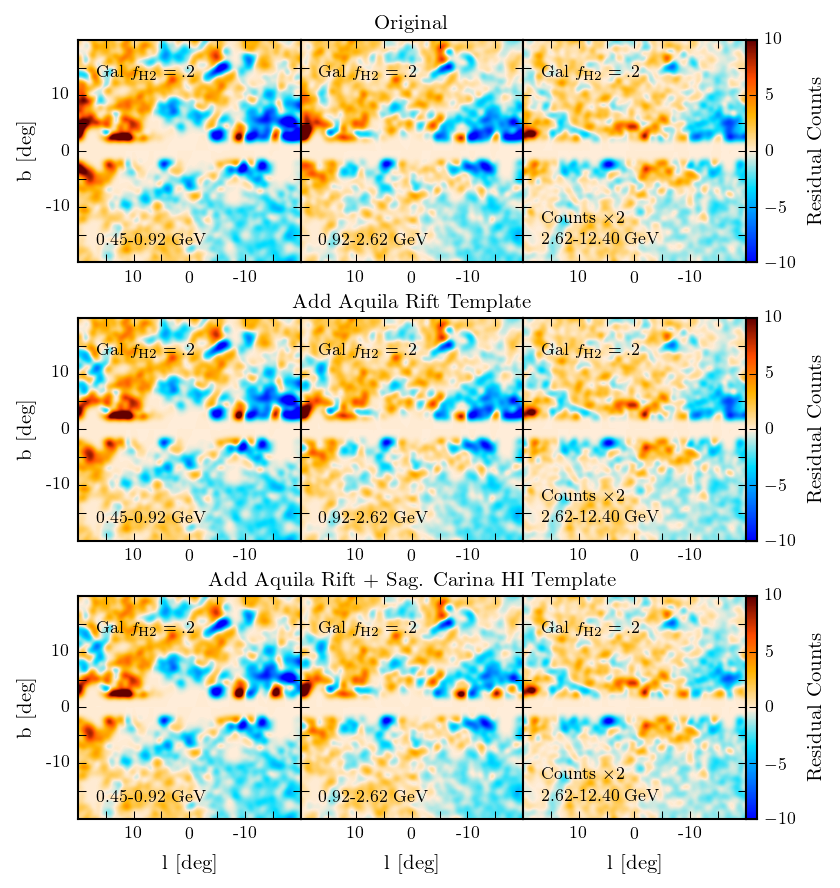

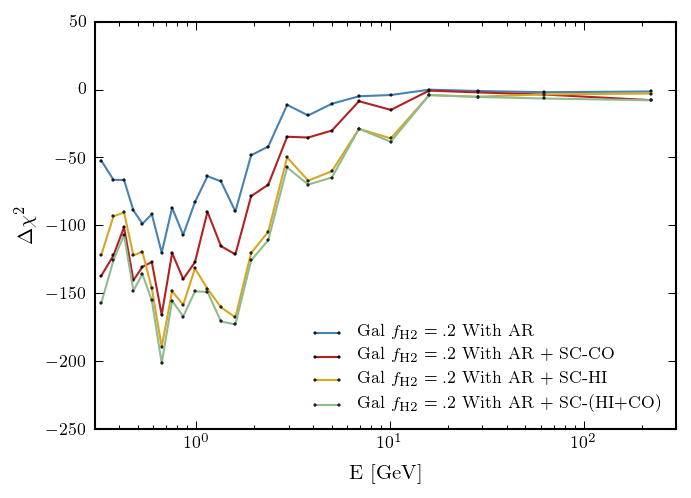

In [339]:
from scipy import ndimage

from matplotlib.colors import ListedColormap
import numpy as np
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
#colombi1_cmap.set_under("white") # color of background, necessary if you want to use
# this colormap directly with hp.mollview(m, cmap=colombi1_cmap)
cmap = colombi1_cmap


def PlotResiduals(A, e_range, text, grid):
    E = A.central_energies
    E_bin_1, E_bin_2 = np.argmin(np.abs(e_range[0]-E)), np.argmin(np.abs(e_range[1]-E))
    plt.figure(2)
    
    np.sum(A.residual[E_bin_1:E_bin_2]*A.psc_weights[E_bin_1:E_bin_2], axis=0)*A.mask
    m = healpy.cartview(np.sum(A.residual[E_bin_1:E_bin_2]*A.psc_weights[E_bin_1:E_bin_2], axis=0)*A.mask,latra=[-20,20], lonra=[-20,20],xsize=320, return_projected_map=True, hold=True, cbar=False)
    real_energies=(E[E_bin_1]/1e3,E[E_bin_2]/1e3) 
    
    plt.clf()
    plt.figure(1)
    multiplier = 1
    
    if e_range[0] > 2e3: 
        multiplier = 2 
        grid.text(.08,.19, r'Counts $\tibmes 2$', transform=grid.transAxes, fontsize=8,)
    im = grid.imshow(ndimage.gaussian_filter(m*multiplier,4), origin='lower', extent=[20,-20,-20,20], cmap=cmap, vmin=-10,vmax=10)
    
    grid.xaxis.set_ticks([-15,-10,-5,0,5,10,15])
    grid.yaxis.set_ticks([-15,-10,-5,0,5,10,15])
    grid.xaxis.set_ticklabels(["",-10,"",0,"",10,""])
    grid.yaxis.set_ticklabels(["",-10,"",0,"",10,""])
    grid.text(.08,.08,'%1.2f-%1.2f GeV'%(A.bin_edges[E_bin_1]/1e3,A.bin_edges[E_bin_2+1]/1e3), transform=grid.transAxes, fontsize=8)
    grid.text(.08,.82, text, transform=grid.transAxes, fontsize=8)
    #plt.colorbar(label='Residual Counts')
    return im 
  
    
#PlotResidual(A, [.5e3, .75e3])
    


from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(1, figsize=(6,6.7))

grid = AxesGrid(fig, 311, # similar to subplot(142)
                        nrows_ncols = (1, 3),
                        axes_pad = 0,
                        share_all=True,
                        label_mode = "L",
                        cbar_location = "right",
                        cbar_mode='single',)
grid2 = AxesGrid(fig, 312, # similar to subplot(142)
                        nrows_ncols = (1, 3),
                        axes_pad = 0,
                        share_all=True,
                        label_mode = "L",
                        cbar_location = "right",
                        cbar_mode='single',)

grid3 = AxesGrid(fig, 313, # similar to subplot(142)
                        nrows_ncols = (1, 3),
                        axes_pad = 0,
                        share_all=True,
                        label_mode = "L",
                        cbar_location = "right",
                        cbar_mode='single',)


for i_E, E_range in enumerate([[.5e3, .92e3],[1e3,2.5e3], [2.8e3,10e3]]):
    im = PlotResiduals(A,e_range=E_range, text=r'Gal $f_{\rm H2}=.2$', grid=grid[i_E])
    cbar = grid.cbar_axes[0].colorbar(im)    
    
    im = PlotResiduals(A2,e_range=E_range, text=r'Gal $f_{\rm H2}=.2$',grid=grid2[i_E])
    cbar = grid2.cbar_axes[0].colorbar(im)
    
    im = PlotResiduals(A4,e_range=E_range, text=r'Gal $f_{\rm H2}=.2$',grid=grid3[i_E])
    cbar = grid3.cbar_axes[0].colorbar(im)
    
    #plt.show()
    
for cax in grid2.cbar_axes[1:]:
    cax.toggle_label(False)
    

for i in [0,1,2]:
    grid3[i].set_xlabel('l [deg]')
    #grid2[i].set_xlabel('l [deg]')
    
for i in [0,]:
    grid[i].set_ylabel('b [deg]')
    grid2[i].set_ylabel('b [deg]')
    grid3[i].set_ylabel('b [deg]')
    #grid2[i].yaxis.set_ticklabels([])
    

cbar.solids.set_edgecolor("face")
    
fig.subplots_adjust(hspace=0.25)
grid[1].text(.5, 1.05, r'Original', horizontalalignment='center', transform=grid[1].transAxes, fontsize=10)
grid2[1].text(.5, 1.05, r'Add Aquila Rift Template', horizontalalignment='center', transform=grid2[1].transAxes, fontsize=10)
grid3[1].text(.5, 1.05, r'Add Aquila Rift + Sag. Carina HI Template', horizontalalignment='center', transform=grid3[1].transAxes, fontsize=10)

grid.cbar_axes[0].set_ylabel(r'Residual Counts') 
grid2.cbar_axes[0].set_ylabel(r'Residual Counts') 
grid3.cbar_axes[0].set_ylabel(r'Residual Counts') 


#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/residuals_AQ-Sag-template_GAL.pdf', bbox_inches='tight')

plt.show()


plt.plot(A2.central_energies/1e3 , -2*(np.array(A.loglike)-np.array(A2.loglike)),
         label=r'Gal $f_{\rm H2}=.2$ With AR', color='steelblue', alpha=1, marker='o',markersize=1 )
plt.plot(A3.central_energies/1e3 , -2*(np.array(A.loglike)-np.array(A3.loglike)),
         label=r'Gal $f_{\rm H2}=.2$ With AR + SC-CO', color='firebrick', alpha=1, marker='o',markersize=1 )
plt.plot(A4.central_energies/1e3 , -2*(np.array(A.loglike)-np.array(A4.loglike)),
         label=r'Gal $f_{\rm H2}=.2$ With AR + SC-HI', color='goldenrod', alpha=1, marker='o',markersize=1 )
plt.plot(A5.central_energies/1e3 , -2*(np.array(A.loglike)-np.array(A5.loglike)),
         label=r'Gal $f_{\rm H2}=.2$ With AR + SC-(HI+CO)', color='darkseagreen', alpha=1, marker='o',markersize=1 )
plt.xscale('log')
plt.xlabel('E [GeV]')
plt.ylabel(r'$\Delta\chi^2$') 
plt.ylim(-250,50)
plt.xlim(.3,3e2)
plt.legend(frameon=False, fontsize=8, loc=4, ncol=1, columnspacing=.5)
#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/TS_AQ-Sag-template_GAL.pdf', bbox_inches='tight')

# Compare Residuals PEB


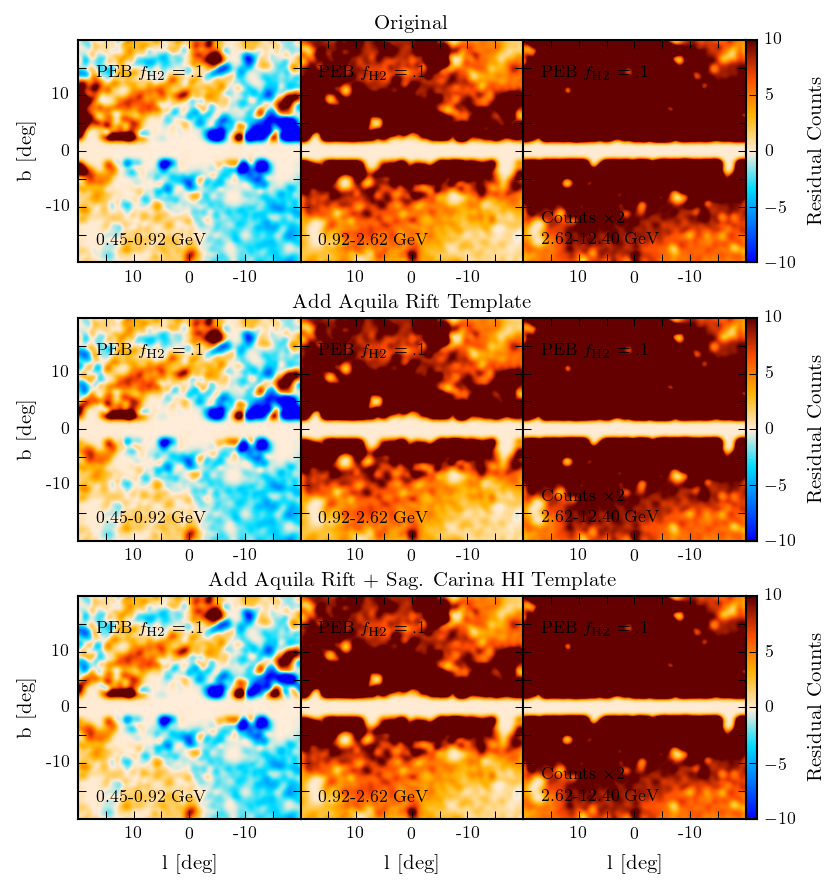

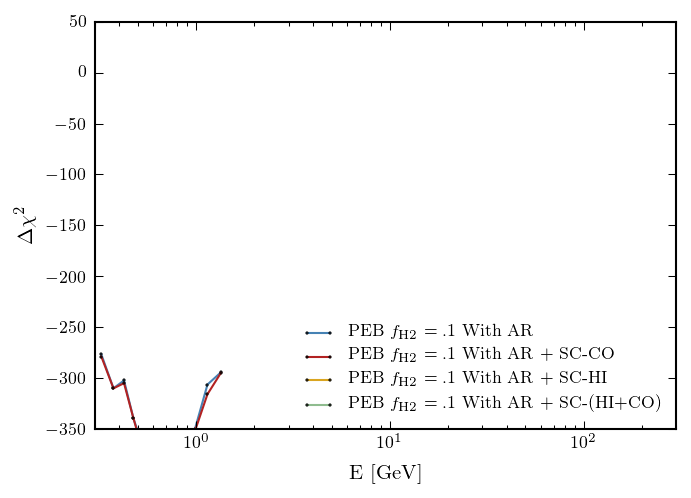

In [386]:
from scipy import ndimage

from matplotlib.colors import ListedColormap
import numpy as np
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
#colombi1_cmap.set_under("white") # color of background, necessary if you want to use
# this colormap directly with hp.mollview(m, cmap=colombi1_cmap)
cmap = colombi1_cmap


def PlotResiduals(A, e_range, text, grid):
    E = A.central_energies
    E_bin_1, E_bin_2 = np.argmin(np.abs(e_range[0]-E)), np.argmin(np.abs(e_range[1]-E))
    plt.figure(2)
    
    np.sum(A.residual[E_bin_1:E_bin_2]*A.psc_weights[E_bin_1:E_bin_2], axis=0)*A.mask
    m = healpy.cartview(np.sum(A.residual[E_bin_1:E_bin_2]*A.psc_weights[E_bin_1:E_bin_2], axis=0)*A.mask,latra=[-20,20], lonra=[-20,20],xsize=320, return_projected_map=True, hold=True, cbar=False)
    real_energies=(E[E_bin_1]/1e3,E[E_bin_2]/1e3) 
    
    plt.clf()
    plt.figure(1)
    multiplier = 1
    
    if e_range[0] > 2e3: 
        multiplier = 2 
        grid.text(.08,.19, r'Counts $\times 2$', transform=grid.transAxes, fontsize=8,)
    im = grid.imshow(ndimage.gaussian_filter(m*multiplier,4), origin='lower', extent=[20,-20,-20,20], cmap=cmap, vmin=-10,vmax=10)
    
    grid.xaxis.set_ticks([-15,-10,-5,0,5,10,15])
    grid.yaxis.set_ticks([-15,-10,-5,0,5,10,15])
    grid.xaxis.set_ticklabels(["",-10,"",0,"",10,""])
    grid.yaxis.set_ticklabels(["",-10,"",0,"",10,""])
    grid.text(.08,.08,'%1.2f-%1.2f GeV'%(A.bin_edges[E_bin_1]/1e3,A.bin_edges[E_bin_2+1]/1e3), transform=grid.transAxes, fontsize=8)
    grid.text(.08,.82, text, transform=grid.transAxes, fontsize=8)
    #plt.colorbar(label='Residual Counts')
    return im 
  
    
#PlotResidual(A, [.5e3, .75e3])
    


from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(1, figsize=(6,6.7))

grid = AxesGrid(fig, 311, # similar to subplot(142)
                        nrows_ncols = (1, 3),
                        axes_pad = 0,
                        share_all=True,
                        label_mode = "L",
                        cbar_location = "right",
                        cbar_mode='single',)
grid2 = AxesGrid(fig, 312, # similar to subplot(142)
                        nrows_ncols = (1, 3),
                        axes_pad = 0,
                        share_all=True,
                        label_mode = "L",
                        cbar_location = "right",
                        cbar_mode='single',)

grid3 = AxesGrid(fig, 313, # similar to subplot(142)
                        nrows_ncols = (1, 3),
                        axes_pad = 0,
                        share_all=True,
                        label_mode = "L",
                        cbar_location = "right",
                        cbar_mode='single',)


for i_E, E_range in enumerate([[.5e3, .92e3],[1e3,2.5e3], [2.8e3,10e3]]):
    im = PlotResiduals(A,e_range=E_range, text=r'PEB $f_{\rm H2}=.1$', grid=grid[i_E])
    cbar = grid.cbar_axes[0].colorbar(im)    
    
    im = PlotResiduals(A2,e_range=E_range, text=r'PEB $f_{\rm H2}=.1$',grid=grid2[i_E])
    cbar = grid2.cbar_axes[0].colorbar(im)
    
    im = PlotResiduals(A4,e_range=E_range, text=r'PEB $f_{\rm H2}=.1$',grid=grid3[i_E])
    cbar = grid3.cbar_axes[0].colorbar(im)
    
    #plt.show()
    
for cax in grid2.cbar_axes[1:]:
    cax.toggle_label(False)
    

for i in [0,1,2]:
    grid3[i].set_xlabel('l [deg]')
    #grid2[i].set_xlabel('l [deg]')
    
for i in [0,]:
    grid[i].set_ylabel('b [deg]')
    grid2[i].set_ylabel('b [deg]')
    grid3[i].set_ylabel('b [deg]')
    #grid2[i].yaxis.set_ticklabels([])
    

cbar.solids.set_edgecolor("face")
    
fig.subplots_adjust(hspace=0.25)
grid[1].text(.5, 1.05, r'Original', horizontalalignment='center', transform=grid[1].transAxes, fontsize=10)
grid2[1].text(.5, 1.05, r'Add Aquila Rift Template', horizontalalignment='center', transform=grid2[1].transAxes, fontsize=10)
grid3[1].text(.5, 1.05, r'Add Aquila Rift + Sag. Carina HI Template', horizontalalignment='center', transform=grid3[1].transAxes, fontsize=10)

grid.cbar_axes[0].set_ylabel(r'Residual Counts') 
grid2.cbar_axes[0].set_ylabel(r'Residual Counts') 
grid3.cbar_axes[0].set_ylabel(r'Residual Counts') 


#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/residuals_AQ-Sag-template_PEB.pdf', bbox_inches='tight')

plt.show()


plt.plot(A2.central_energies/1e3 , -2*(np.array(A.loglike)-np.array(A2.loglike)),
         label=r'PEB $f_{\rm H2}=.1$ With AR', color='steelblue', alpha=1, marker='o',markersize=1 )
plt.plot(A3.central_energies/1e3 , -2*(np.array(A.loglike)-np.array(A3.loglike)),
         label=r'PEB $f_{\rm H2}=.1$ With AR + SC-CO', color='firebrick', alpha=1, marker='o',markersize=1 )
plt.plot(A4.central_energies/1e3 , -2*(np.array(A.loglike)-np.array(A4.loglike)),
         label=r'PEB $f_{\rm H2}=.1$ With AR + SC-HI', color='goldenrod', alpha=1, marker='o',markersize=1 )
plt.plot(A5.central_energies/1e3 , -2*(np.array(A.loglike)-np.array(A5.loglike)),
         label=r'PEB $f_{\rm H2}=.1$ With AR + SC-(HI+CO)', color='darkseagreen', alpha=1, marker='o',markersize=1 )
plt.xscale('log')
plt.xlabel('E [GeV]')
plt.ylabel(r'$\Delta\chi^2$') 
plt.ylim(-350,50)
plt.xlim(.3,3e2)
plt.legend(frameon=False, fontsize=8, loc=4, ncol=1, columnspacing=.5)
#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/TS_AQ-Sag-template_PEB.pdf', bbox_inches='tight')

(0.3, 500)

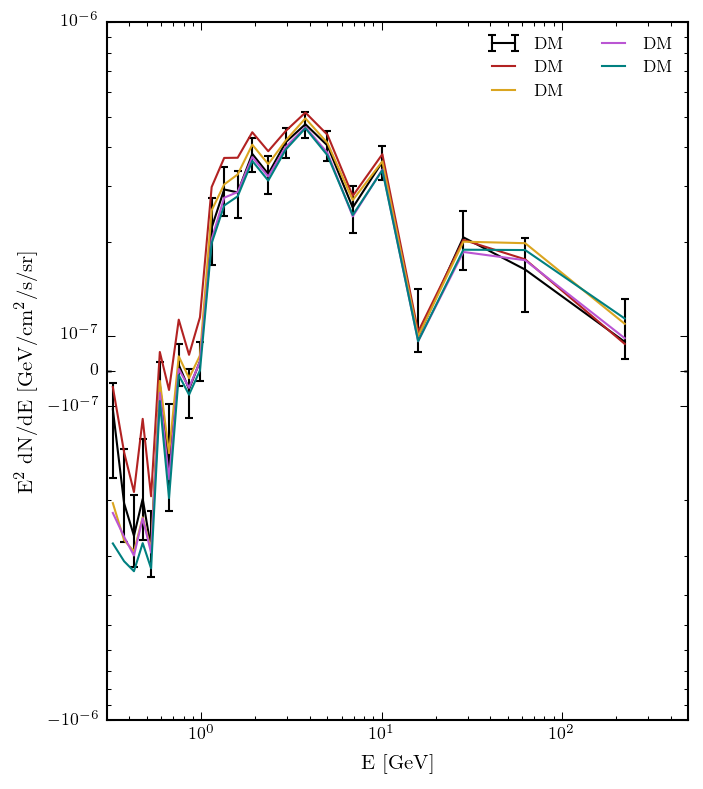

In [381]:
import Template
import Tools, healpy
reload(Tools)


#print np.array(A.m.matrix()).shape

#print A.templateList['DM'].valueError/A.templateList['DM'].value


plt.figure(figsize=(5,6))
def PlotComponent(A, name, mult=1,err=False):
    E, flux, stat = A.GetSpectrum(name)
    #if stat
    if err==True:
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=name.replace('_','+'),
                     capthick=1, capsize=2, ls='-',c='k')
    else:
        plt.errorbar(E/1e3,E**2*flux*mult/1e3, label=name.replace('_','+'),capthick=1, capsize=2, ls='-' )
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    
for i, a in enumerate([A,A2,A3,A4,A5]):
    if i==0:
        PlotComponent(a, 'DM', err=True)
    else:
        PlotComponent(a, 'DM', err=False)
        
linthresh=1e-7
plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
plt.ylim(-1e-6,1e-6)

plt.legend(frameon=False, fontsize=8,ncol=2)
#plt.ylim(1e-8,4e-4)
plt.xlim(.3,500)


#A.SaveSpectra('./mod_c/spec_mod_s_P8_PSF3.pickle') # 3FGL with ext XCO fitted 
#A.SaveSpectra('./mod_c/spec_mod_s_42_40x40_noDM.pickle') # 3FGL with ext XCO fitted 

#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/TS_AQ-Sag-template_PEB.pdf', bbox_inches='tight')

# Generate SC templates

/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: invalid value encountered in log10
/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:56: RuntimeWarning: divide by zero encountered in log10


0.425 0.903125


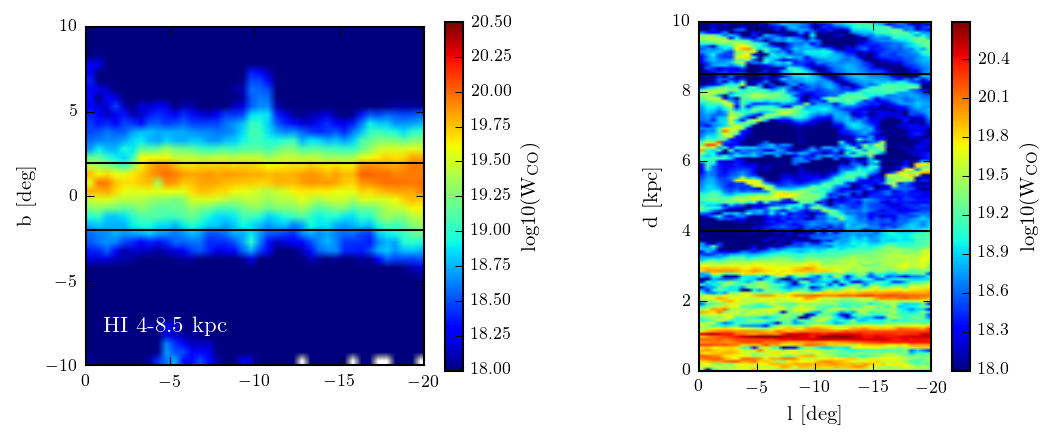

In [368]:




def PlotROI(lonra, latra, drange, fname='/data/galprop2/FITS/CO_Pohl_8500_rlb.fits',vmin=-1.5, vmax=2):
    hdu = pyfits.open(fname)
    
    d = hdu[0].data
    delta_r = hdu[0].header['CDELT1']
    NAXIS2 =  hdu[0].header['NAXIS2']
    NAXIS3 =  hdu[0].header['NAXIS3']
    delta_l = hdu[0].header['CDELT2']
    
    start, stop = int(np.round(drange[0]/delta_r)), int(np.round(drange[1]/delta_r))
    im = plt.imshow(np.log10(np.sum(np.roll(d[:,:,start:stop],NAXIS2/2, axis=1), axis=2)[NAXIS3/2+int(latra[0]/delta_l):NAXIS3/2+int(latra[1]/delta_l),
                                                                       NAXIS2/2+int(lonra[0]/delta_l):NAXIS2/2+int(lonra[1]/delta_l)]), 
                    extent=[lonra[0],lonra[1], latra[0],latra[1]], vmin=vmin, vmax=vmax, origin='lower')
    
    plt.colorbar(im,label=r'log10($\rm W_{CO}$)')
    plt.xlim(lonra[1],lonra[0])
    plt.ylim(latra[0],latra[1])
    
    return (np.sum(np.roll(d[:,:,start:stop],NAXIS2/2, axis=1), axis=2)[NAXIS3/2+int(latra[0]/delta_l):NAXIS3/2+int(latra[1]/delta_l),
                                                                       NAXIS2/2+int(lonra[0]/delta_l):NAXIS2/2+int(lonra[1]/delta_l)], 
            np.roll(d[:,:,:],NAXIS2/2, axis=1)[NAXIS3/2+int(latra[0]/delta_l):NAXIS3/2+int(latra[1]/delta_l),
                                                                       NAXIS2/2+int(lonra[0]/delta_l):NAXIS2/2+int(lonra[1]/delta_l)])
    

plt.figure(figsize=(8,3))


for i, dra in enumerate([[4, 8.5],]):
    lonra, latra, drange = [-20,0], [-10,10],dra
    plt.subplot(1,2,i+1)
    #cartmap, cube = PlotROI(lonra, latra, dra) # CO Maps
    cartmap, cube = PlotROI(lonra, latra, dra, fname='/data/galprop2/FITS/HI_Pohl_8500_rlb.fits',vmax=20.5, vmin=18) # HI MAPS
    plt.text(-1,-8,('HI {0}-{1} kpc'.format(drange[0],drange[1])), color='w', fontsize=11)
    plt.vlines([20,-20],-30,30,color='r')
    plt.hlines([2,-2],-50,50)
    if i == 2:
        plt.xlabel('l [deg]')
    plt.ylabel('b [deg]')



plt.subplot(122)

hdu = pyfits.open('/data/galprop2/FITS/CO_Pohl_8500_rlb.fits')
d = hdu[0].data
delta_r = hdu[0].header['CDELT1']

#start, stop = int(np.round(drange[0]/delta_r)), int(np.round(drange[1]/delta_r))
#print np.shape(d)
print 0.10625*drange[0],0.10625*drange[1]
#im = plt.imshow(np.log10(np.sum(cube, axis=0)).T, extent=[lonra[0],lonra[1],0,hdu[0].header['CDELT1']*hdu[0].header['NAXIS1']], vmin=-2, origin='lower', aspect=5, cmap='jet')
im = plt.imshow(np.log10(np.sum(cube, axis=0)).T, extent=[lonra[0],lonra[1],0,hdu[0].header['CDELT1']*hdu[0].header['NAXIS1']], vmin=18, origin='lower', aspect=3, cmap='jet')
plt.colorbar(im,label=r'log10($\rm W_{CO}$)')

plt.xlabel('l [deg]')
plt.ylabel('d [kpc]')
plt.xlim(lonra[1],lonra[0])
plt.ylim(0,10)
plt.hlines([4,8.5],-50,50)


plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/sag_carina_template.pdf', bbox_inches='tight')


/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10
/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: invalid value encountered in log10


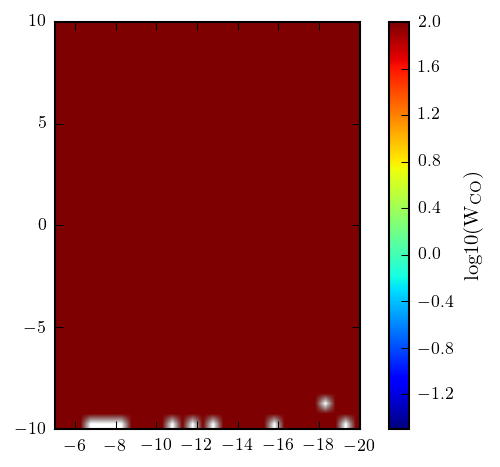

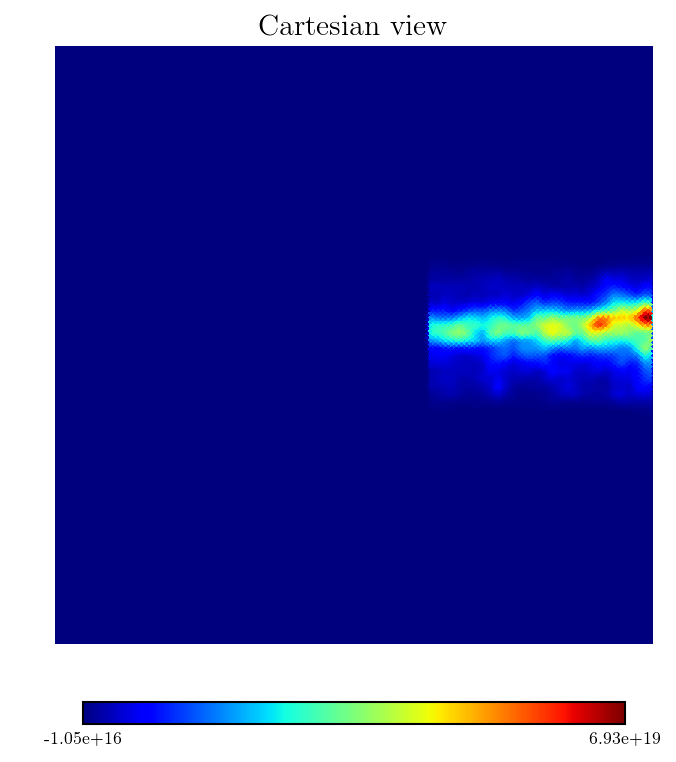

In [369]:


cartmap, cube = PlotROI(lonra=[-20,-5], latra=[-10,10], drange=[4,6], fname='/data/galprop2/FITS/HI_Pohl_8500_rlb.fits')
m = Cart2Healpix(cartmap,nside=256, extent=[-20,-5,-10,10], res=.5)
healpy.cartview(m, latra=[-20,20], lonra=[-20,20])




np.save('sag_carina_HI_template.npy',m)

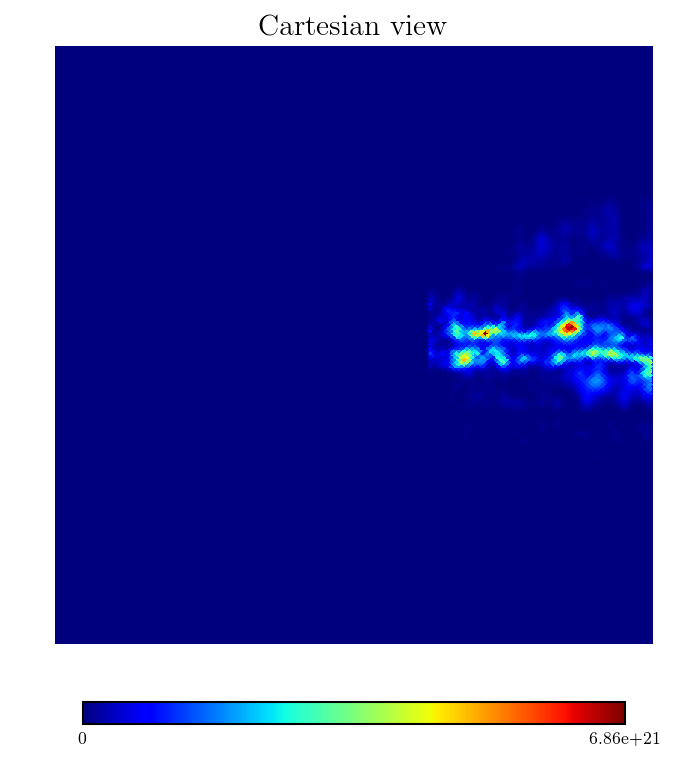

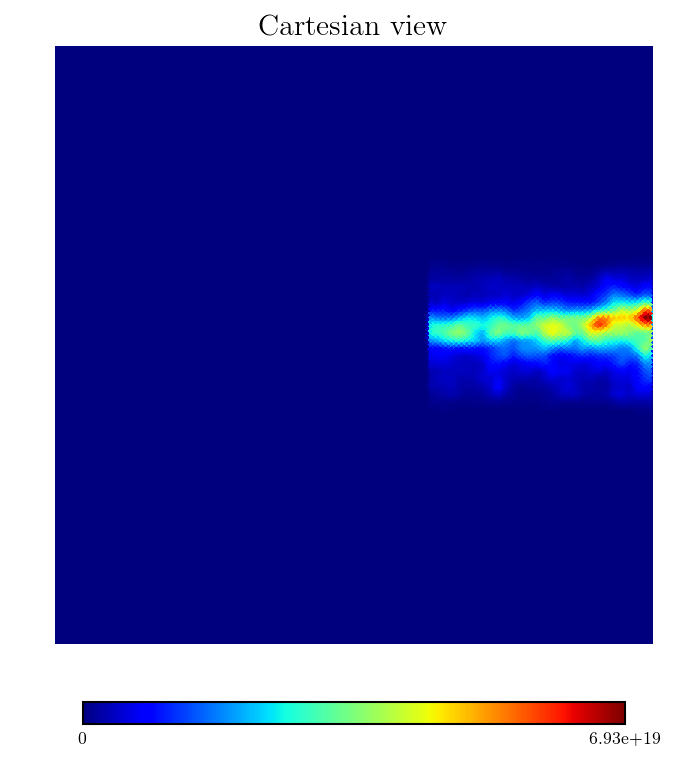

In [324]:
healpy.cartview(SC_temp_single*1e20,latra=[-20,20], lonra=[-20,20])
healpy.cartview(SC_HI_temp_single, latra=[-20,20], lonra=[-20,20])